In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt 
import matplotlib.pyplot as plt


In [2]:
gas_data = pd.read_csv("clean_df.csv")
len(gas_data)

327075

In [3]:
#preprocessing data for easier computation in the following 
start_time = timeit.default_timer()
gas_data.localminute = gas_data.localminute.str.slice(0,19)
gas_data.localminute = pd.to_datetime(gas_data.localminute, infer_datetime_format = True, 
                                      format = "%Y/%m/%d %I:%M:%S %p");
gas_data.localminute = gas_data.localminute.map(lambda x:x.replace(minute=0, second=0));
gas_data['meter_value']=gas_data['meter_value'].astype(float)

In [4]:
#gas_data=gas_data[gas_data['dataid']==35];
ind=0;
_hr=dt.timedelta(hours=1); #creating a constant timedelta object with value =1 hr for comparison
temp_gas_hr=pd.DataFrame(columns=gas_data.columns);
temp_gas_hr=gas_data;
id_list=gas_data['dataid'].unique();#creating an id list for itertaion since only comparison of reading within id 
                                     #is meanningful

missing_lm=[];
missing_id=[];
missing_val=[];

for _id in id_list:
    #generate hourly readings according to dataid
    temp_gas_data=gas_data[gas_data['dataid']==_id];
    temp_gas_data.reset_index(drop=True,inplace=True);
    
    for  row in temp_gas_data.itertuples():
        if(row.Index==0):
            prev_row=pd.Series(data=[row.localminute,row.dataid,row.meter_value]
                               ,index=['localminute','dataid','meter_value']);
            #unable to predict datapoints before the first available datapoint
        else:
            time_diff=row.localminute-prev_row.localminute;
            #determine if there is any missing data before two consecutive available data
            if(time_diff>_hr):
                time_diff=int(time_diff.total_seconds()/3600);
                #determine how many datapoints are missing
                for j in range (1,time_diff):
                    if ((row.meter_value-prev_row.meter_value)>4):
                        #if the difference between two available datepoint is too large,
                        #this means that there is missing distinct datapoints in between.
                        acc_reading=float((row.meter_value-prev_row.meter_value)/time_diff);
                    else:
                        #if the difference is not large, the missing datapoint has value 
                        #equals to the previous datapoint
                        acc_reading=0;
                    time_change=dt.timedelta(hours=j);
                    new_time=prev_row.localminute+time_change;
                    missing_lm.append(new_time);
                    missing_id.append(_id);
                    missing_val.append(float(prev_row.meter_value+acc_reading*j));

        prev_row=pd.Series(data=[row.localminute,row.dataid,row.meter_value]
                               ,index=['localminute','dataid','meter_value']);
       #make a copy the current available data for comparison in next iteration


In [5]:
#concatenate the missing data with original data
missing_data={'localminute':missing_lm,'dataid':missing_id,'meter_value':missing_val};
missing_data=pd.DataFrame(missing_data,columns=gas_data.columns);
temp_gas_hr=pd.concat([gas_data,missing_data]);

In [6]:
temp_gas_hr=temp_gas_hr.sort_values(by=['dataid','localminute']);
temp_gas_hr.drop_duplicates(['localminute','dataid'],keep='last',inplace=True); 
#for the same hour, if there is multiple readings, keep the highest value
temp_gas_hr['meter_value']=temp_gas_hr['meter_value'].astype(int)
print("total: %ds" %(timeit.default_timer() - start_time))

total: 844s


In [7]:
temp_gas_hr.to_csv('hourly_readings_final.csv',index=False);

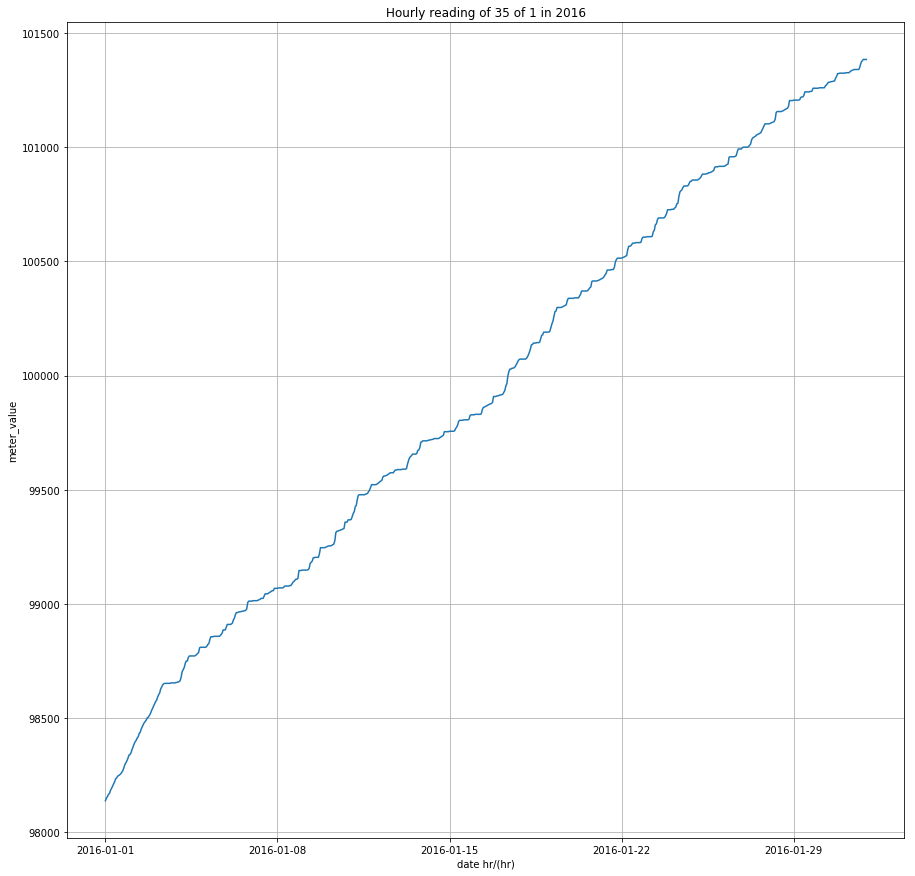

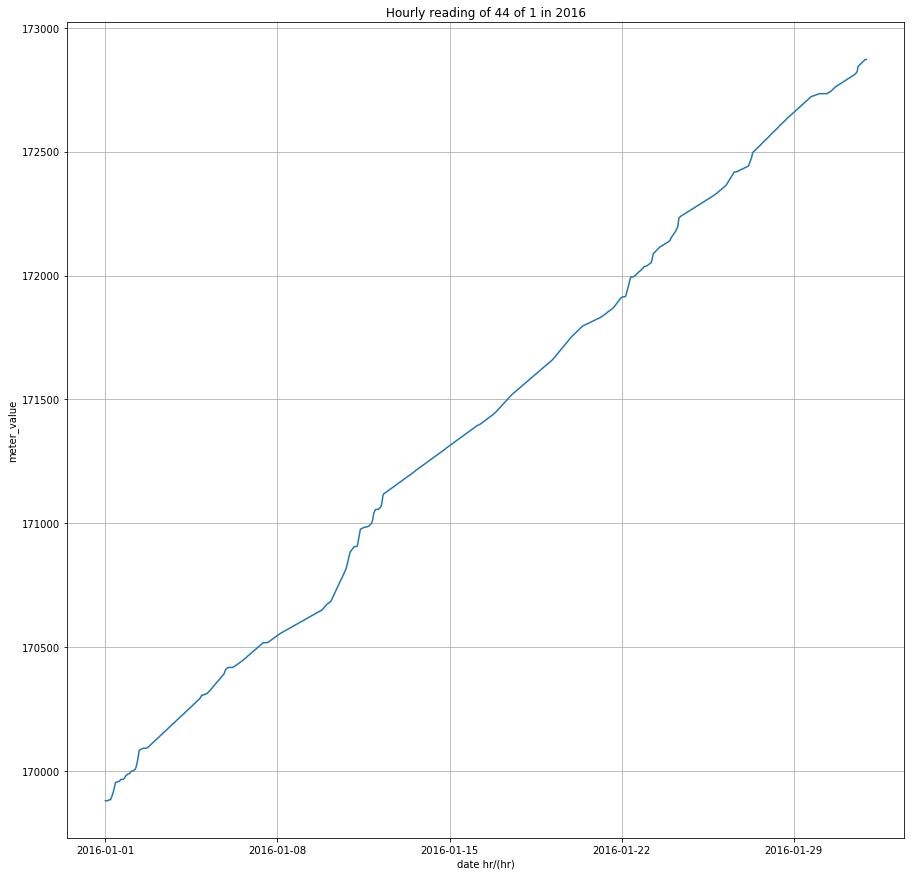

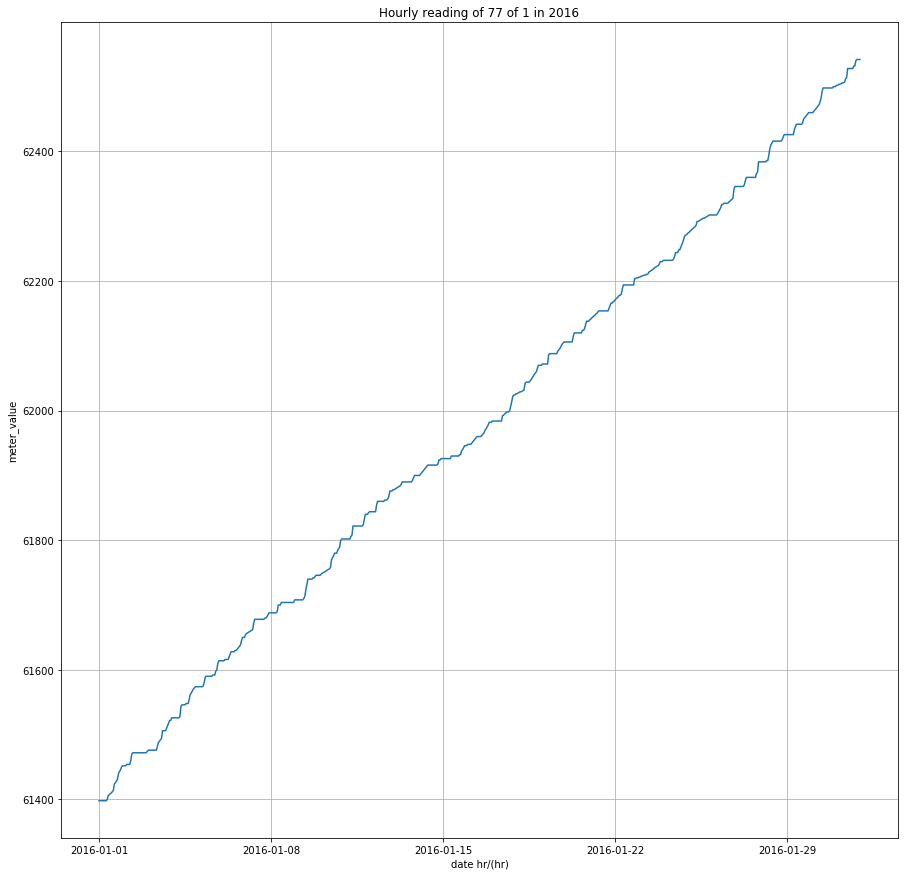

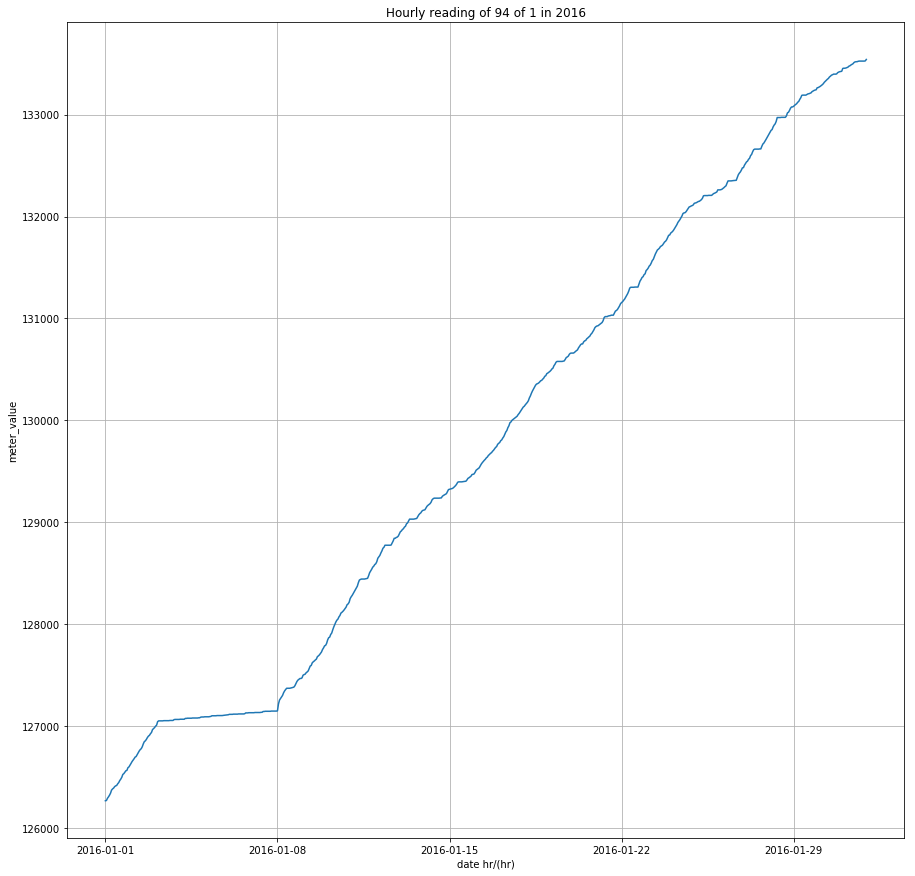

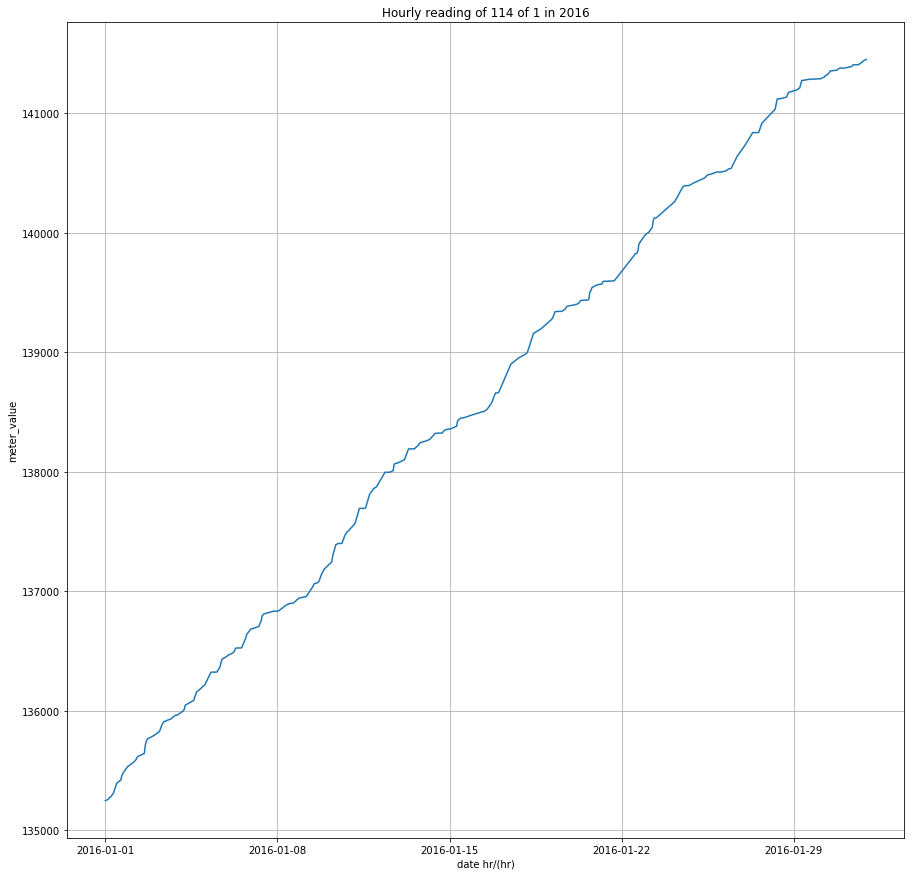

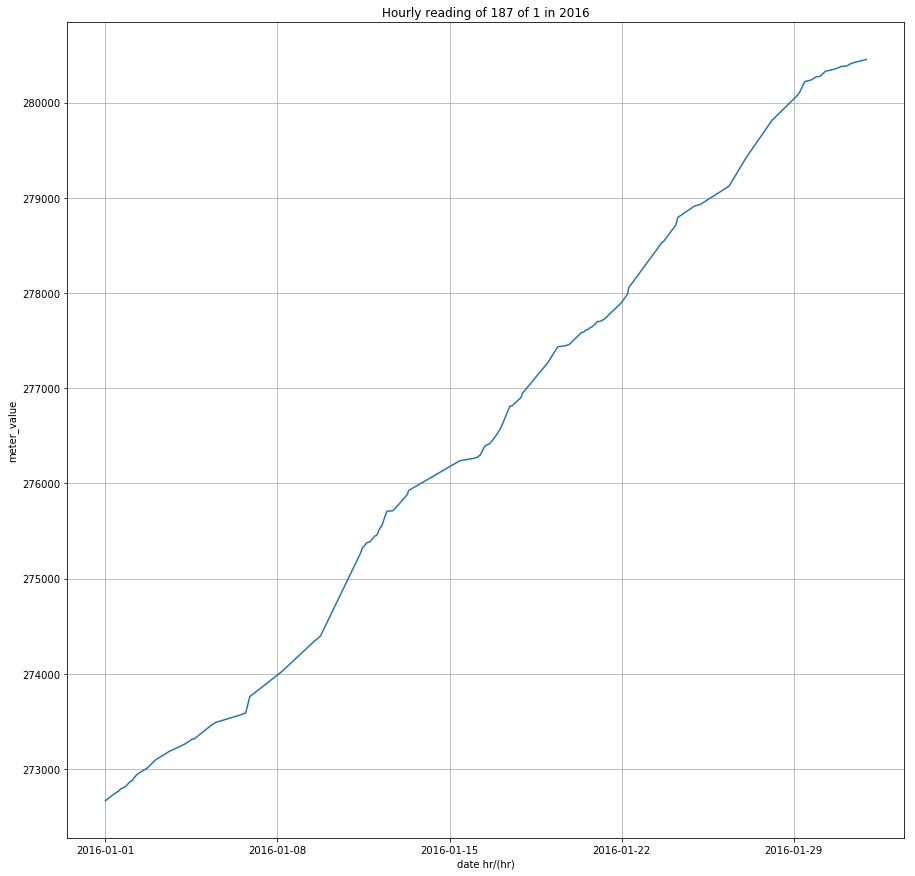

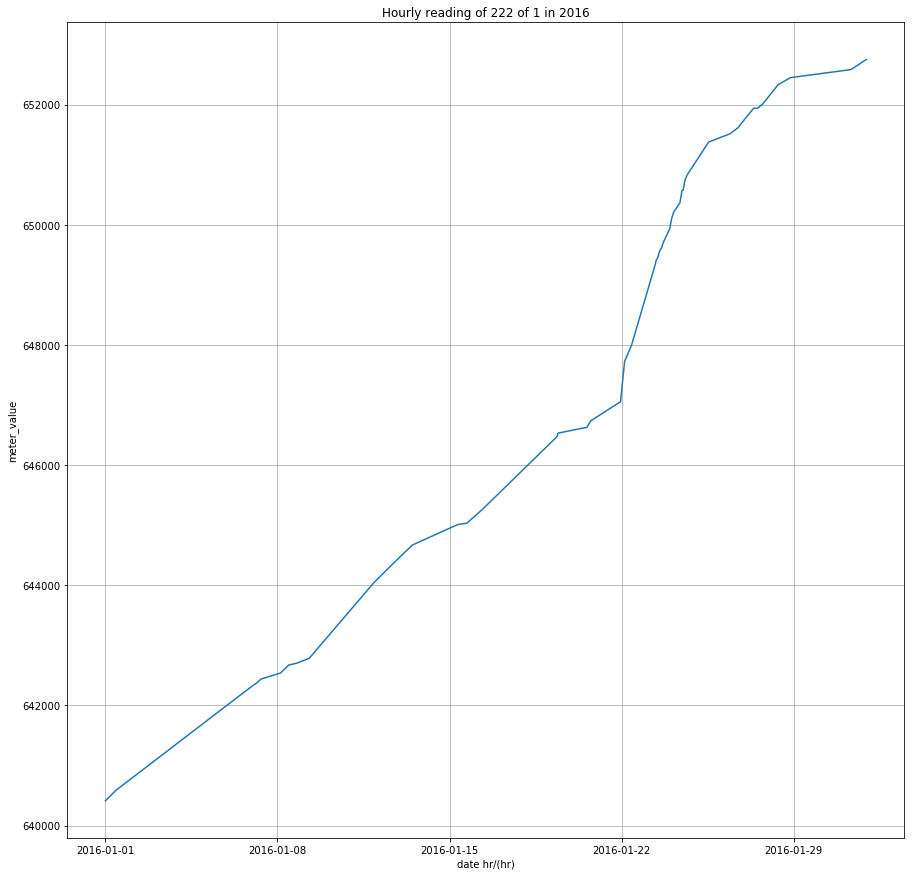

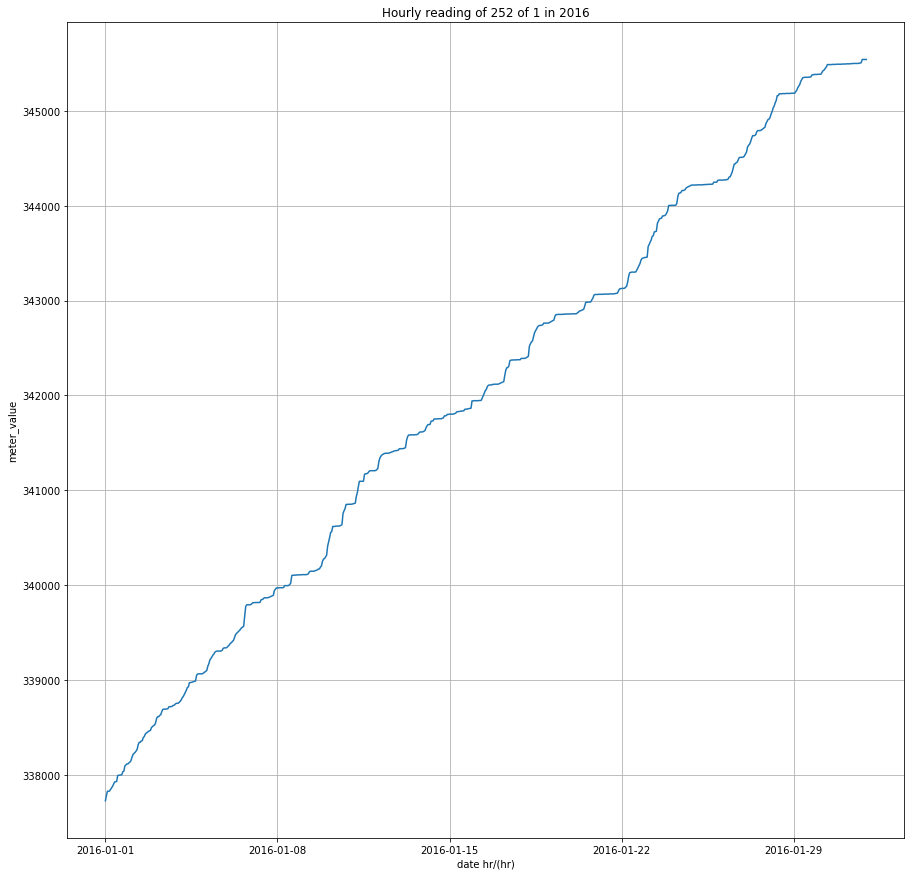

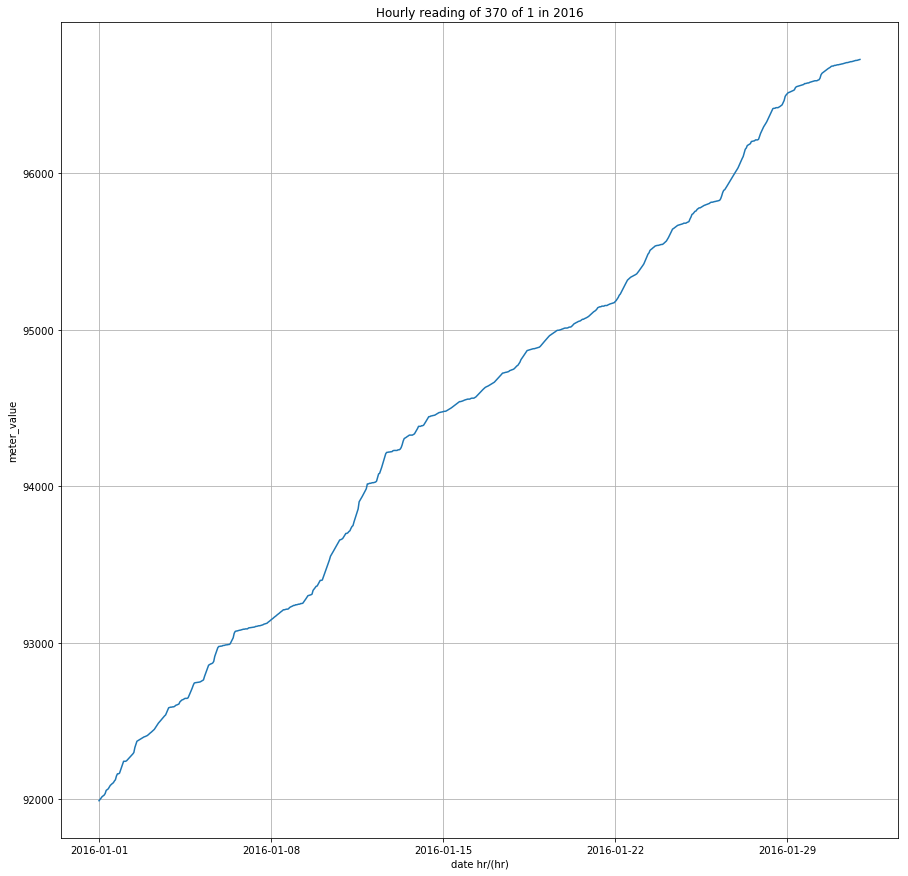

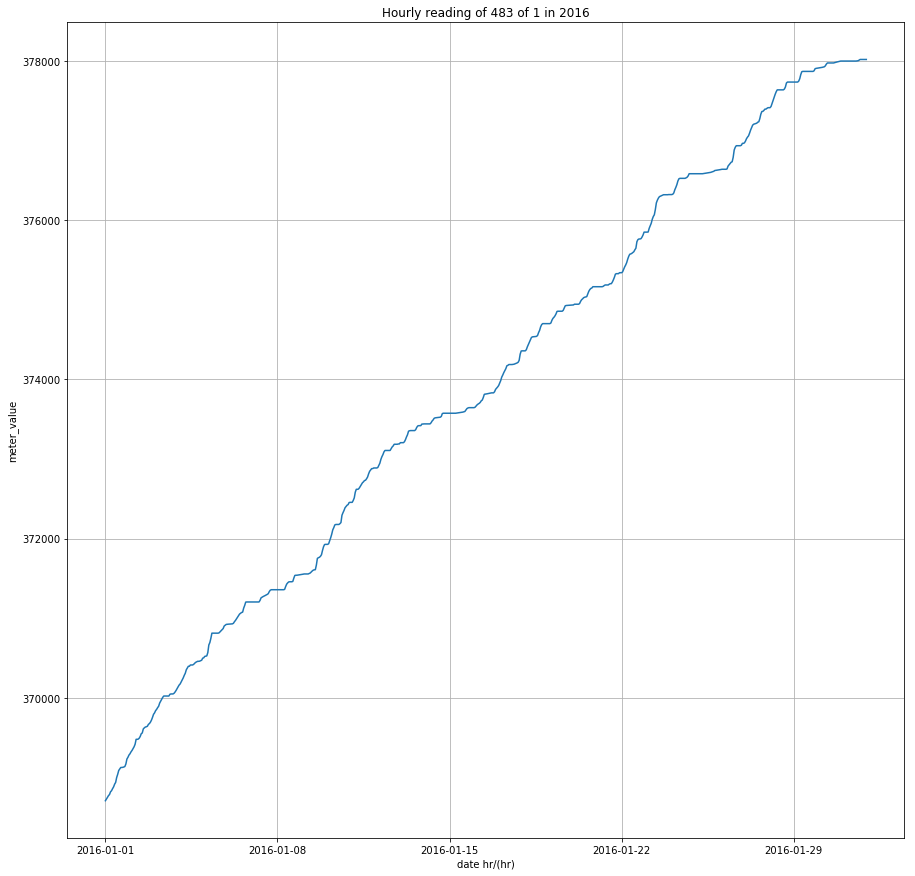

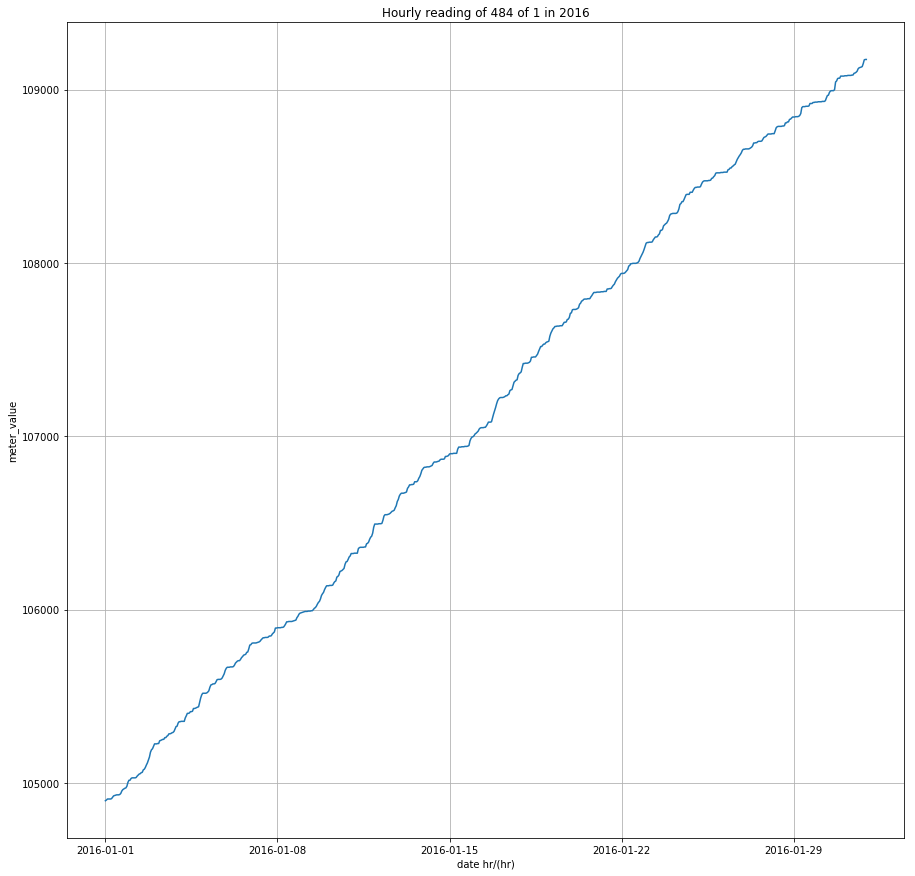

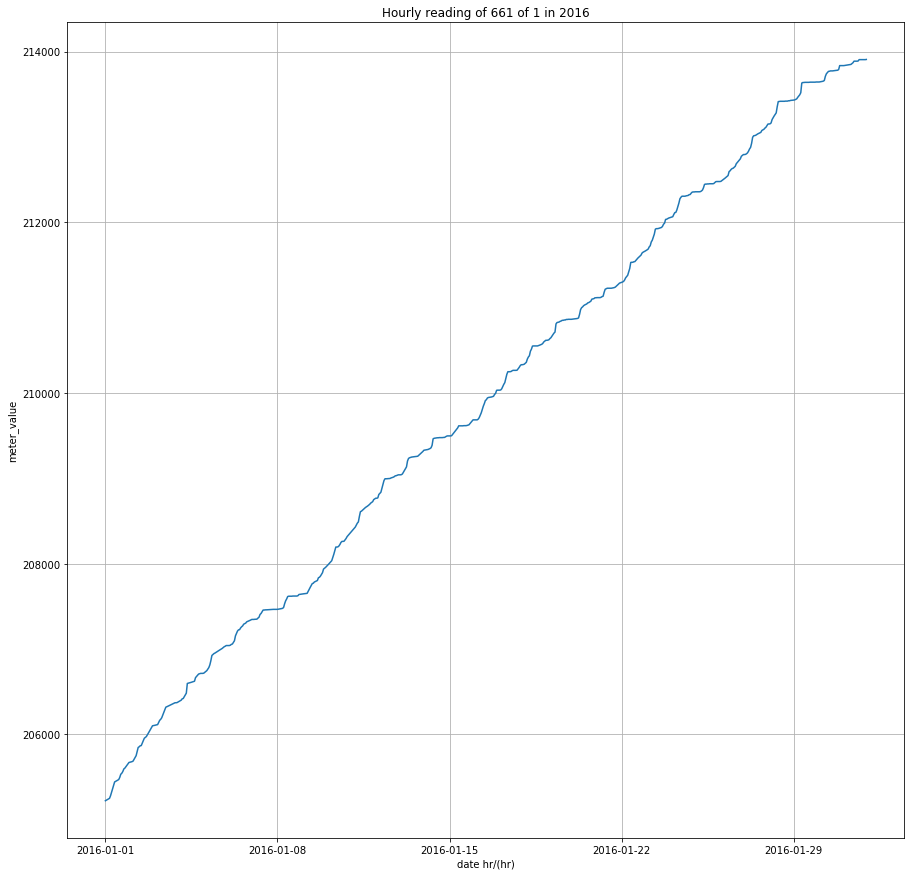

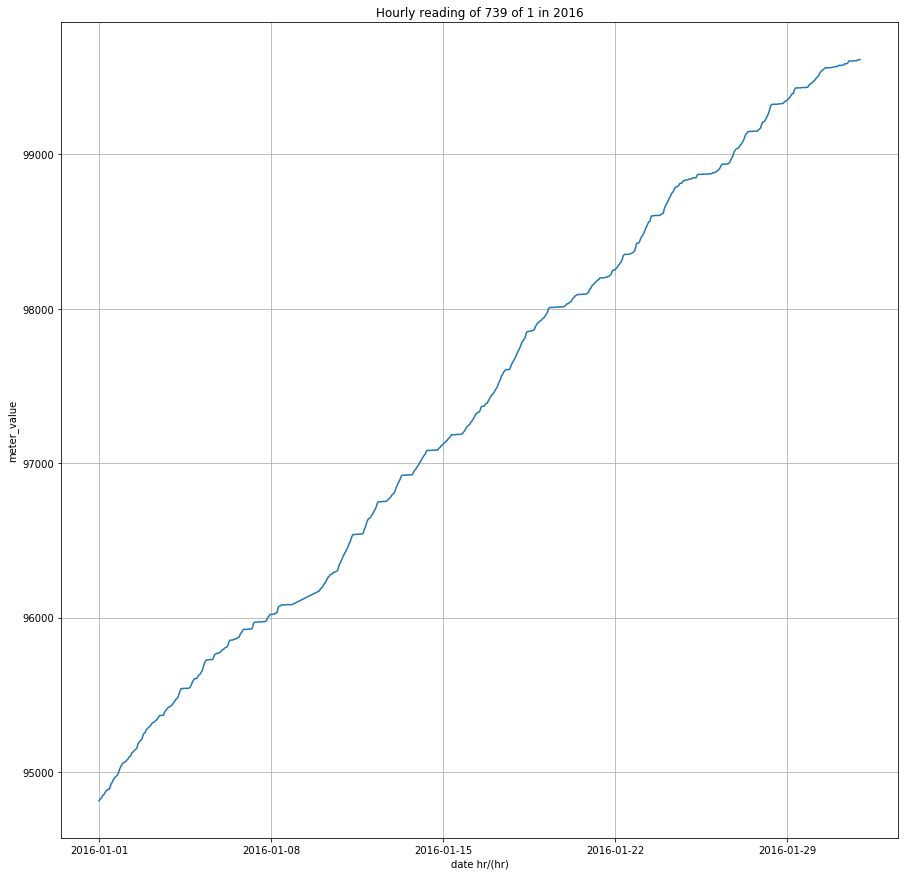

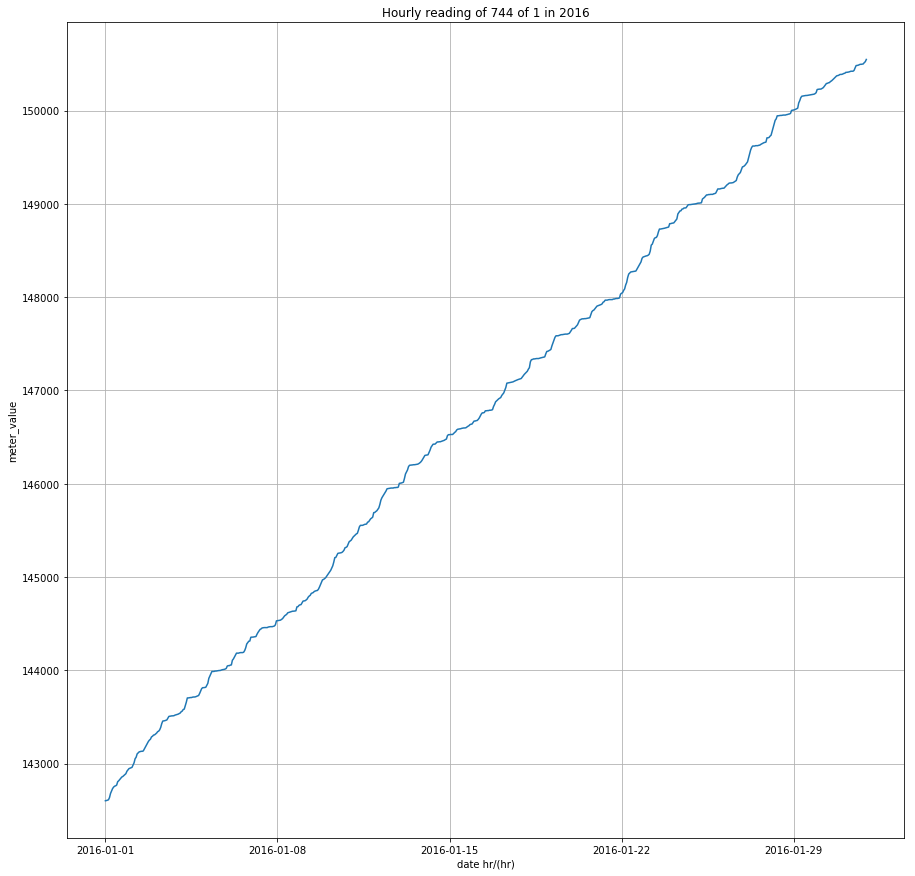

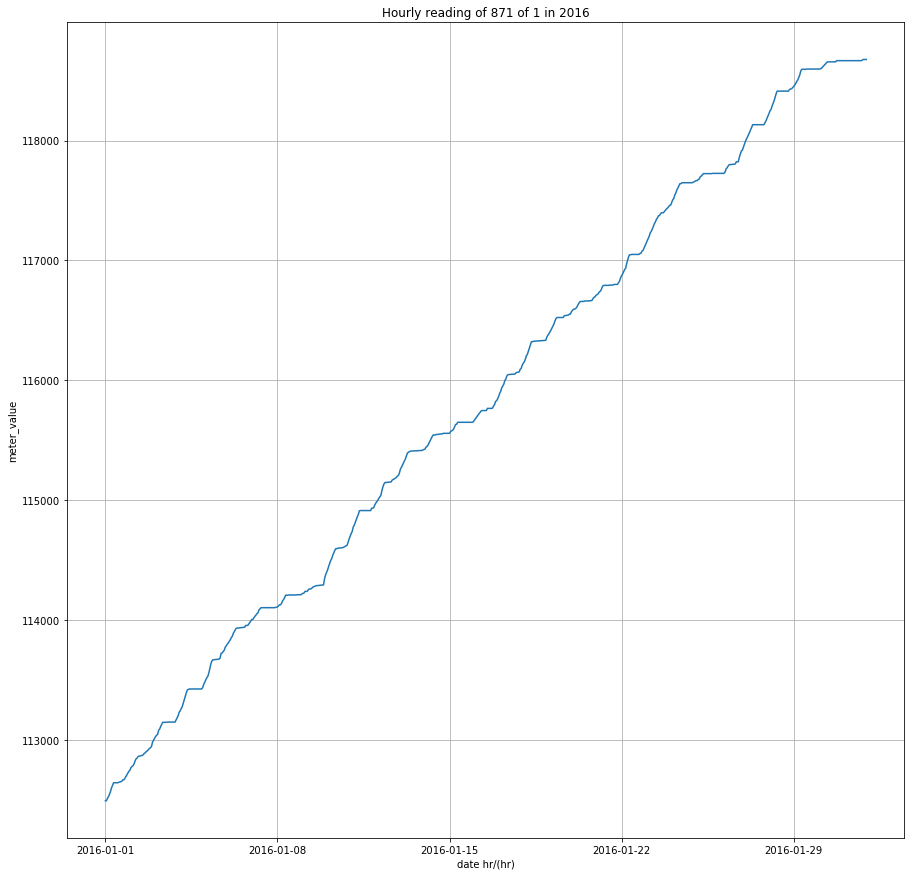

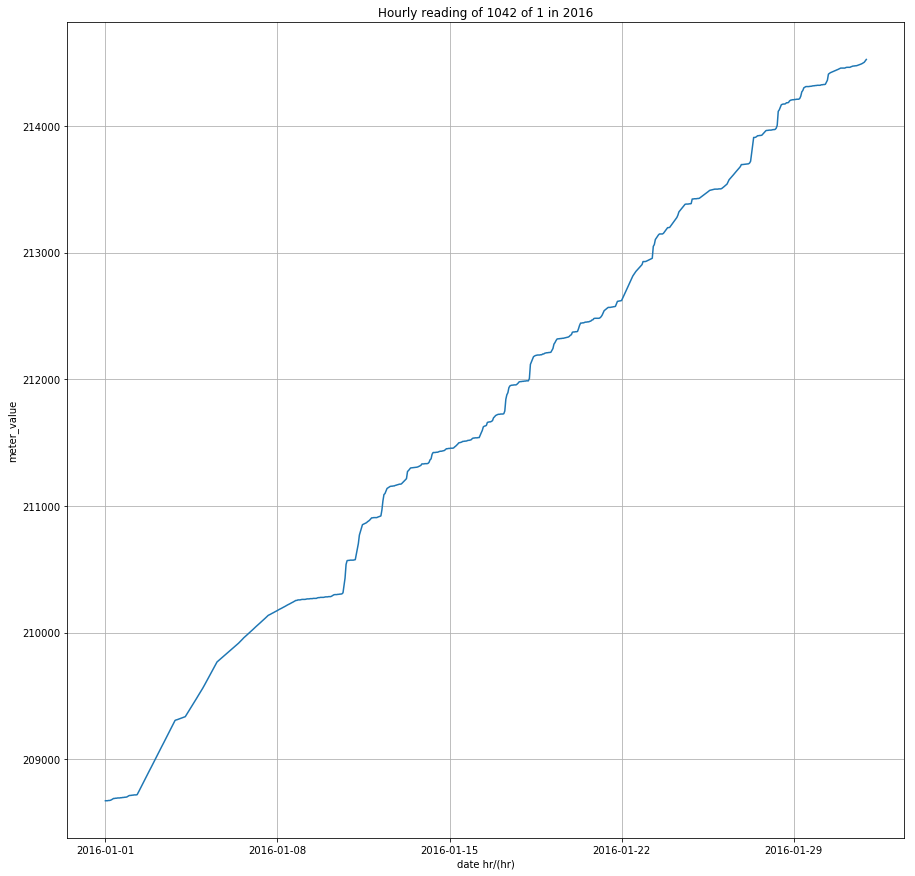

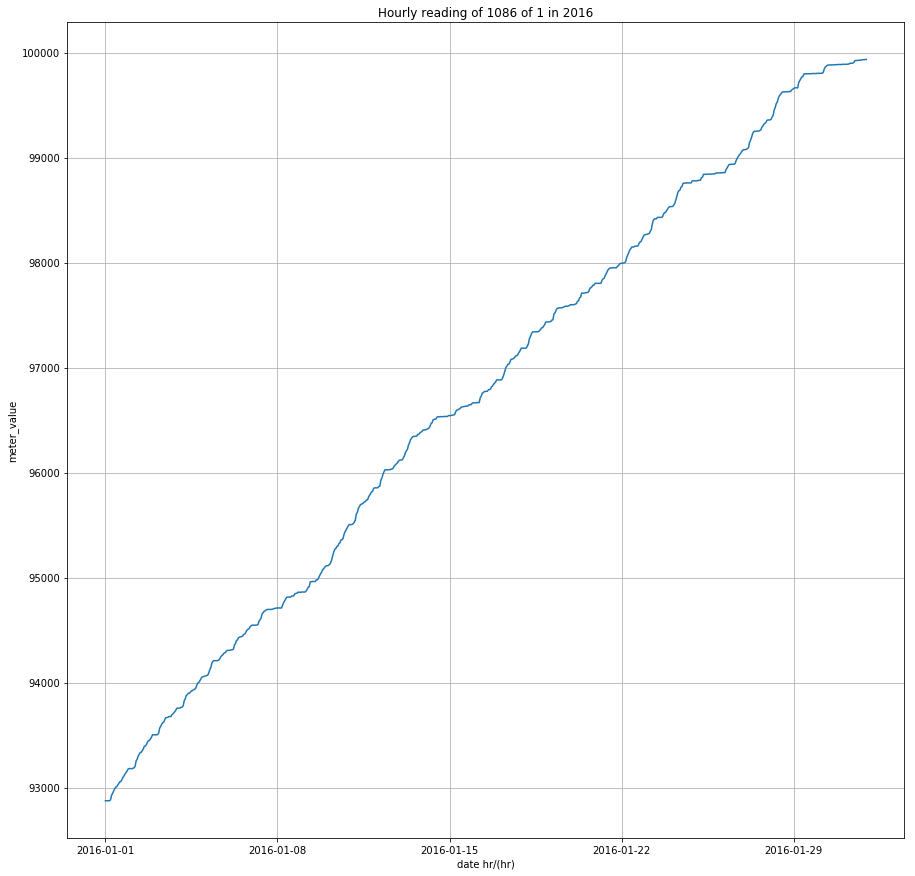

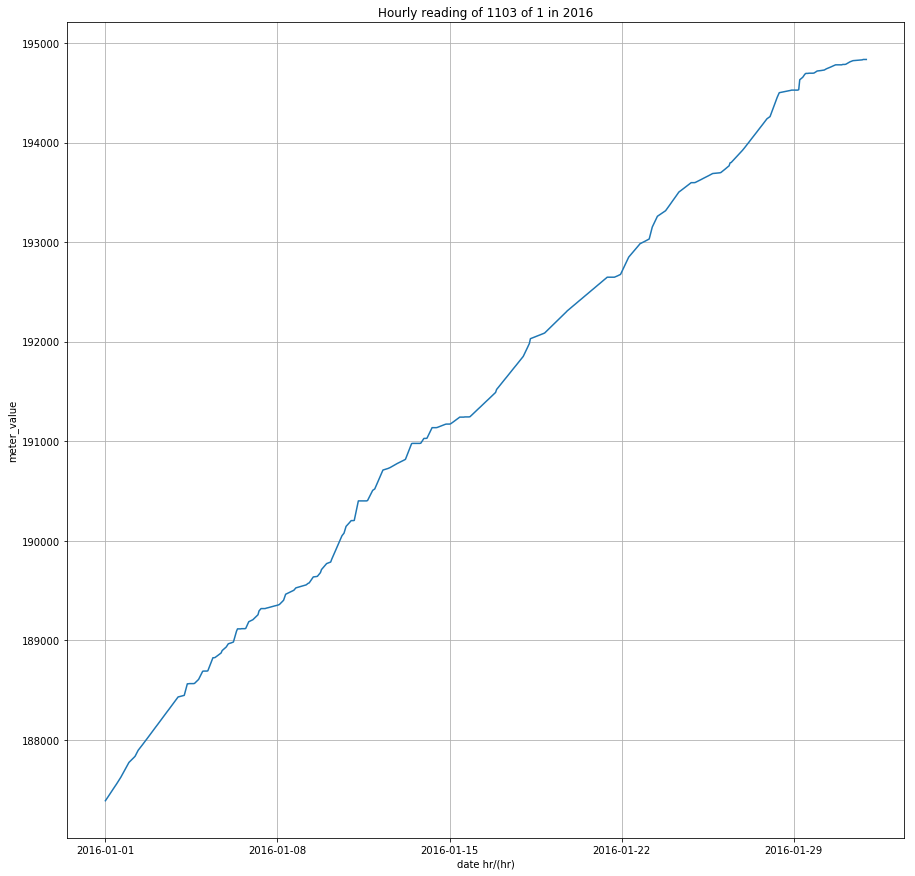

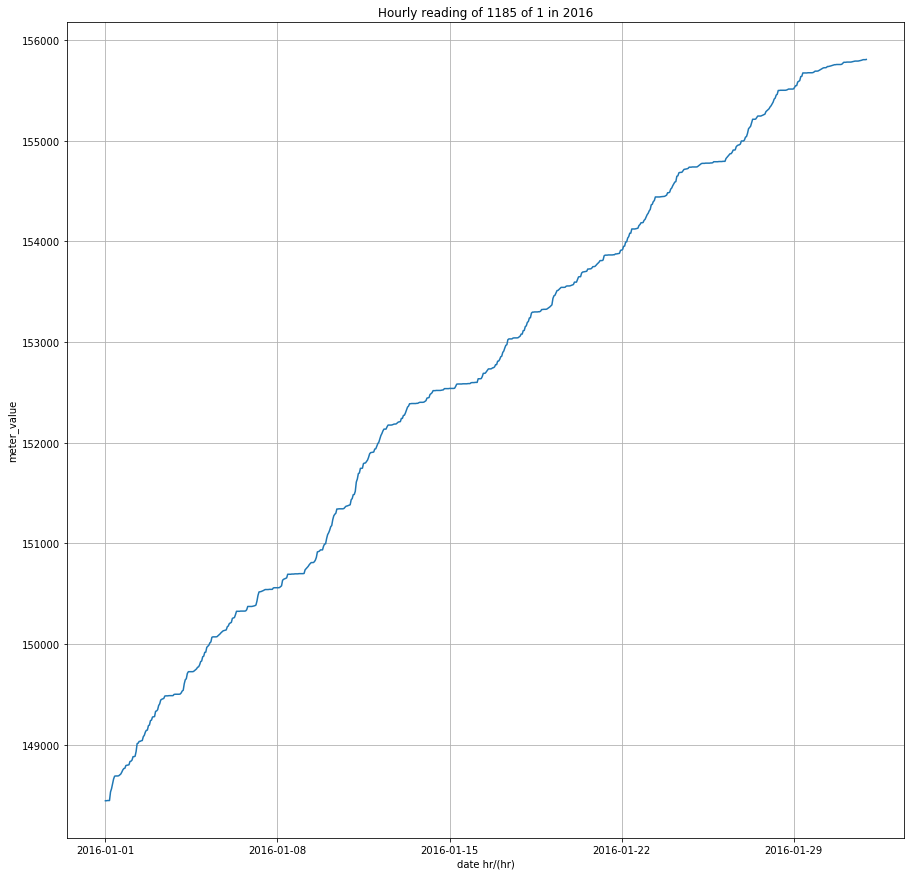

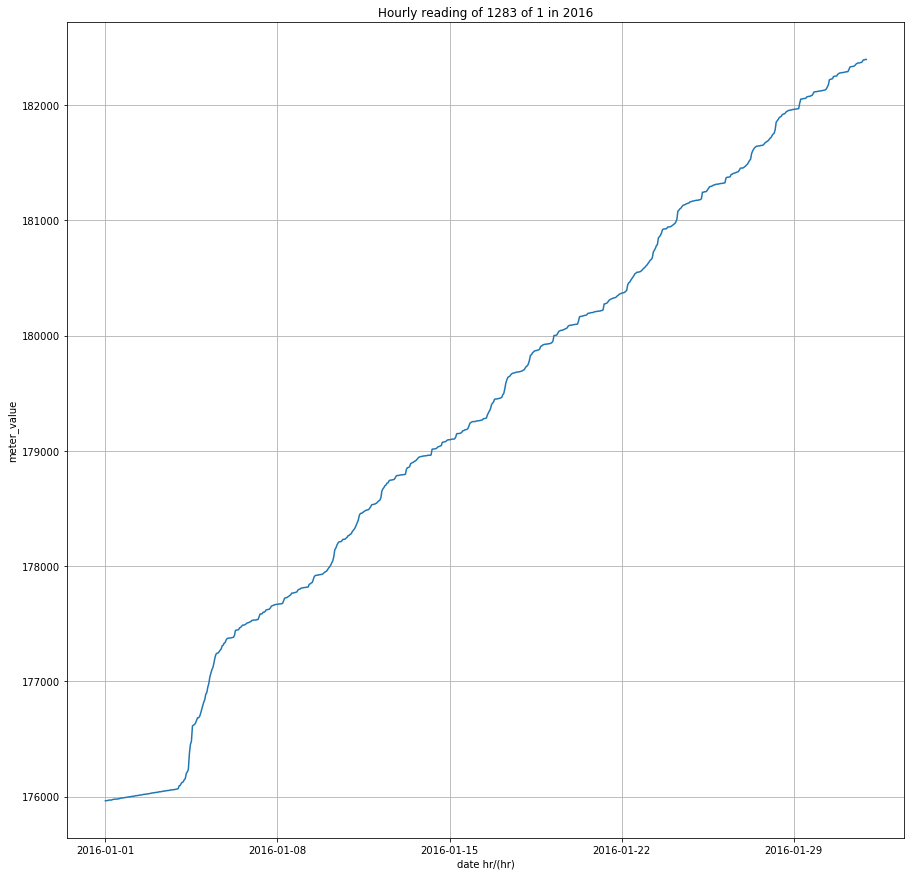

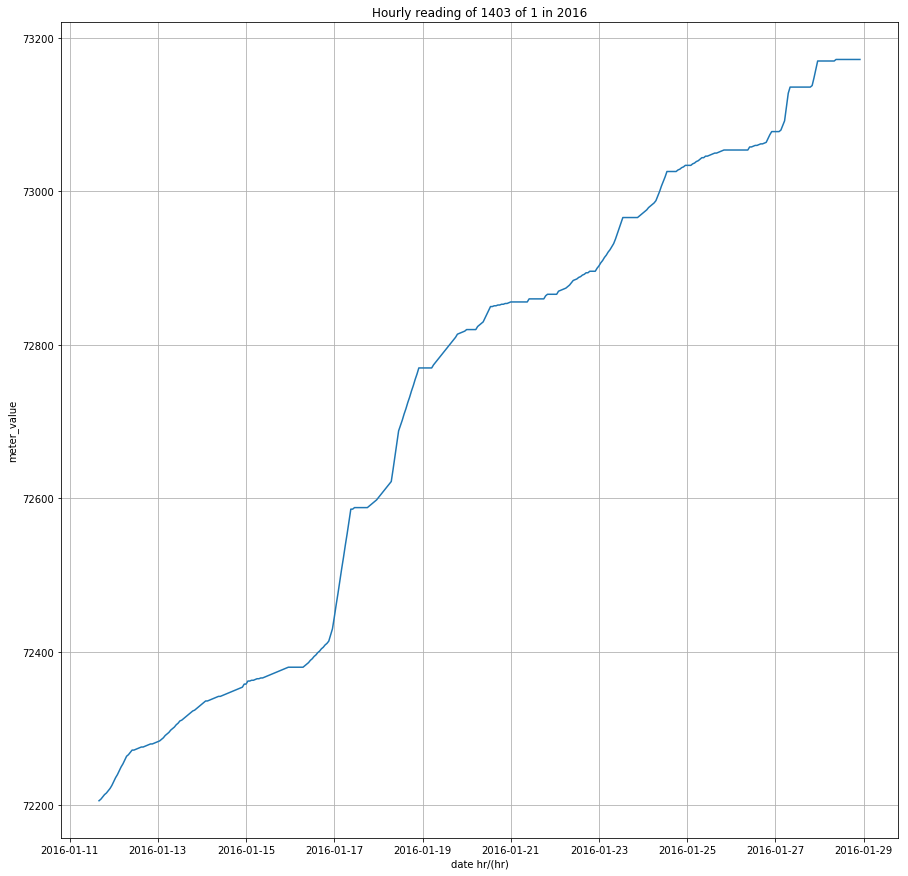

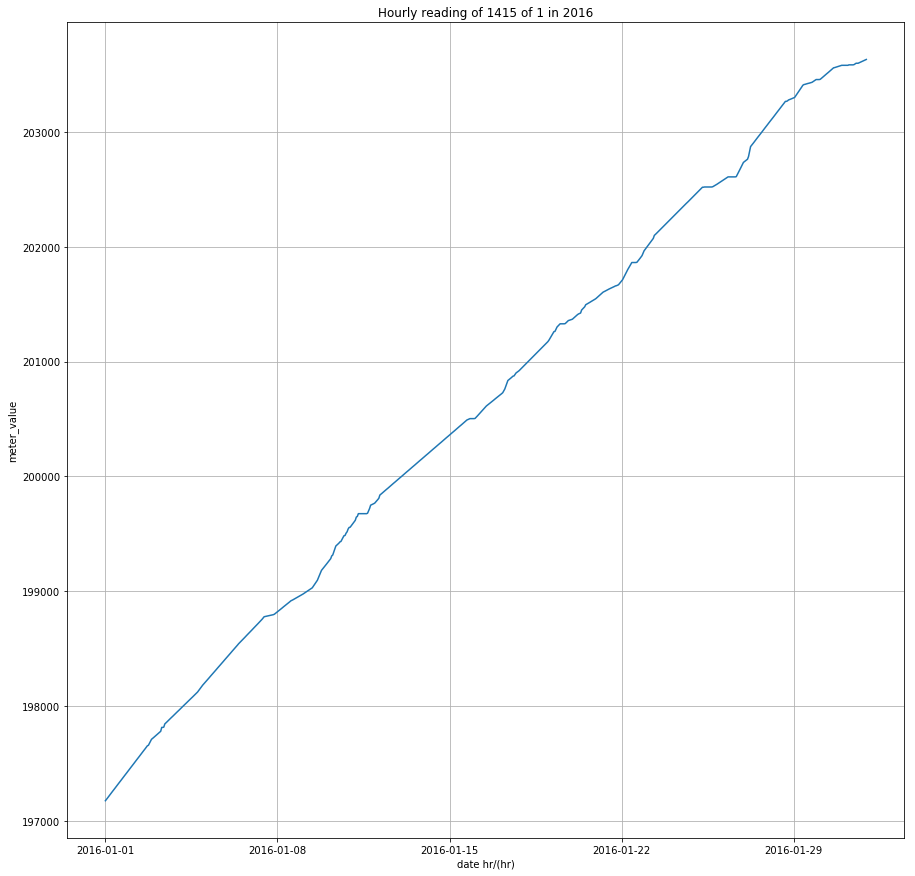

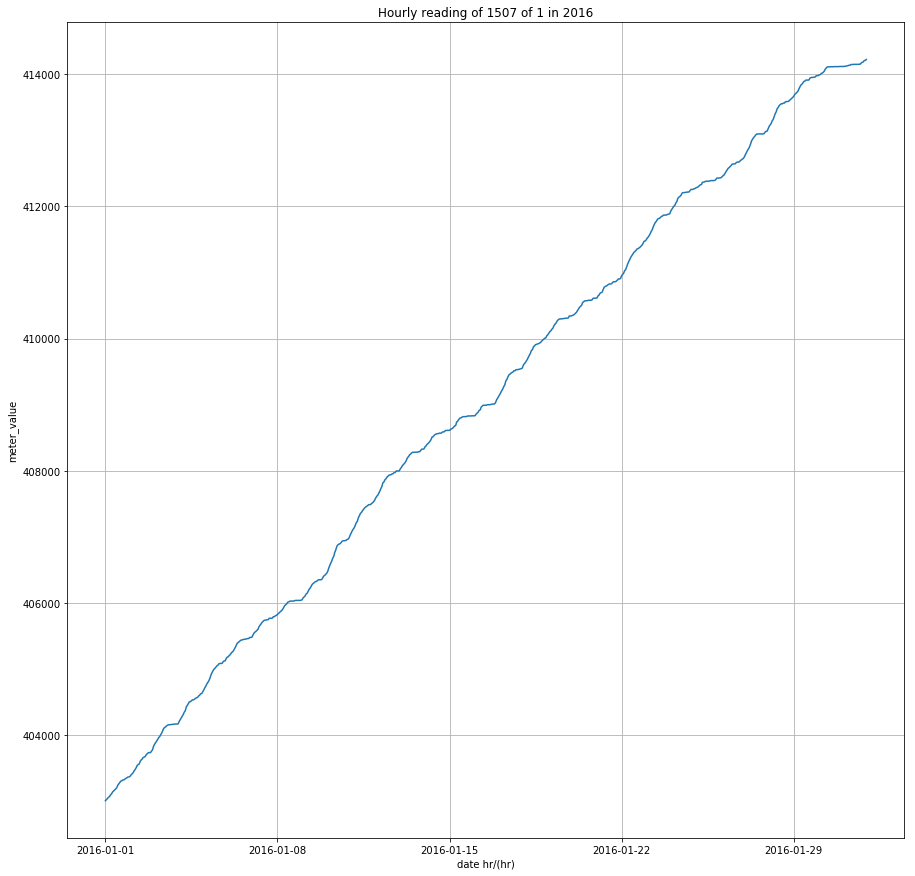

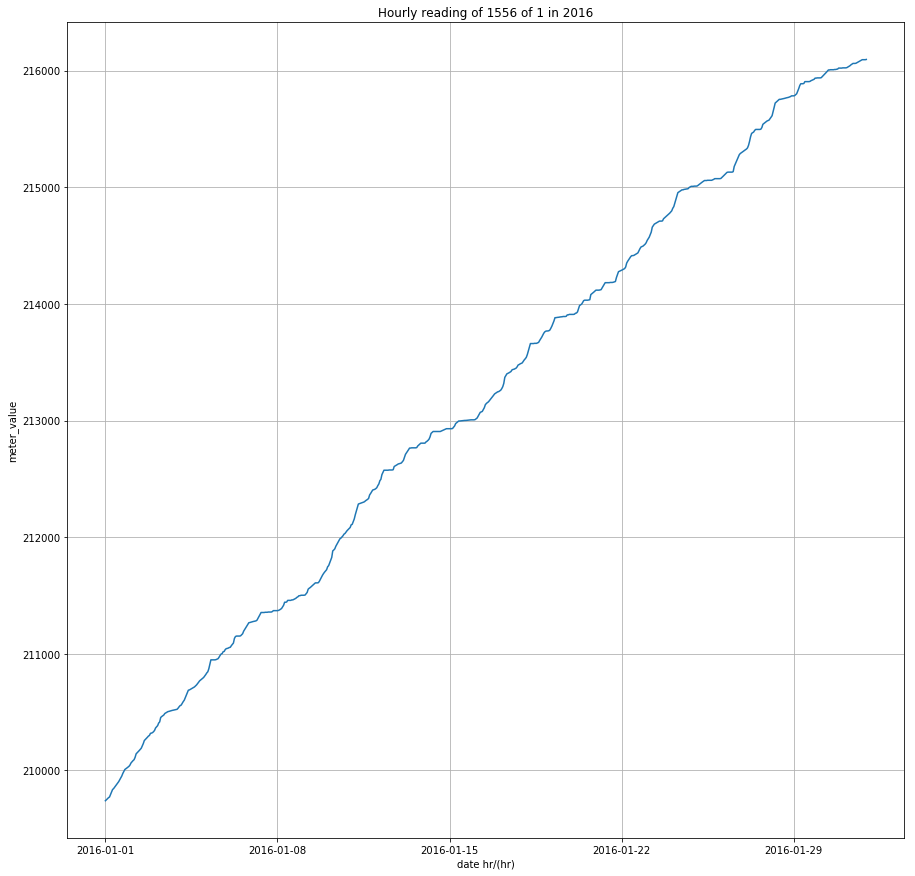

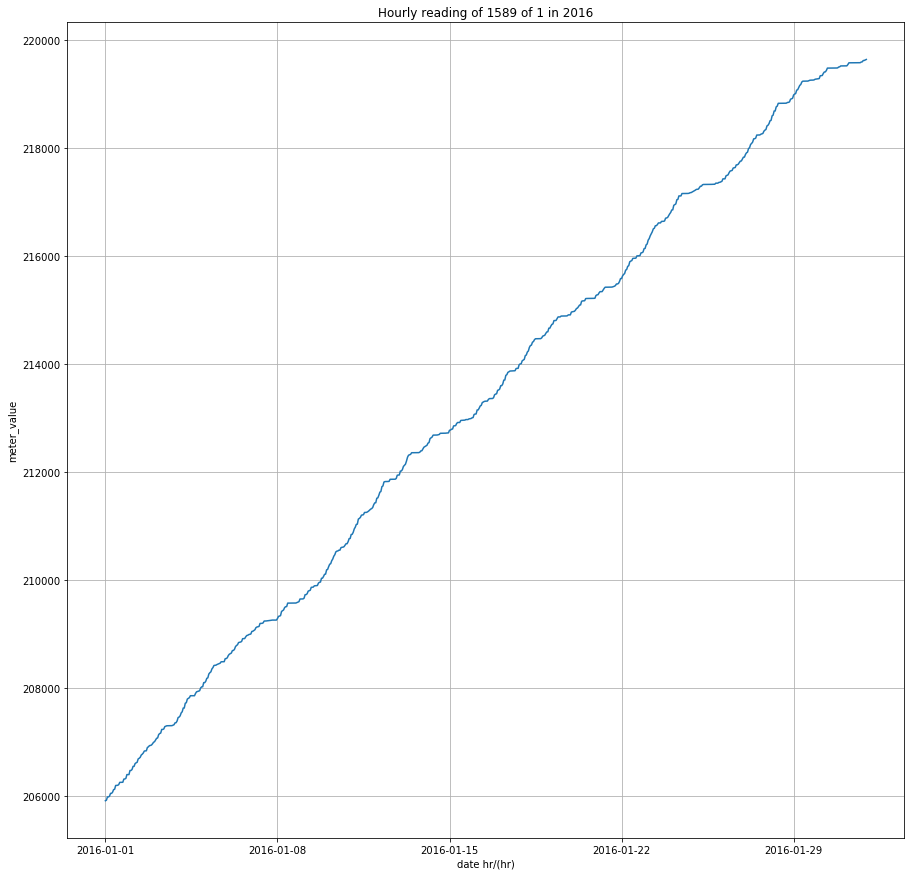

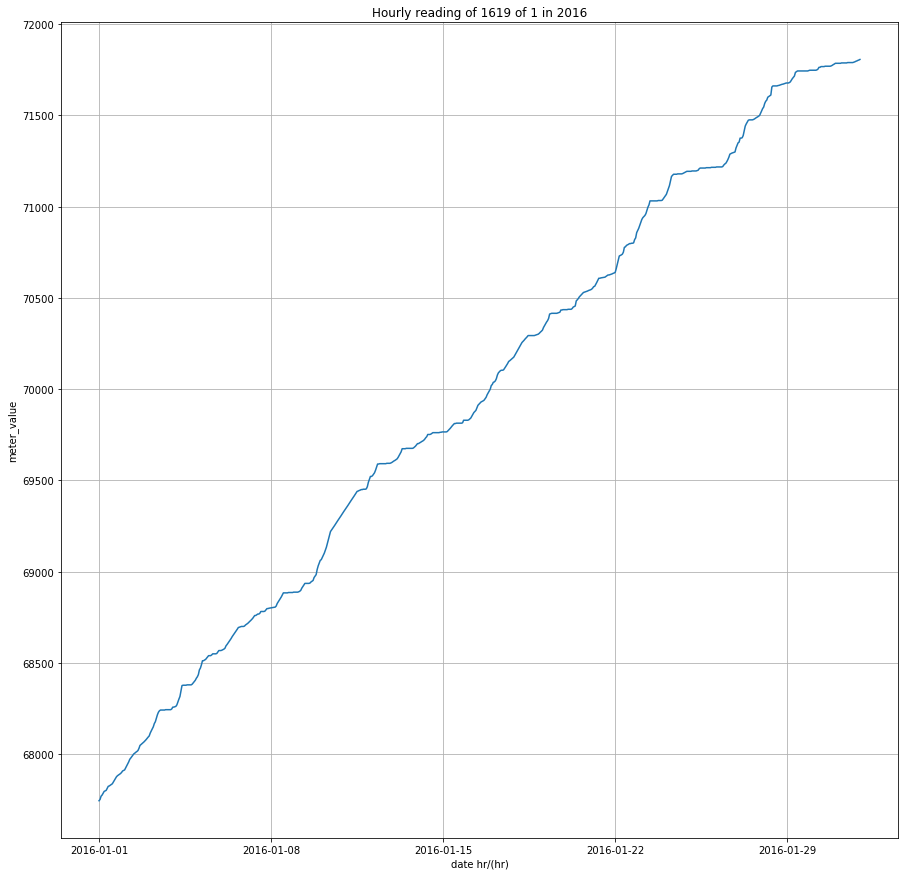

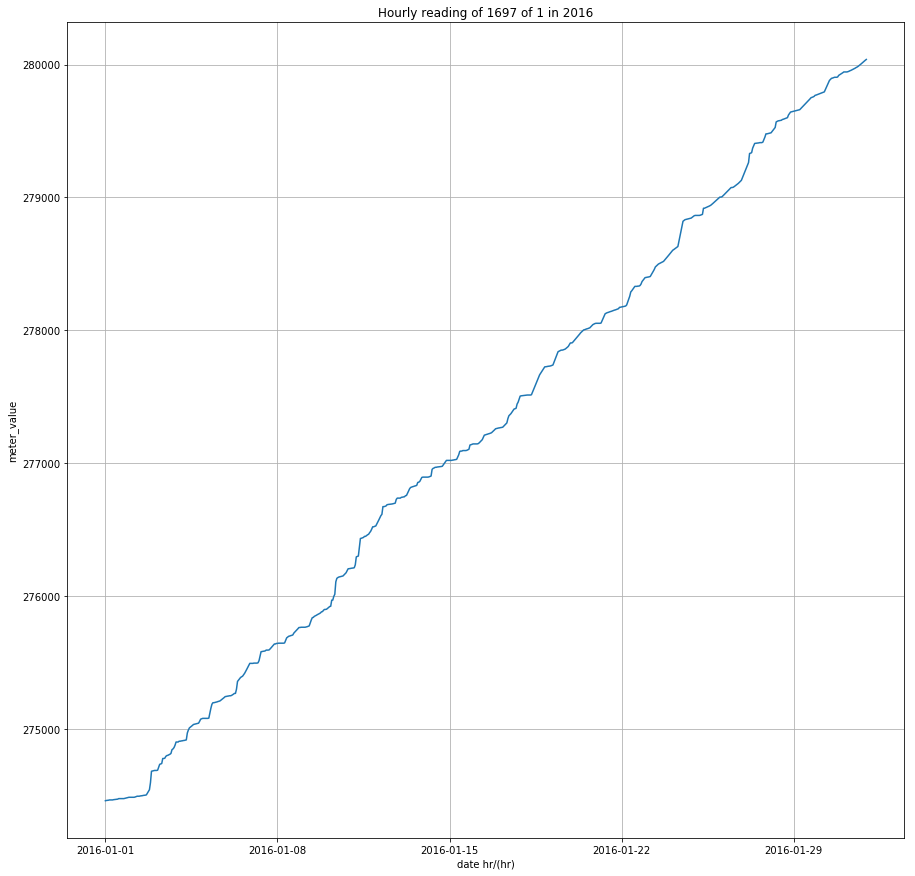

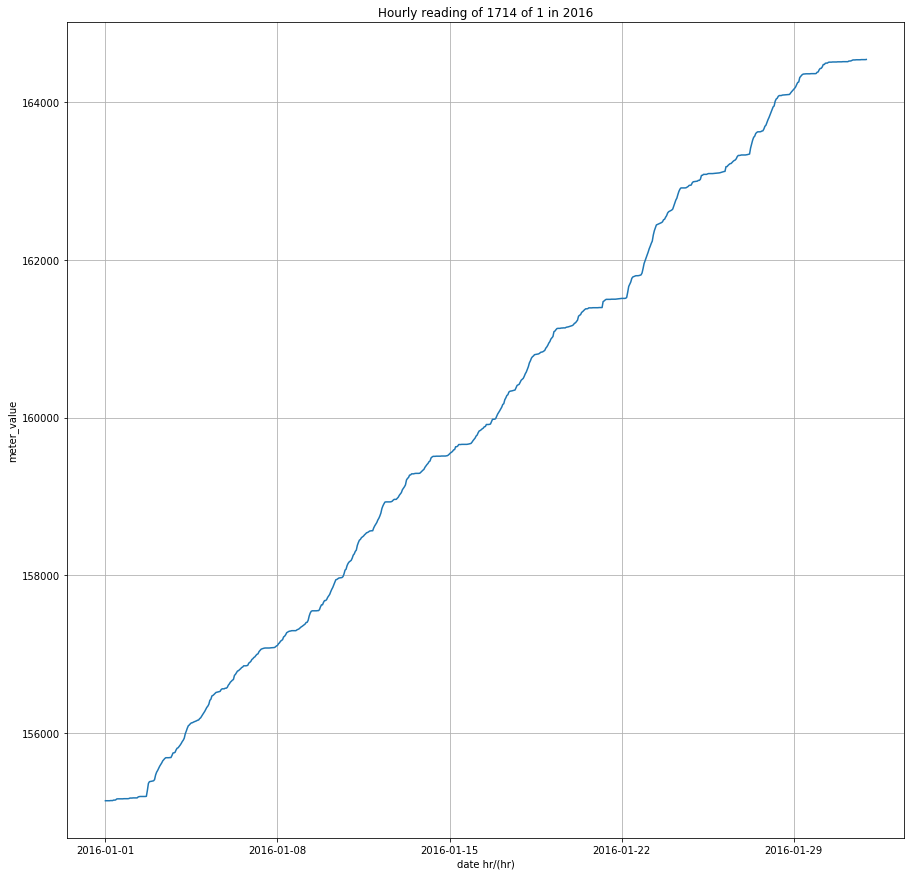

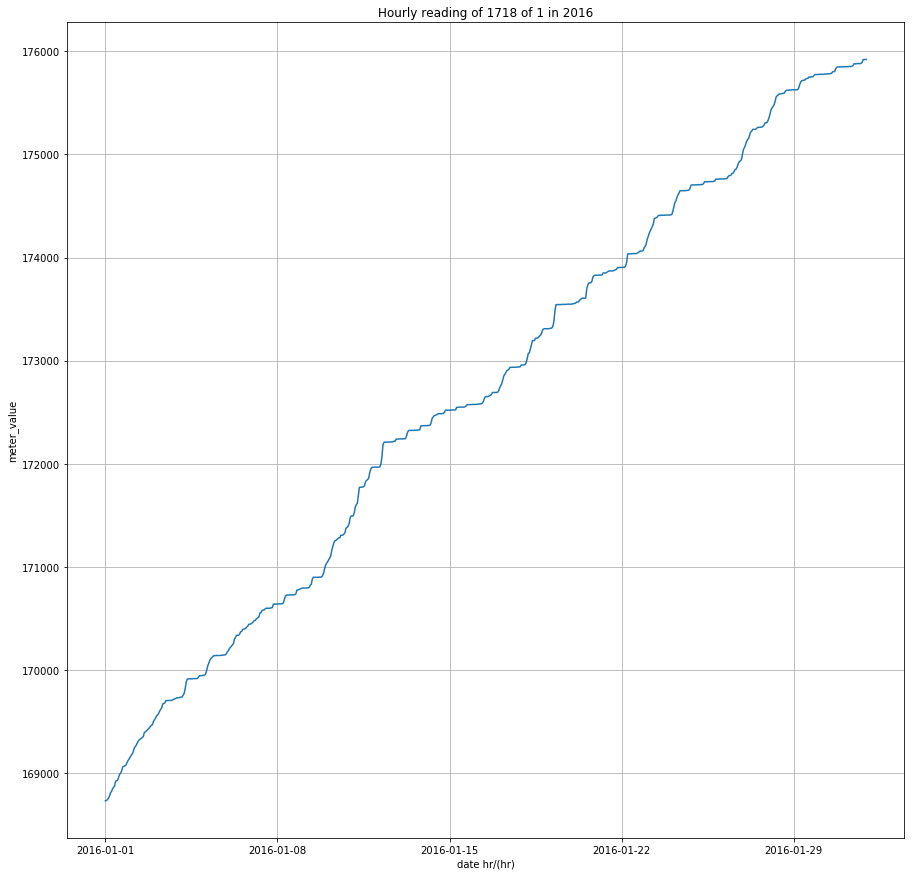

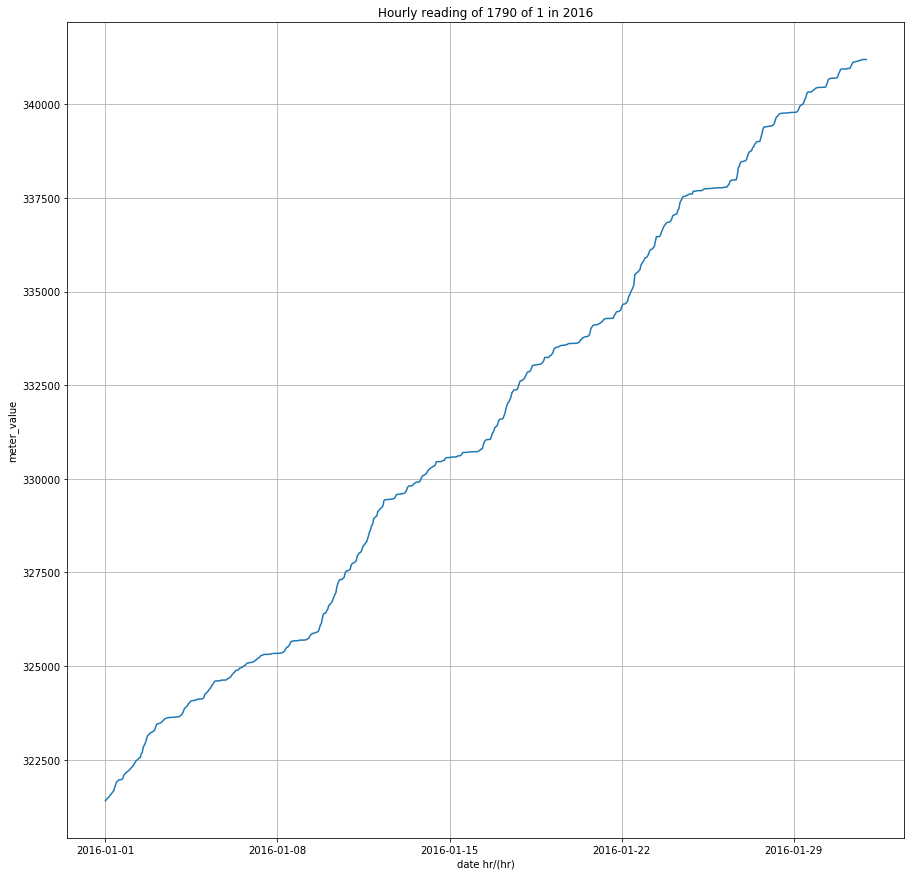

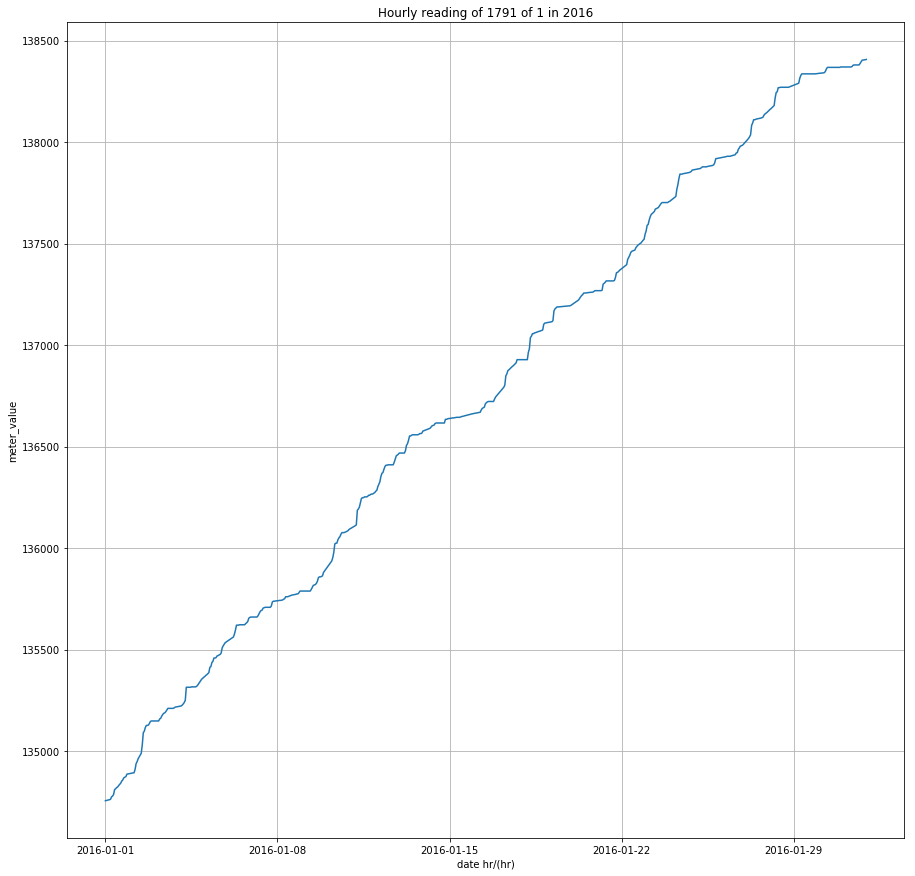

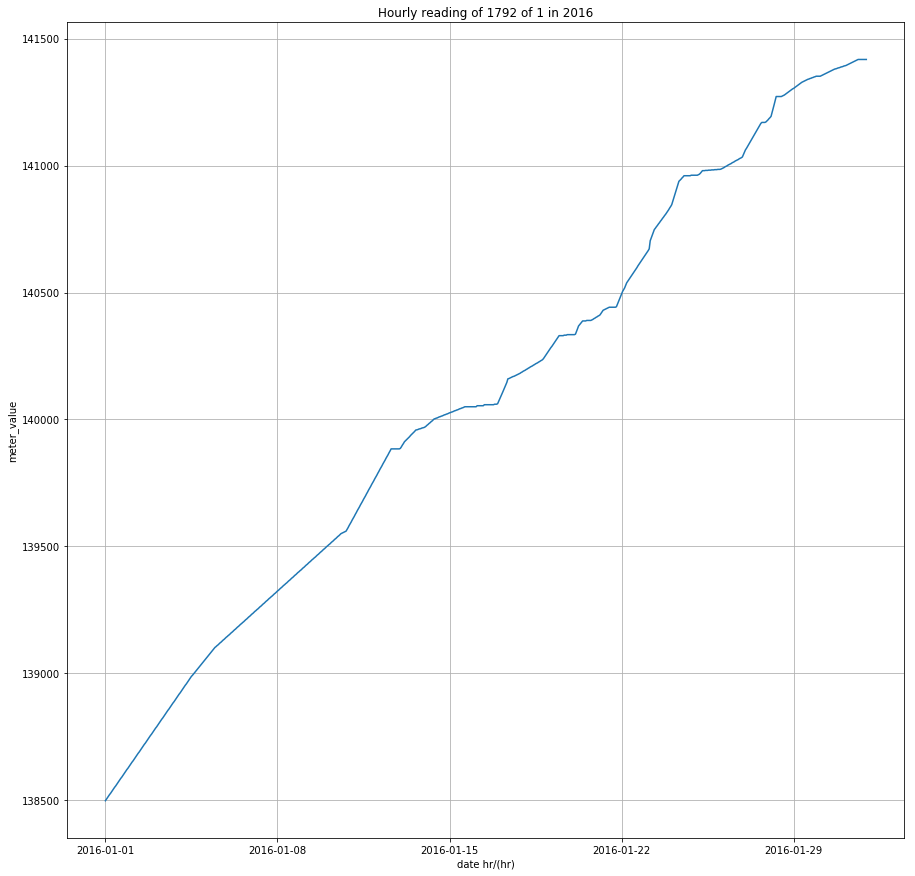

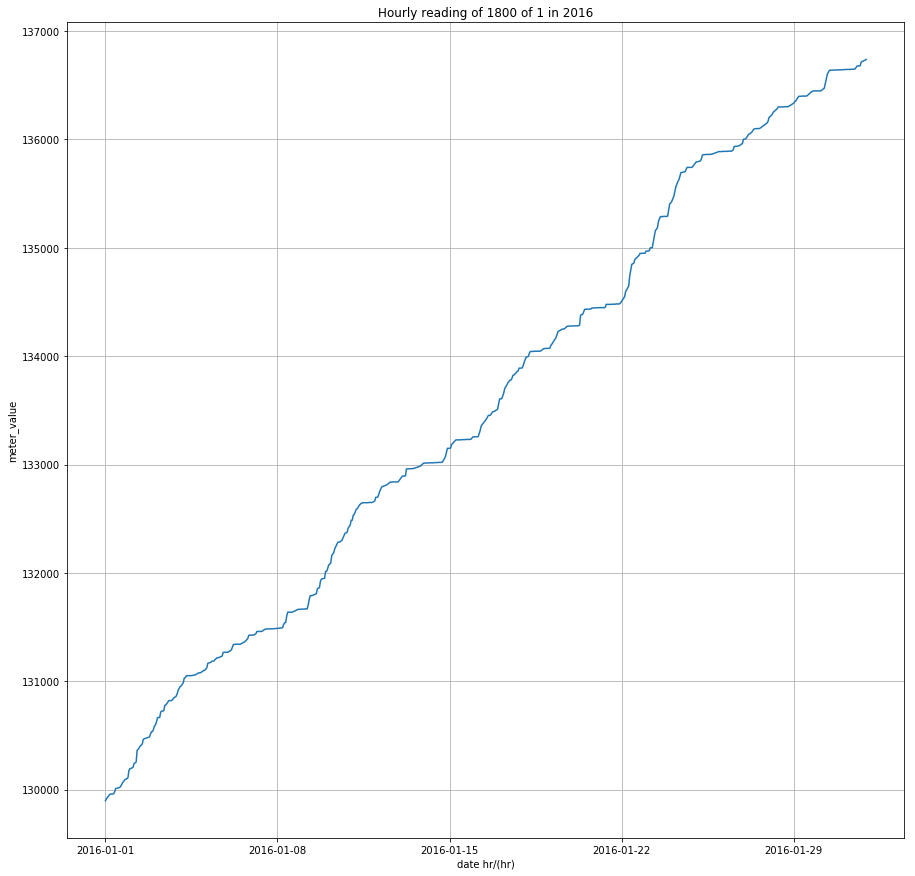

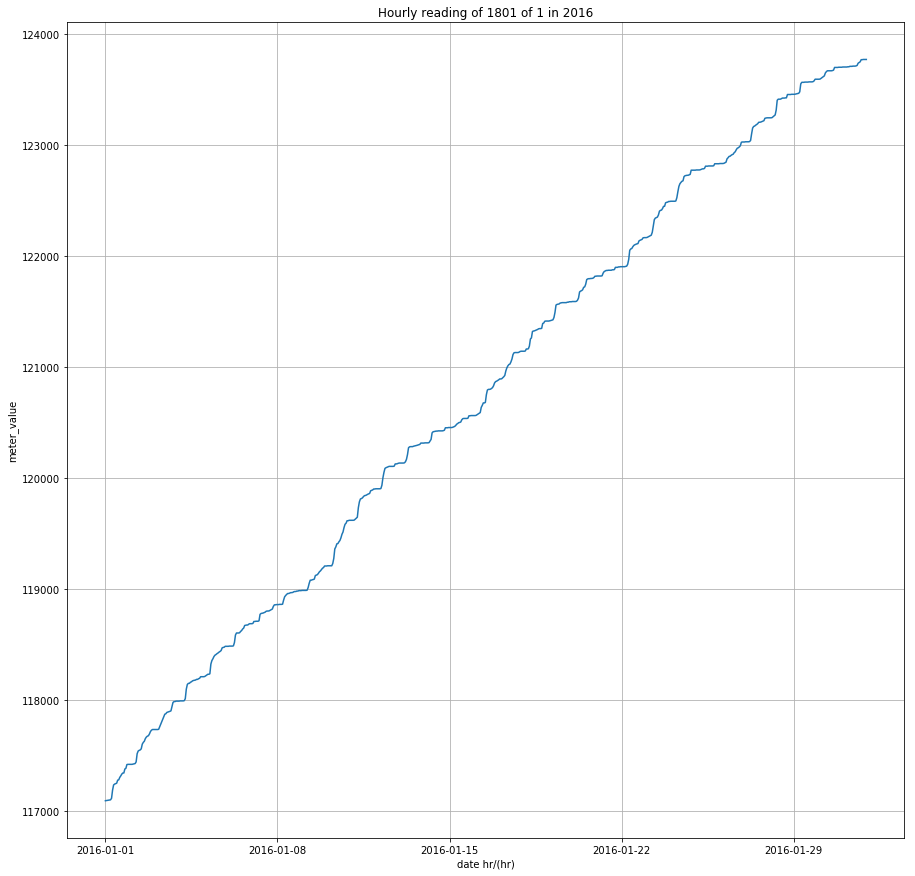

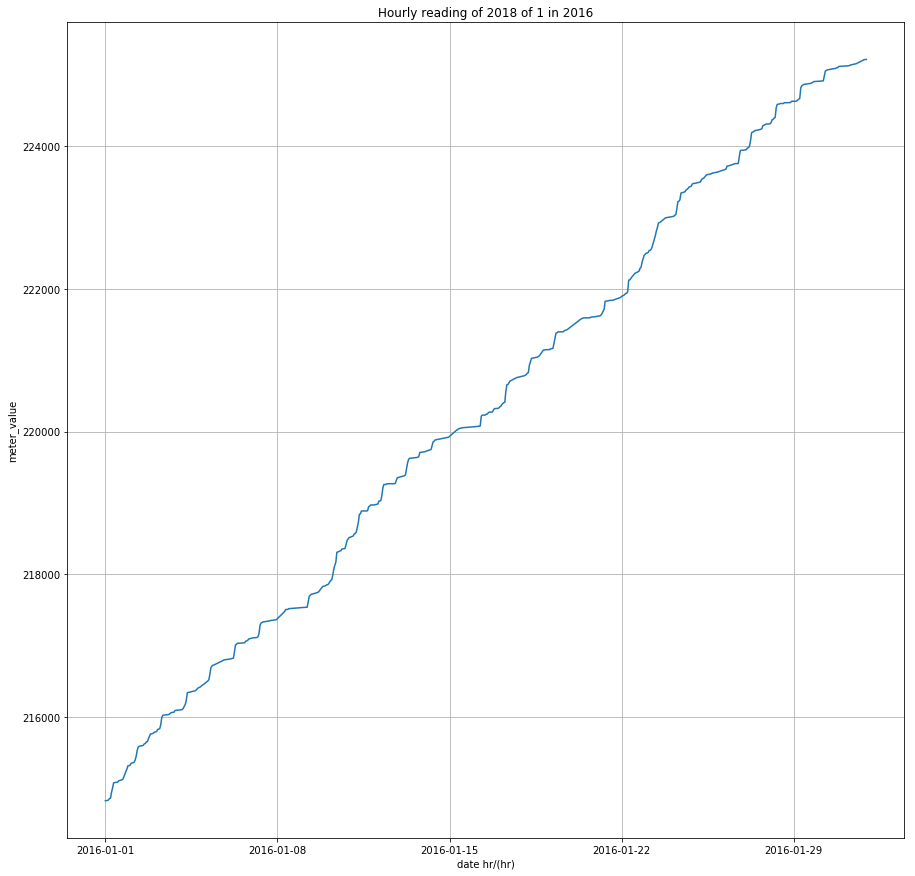

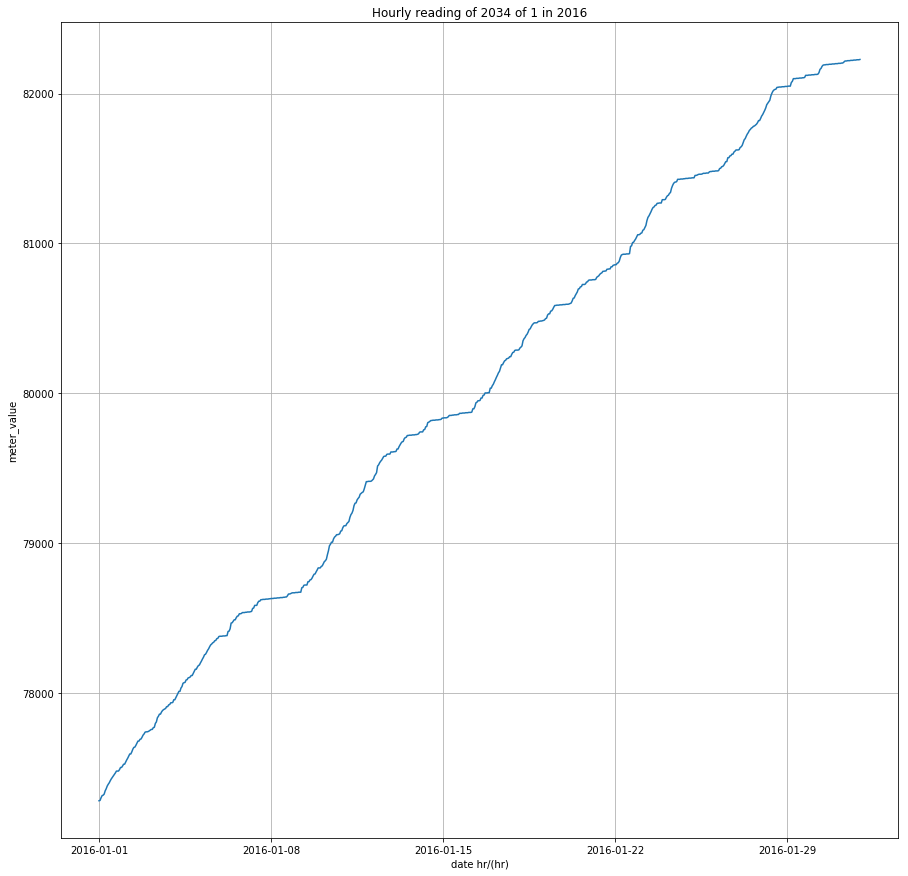

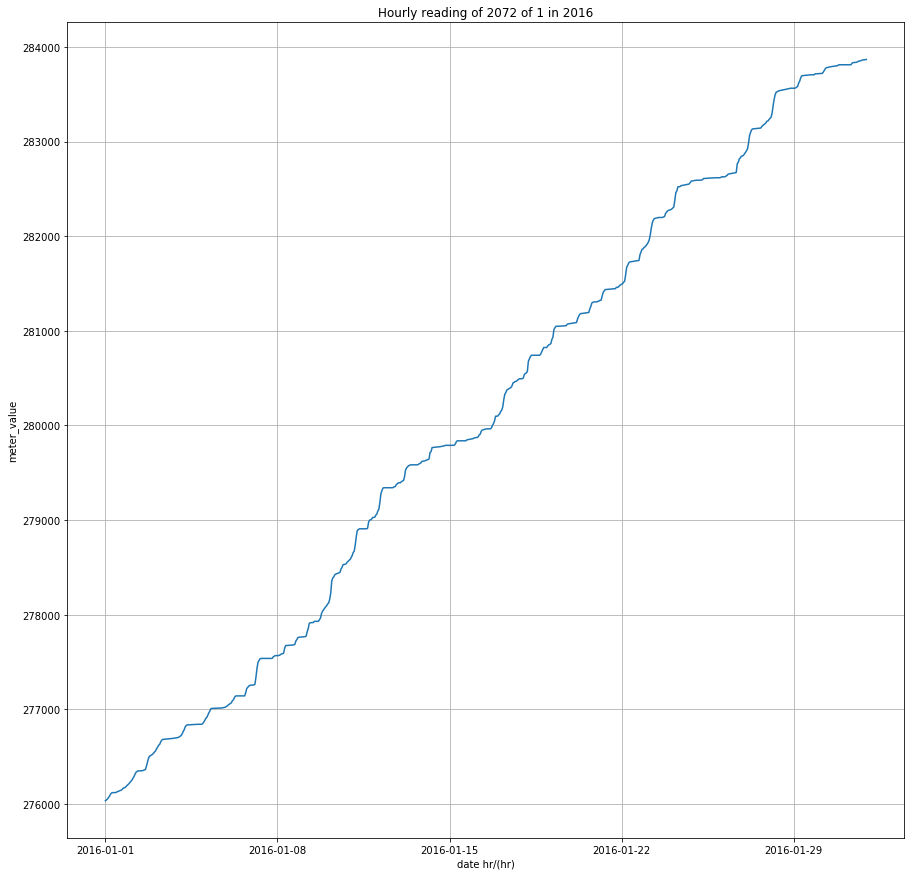

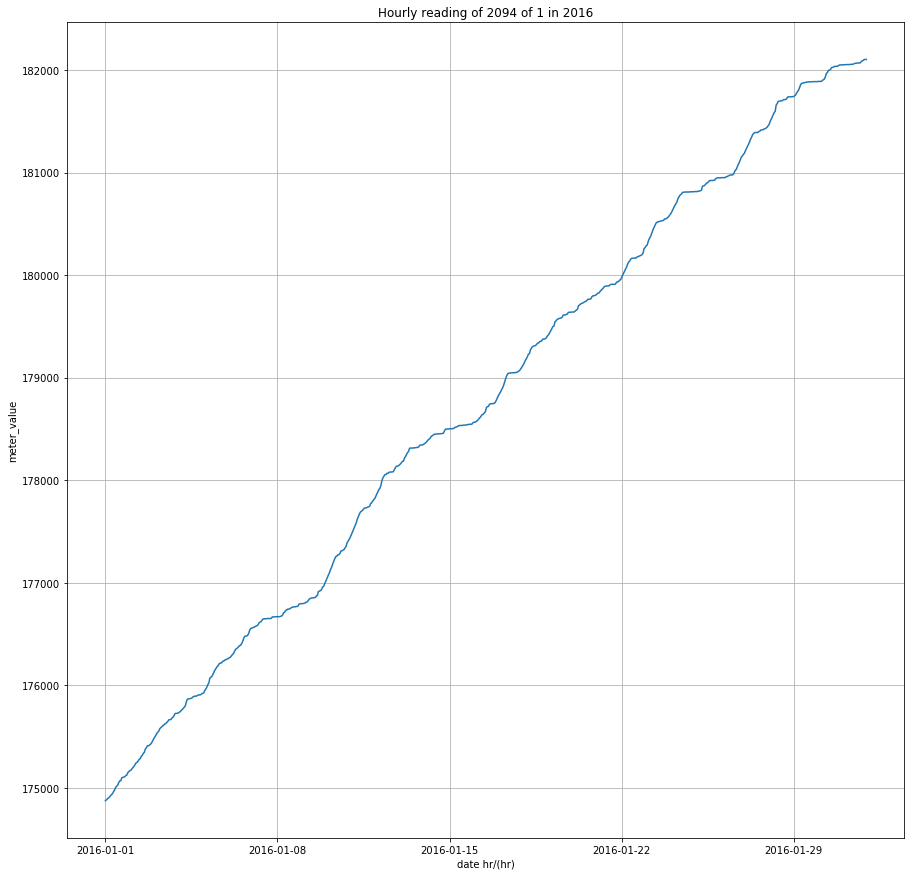

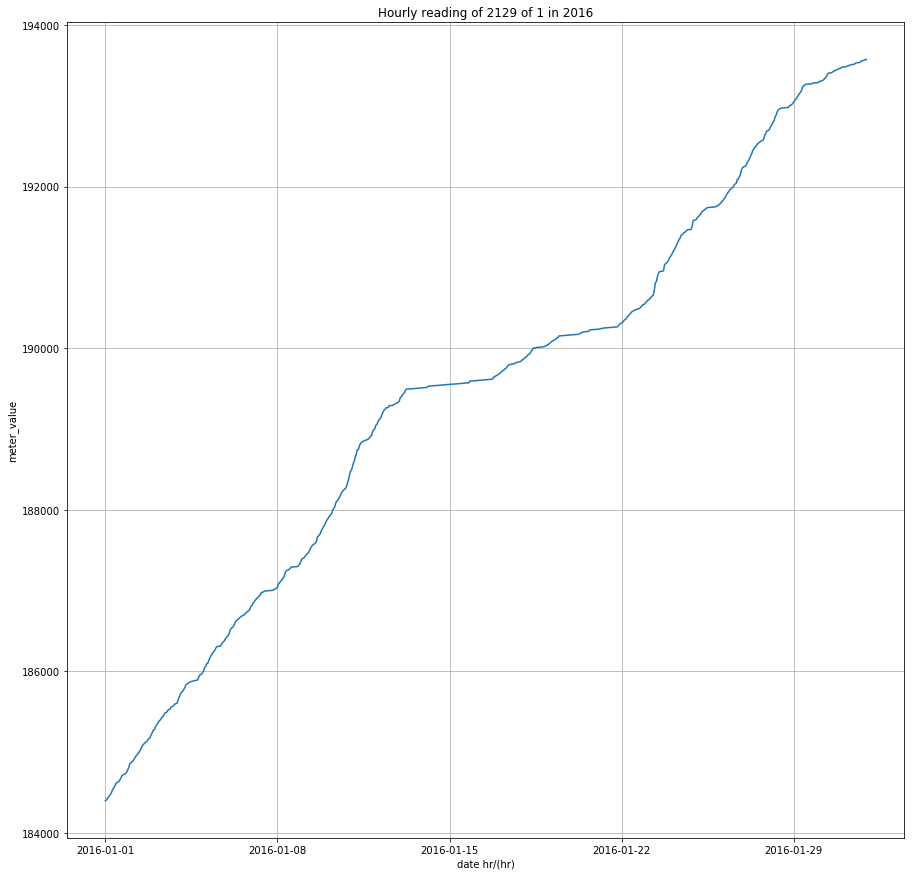

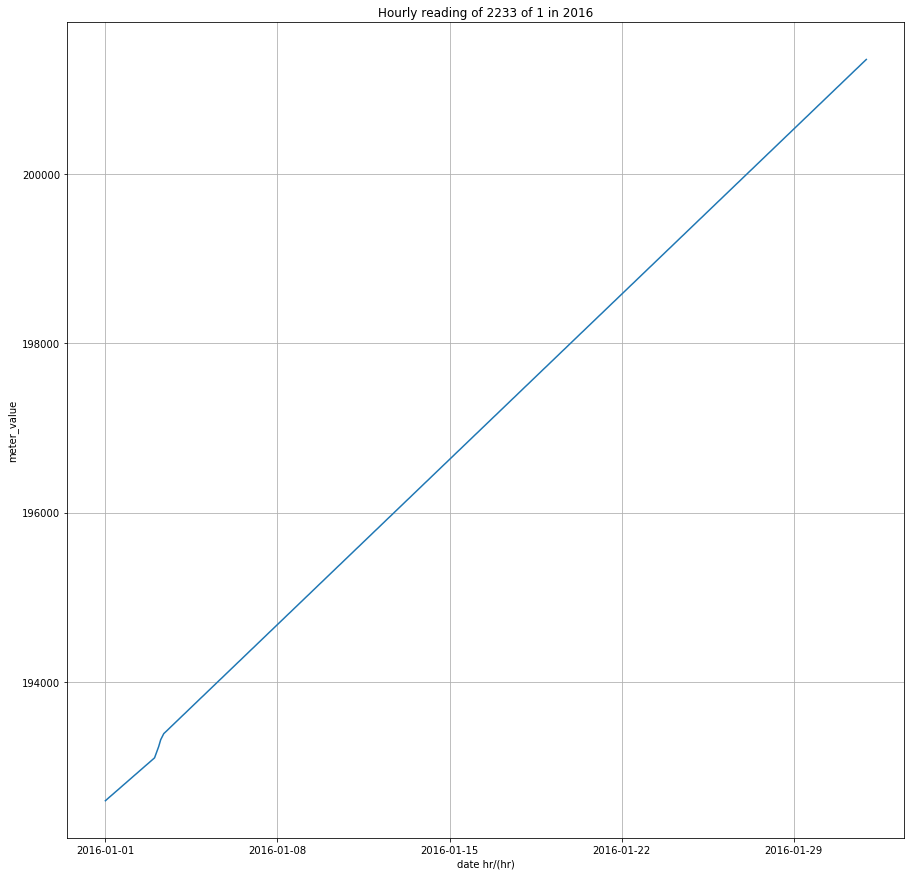

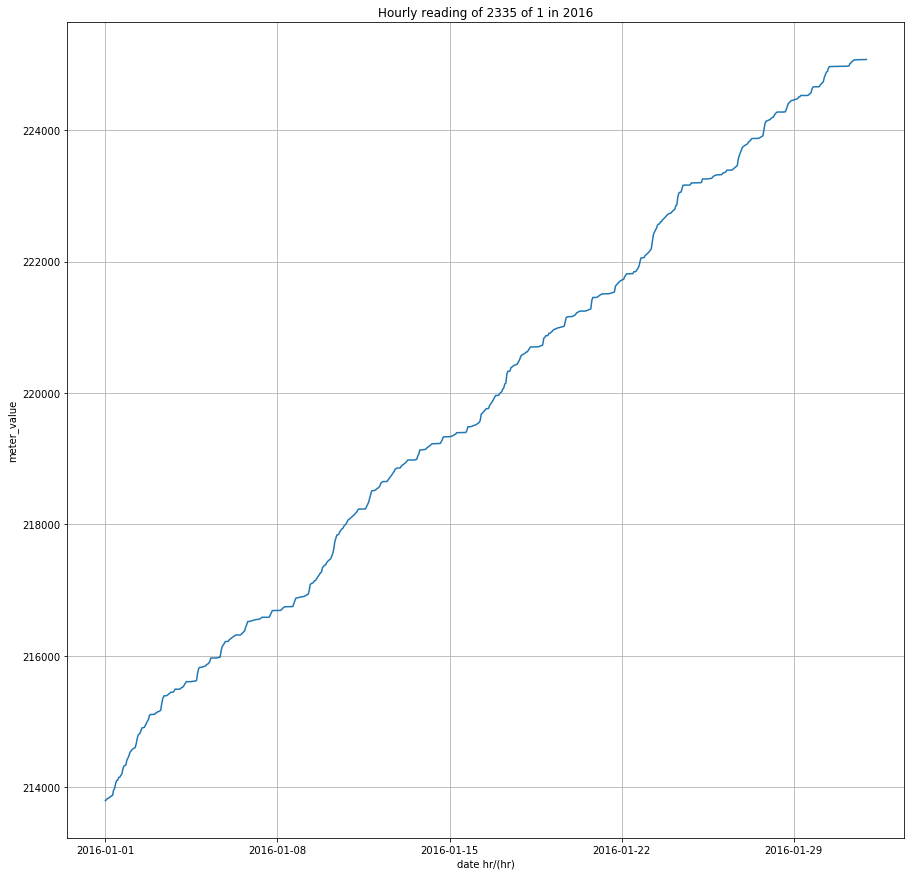

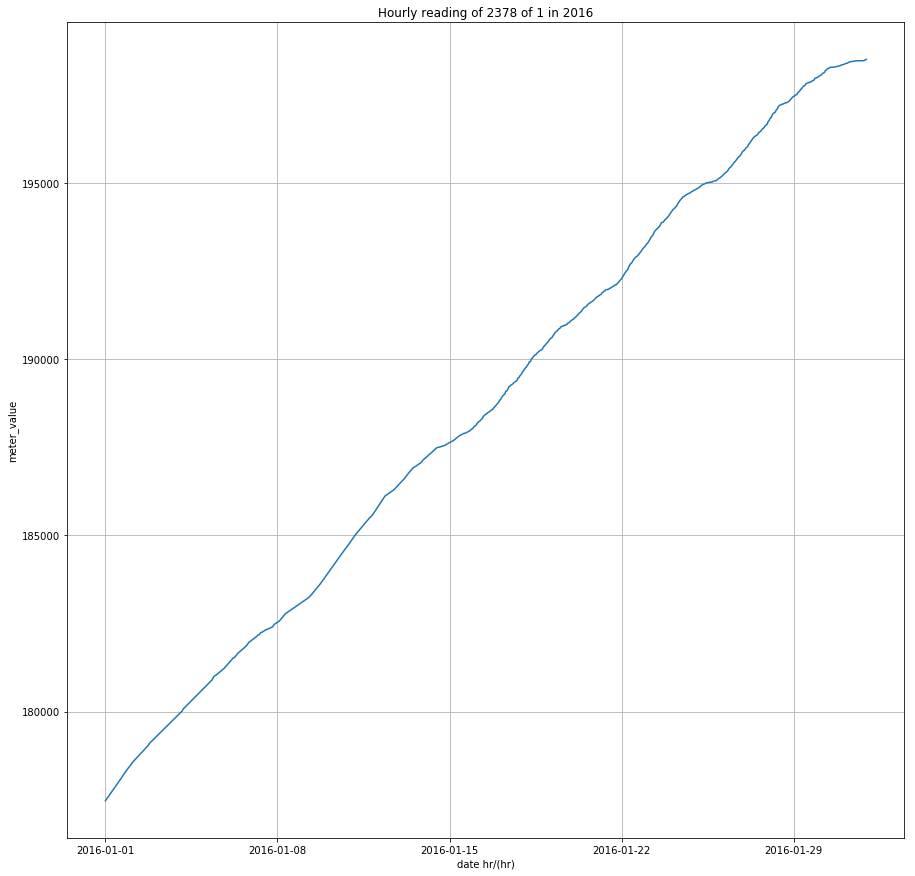

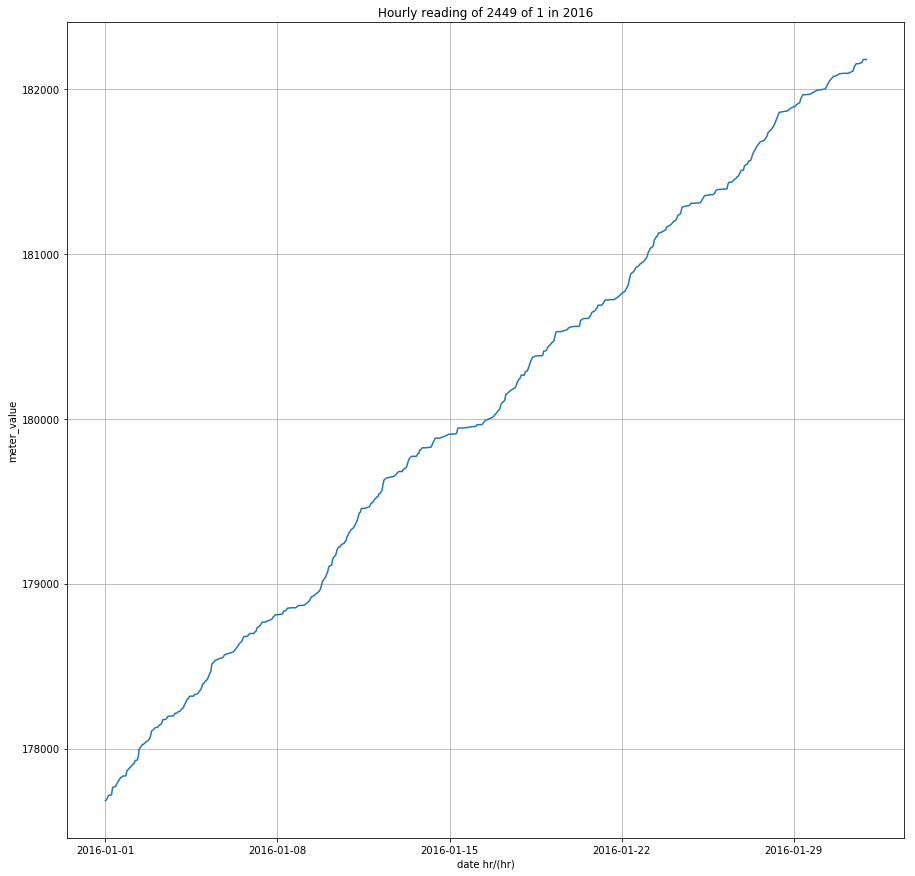

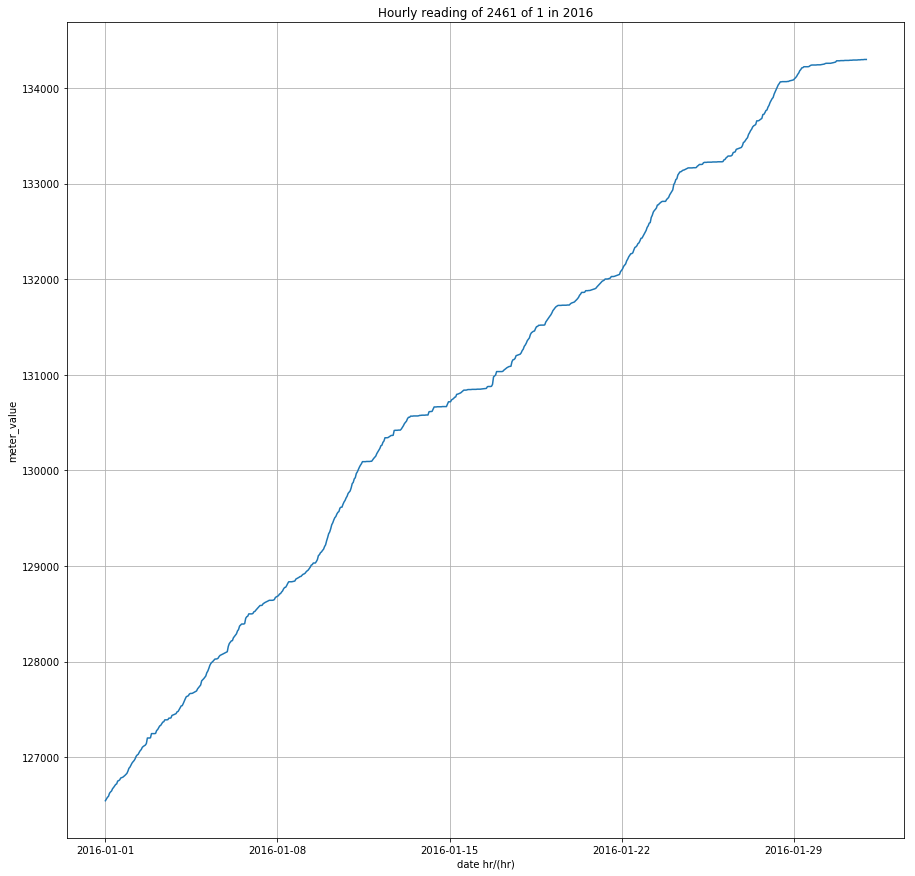

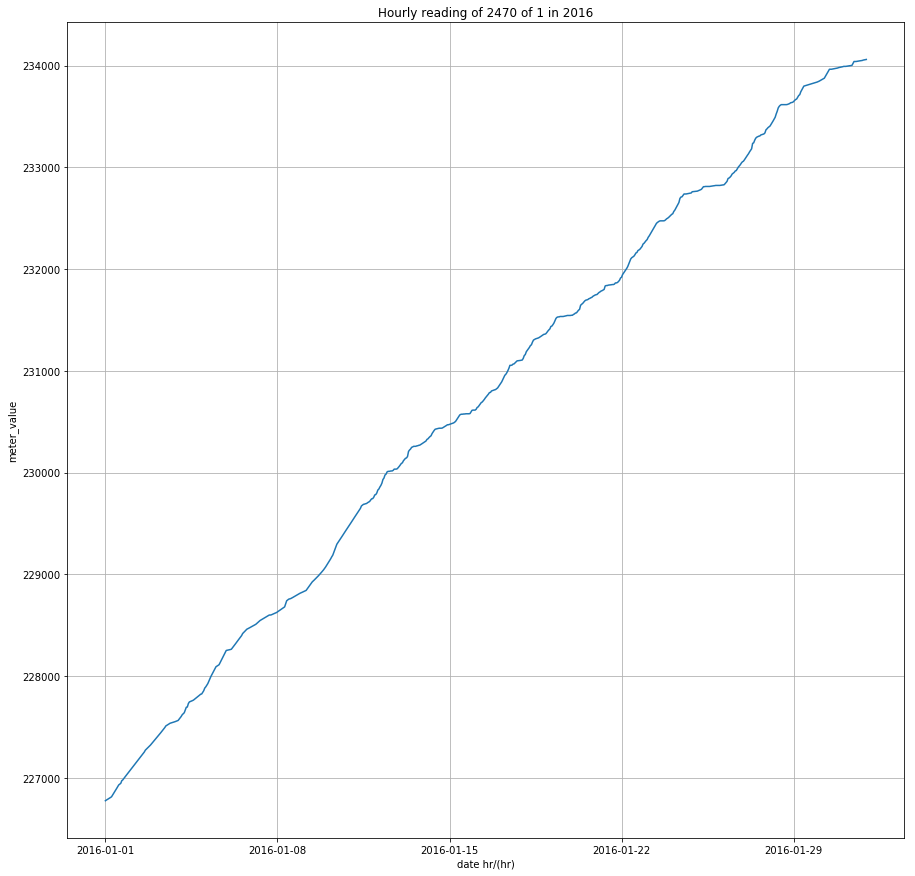

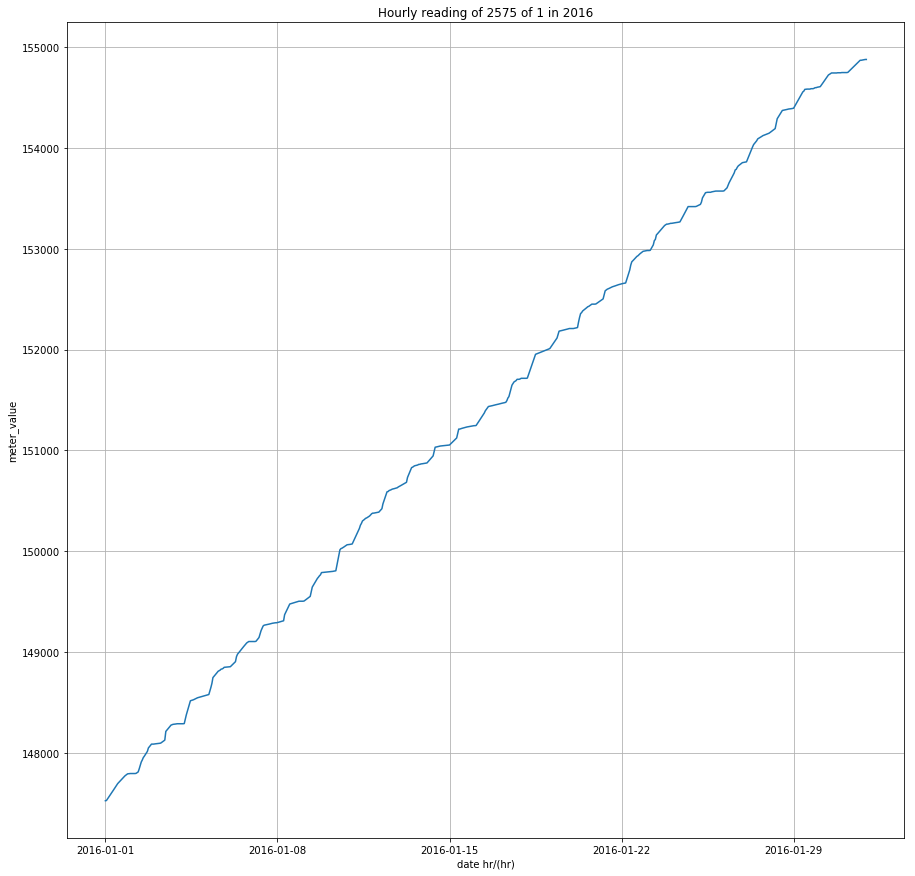

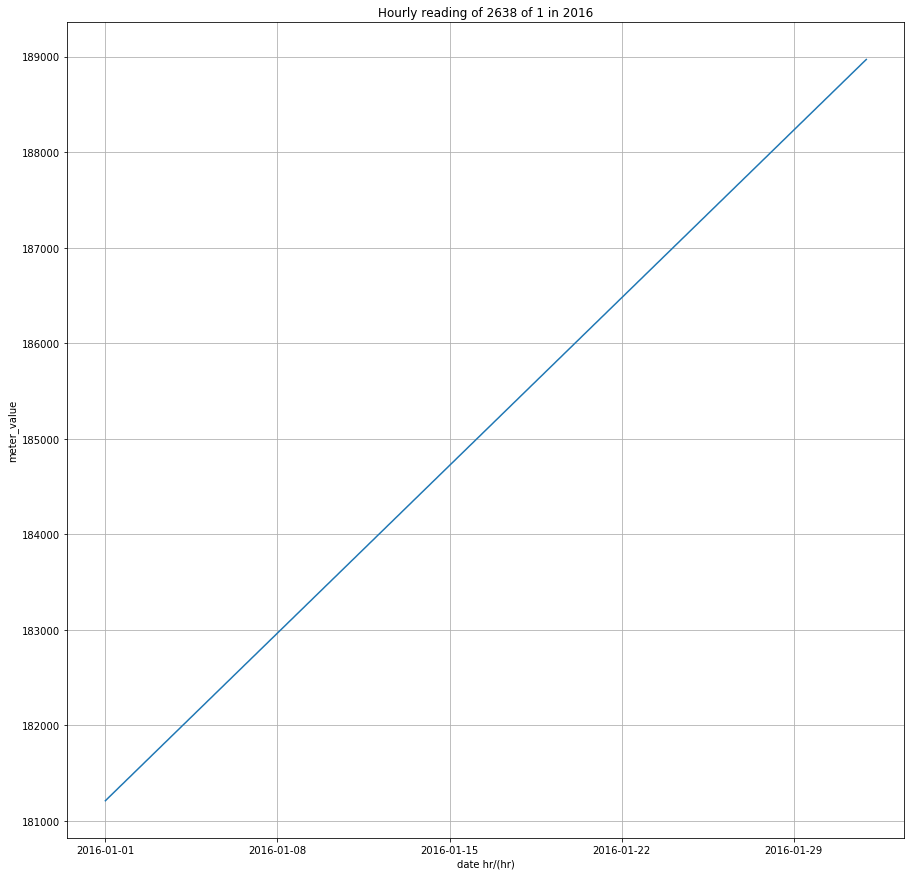

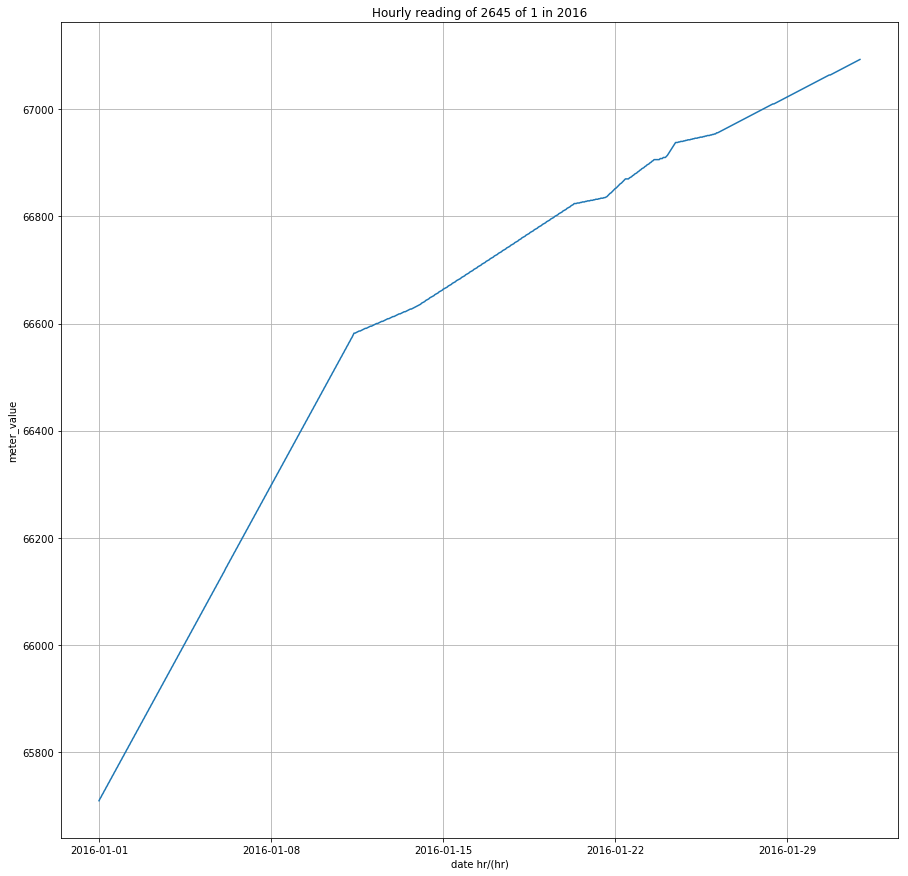

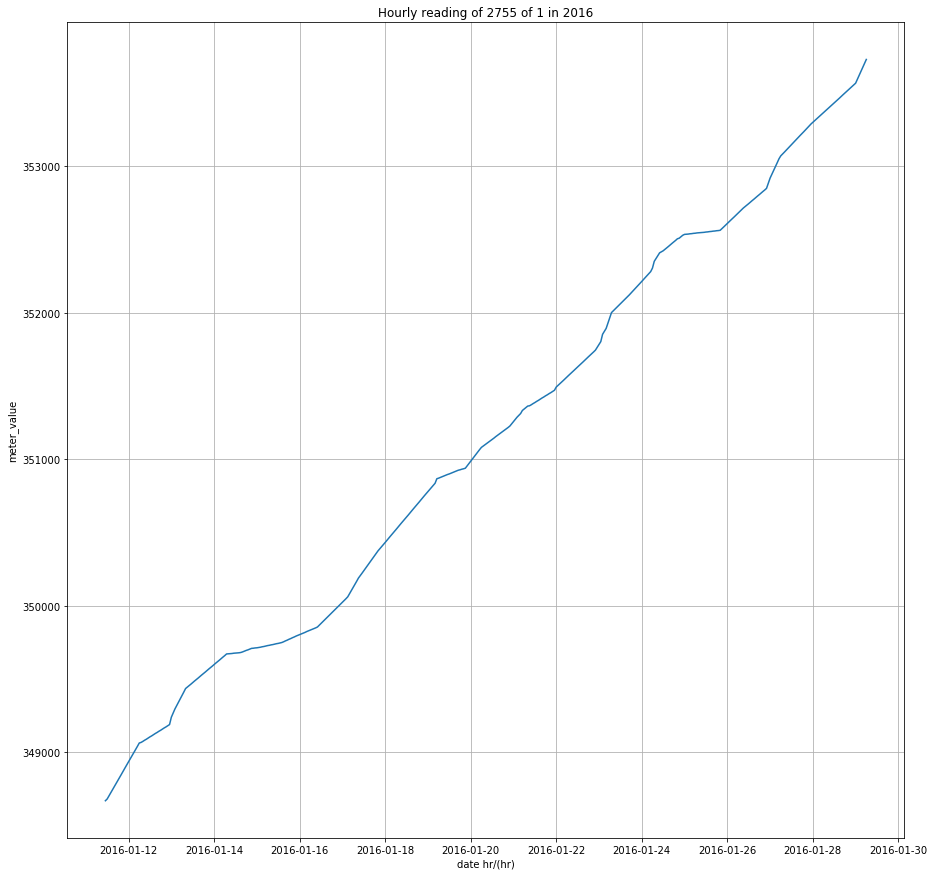

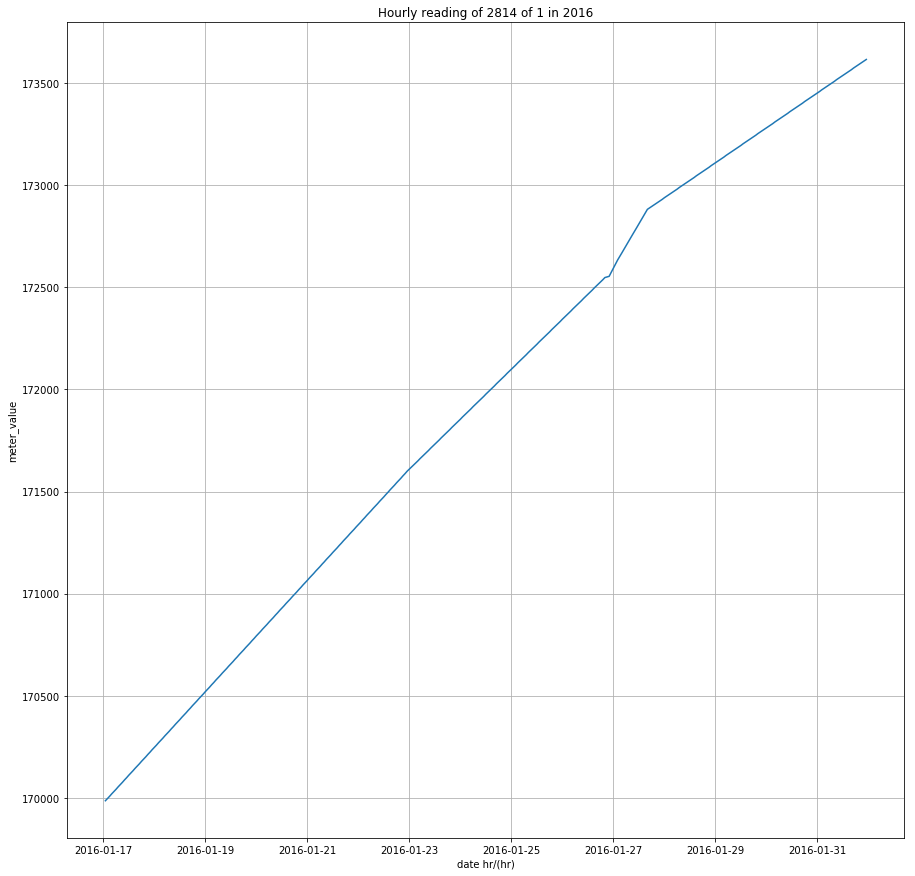

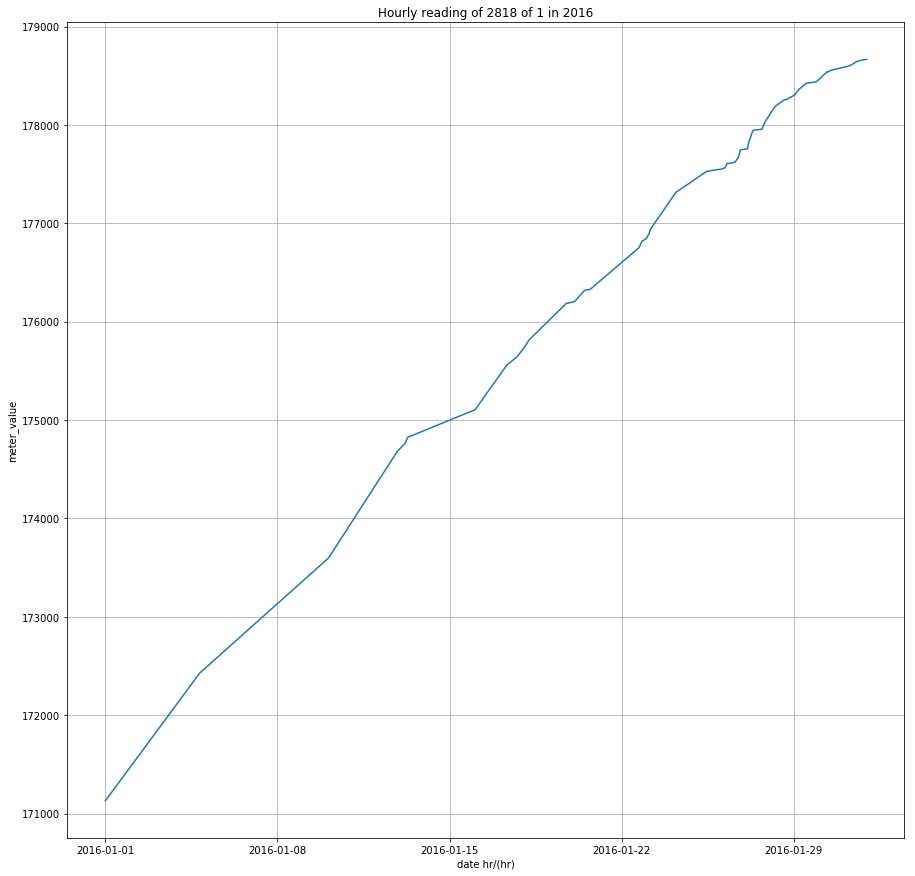

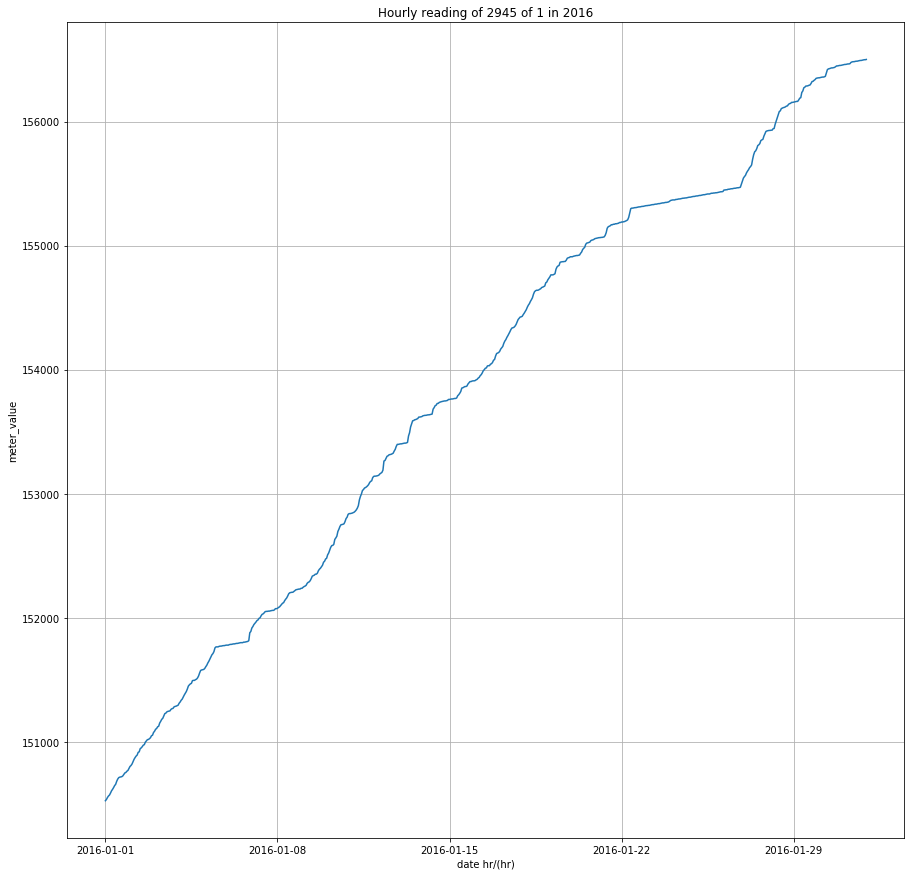

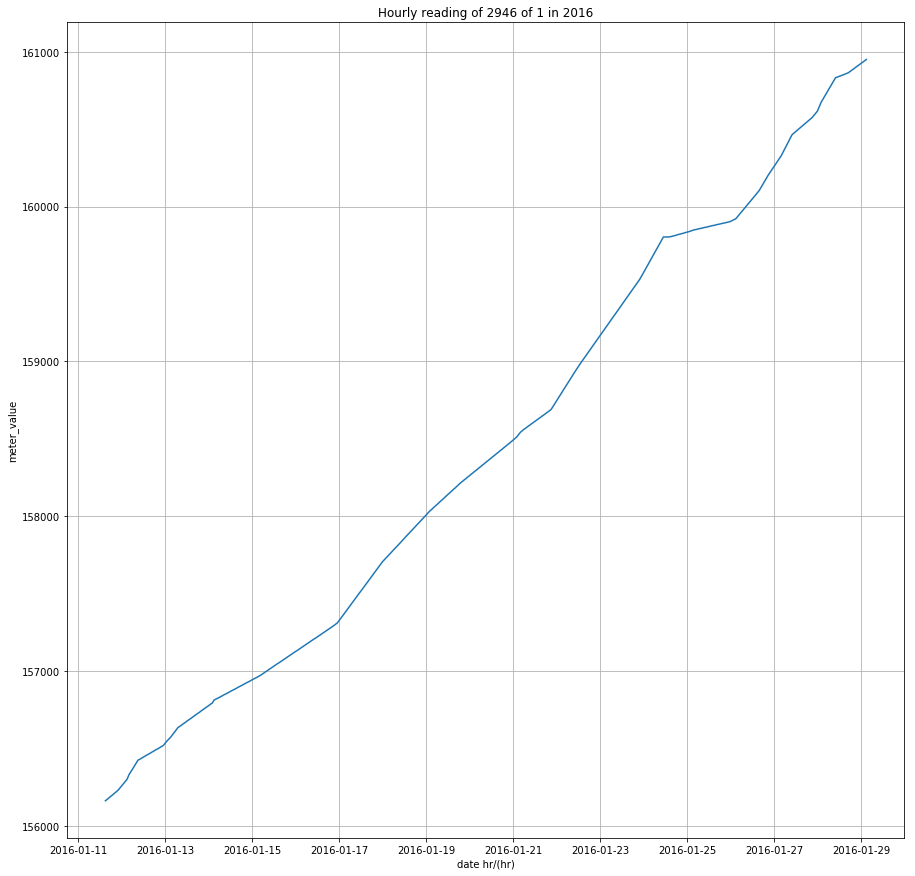

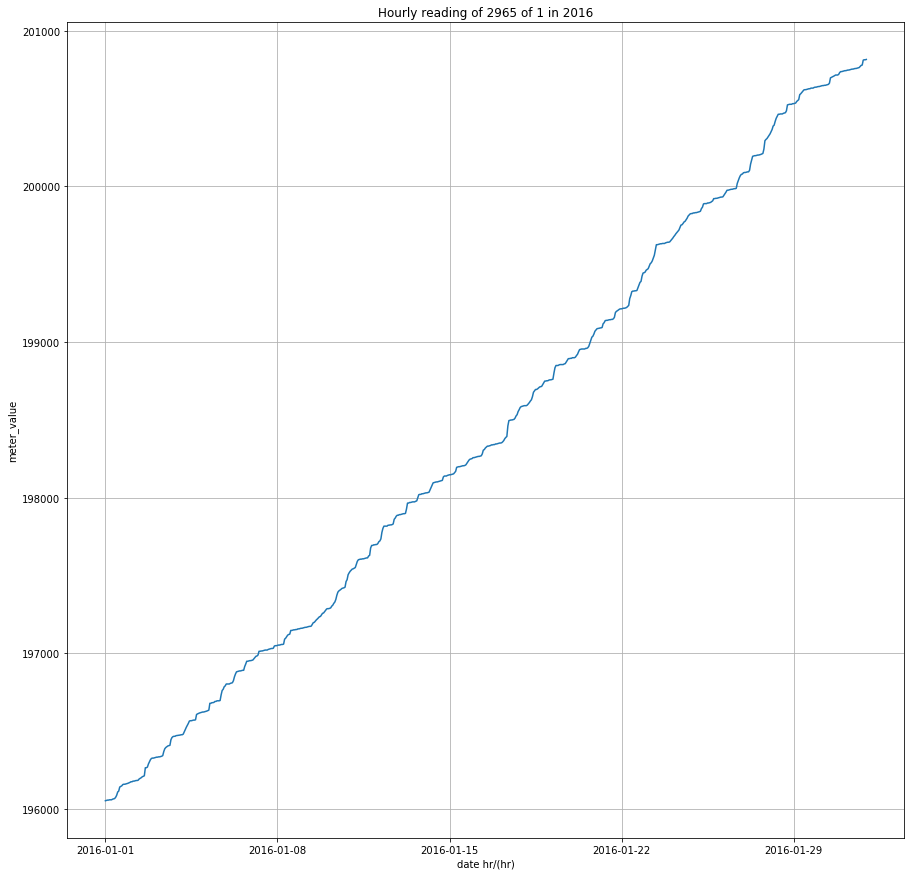

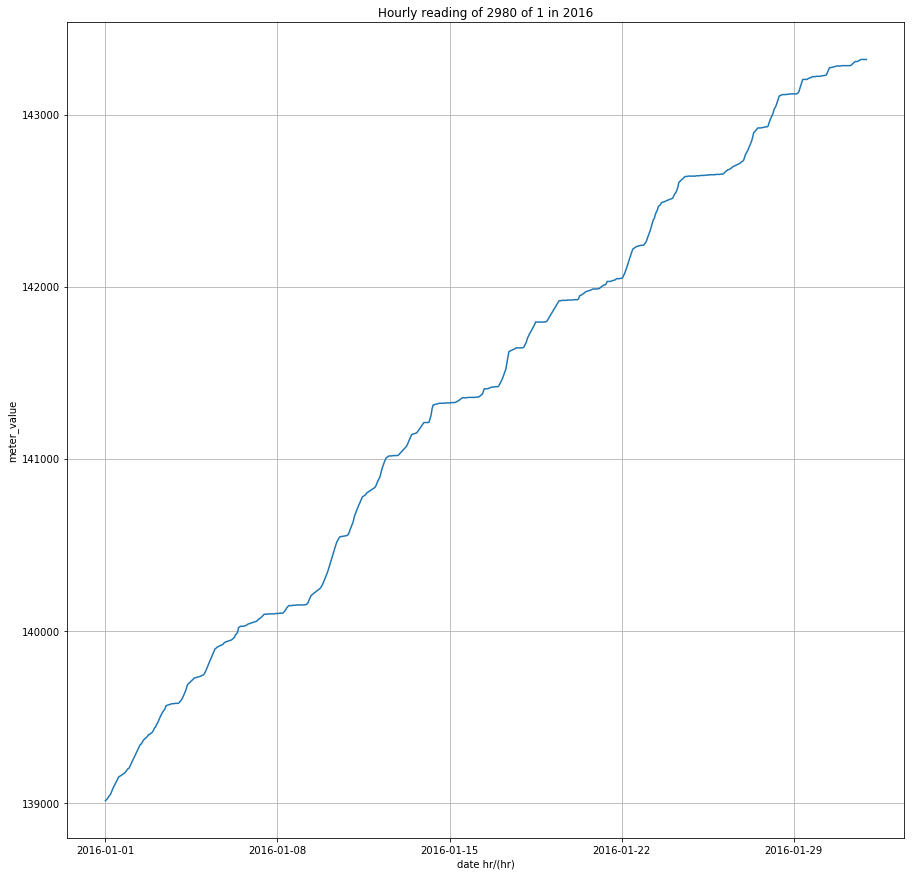

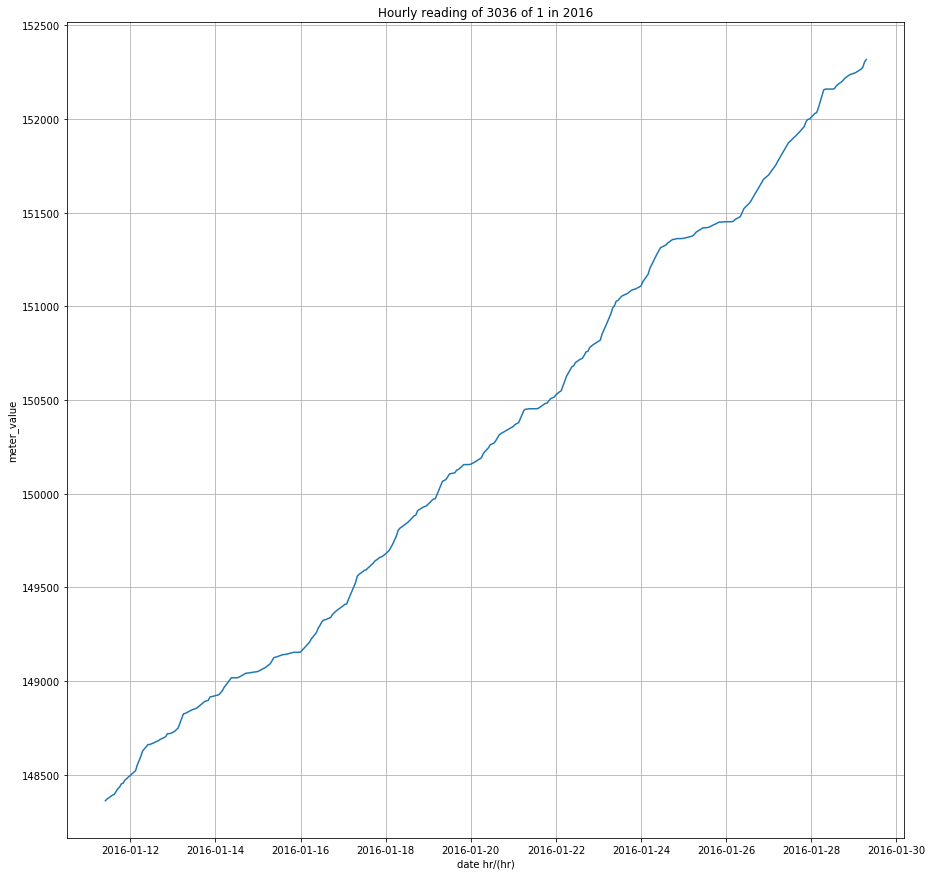

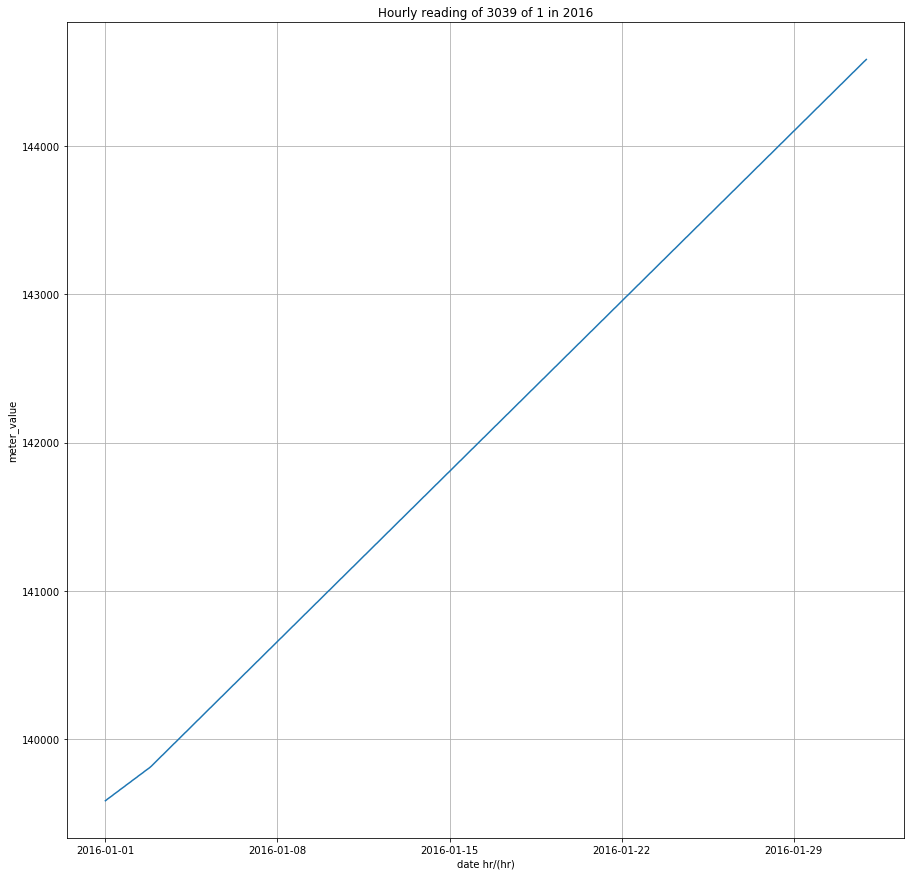

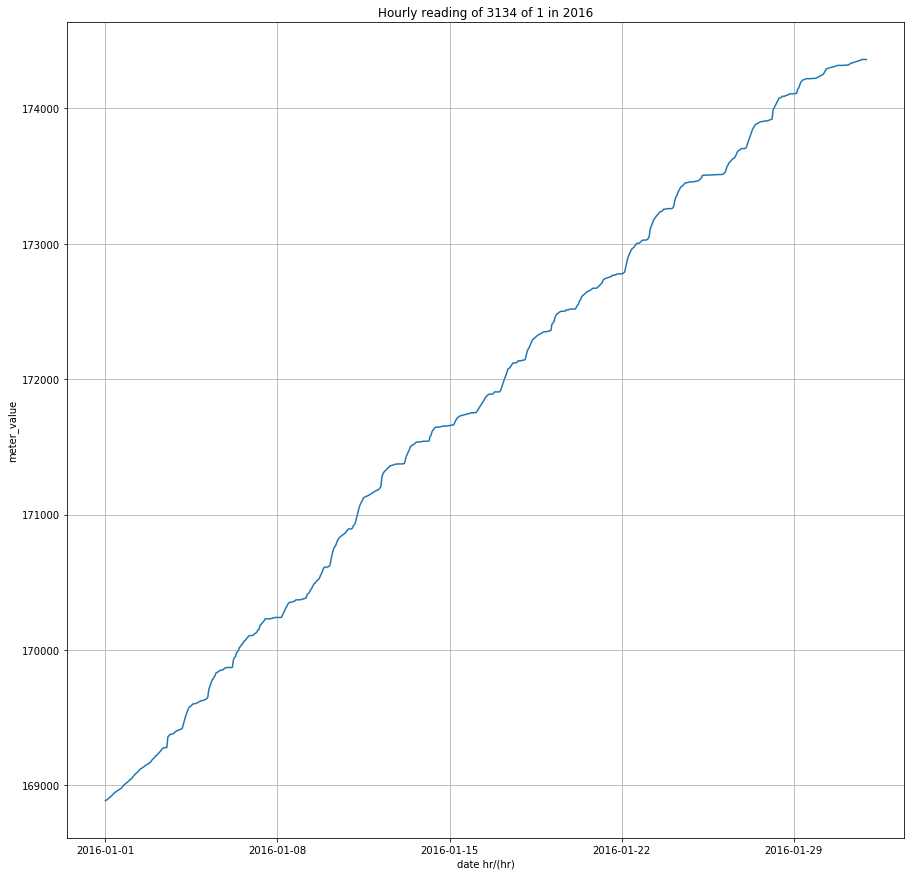

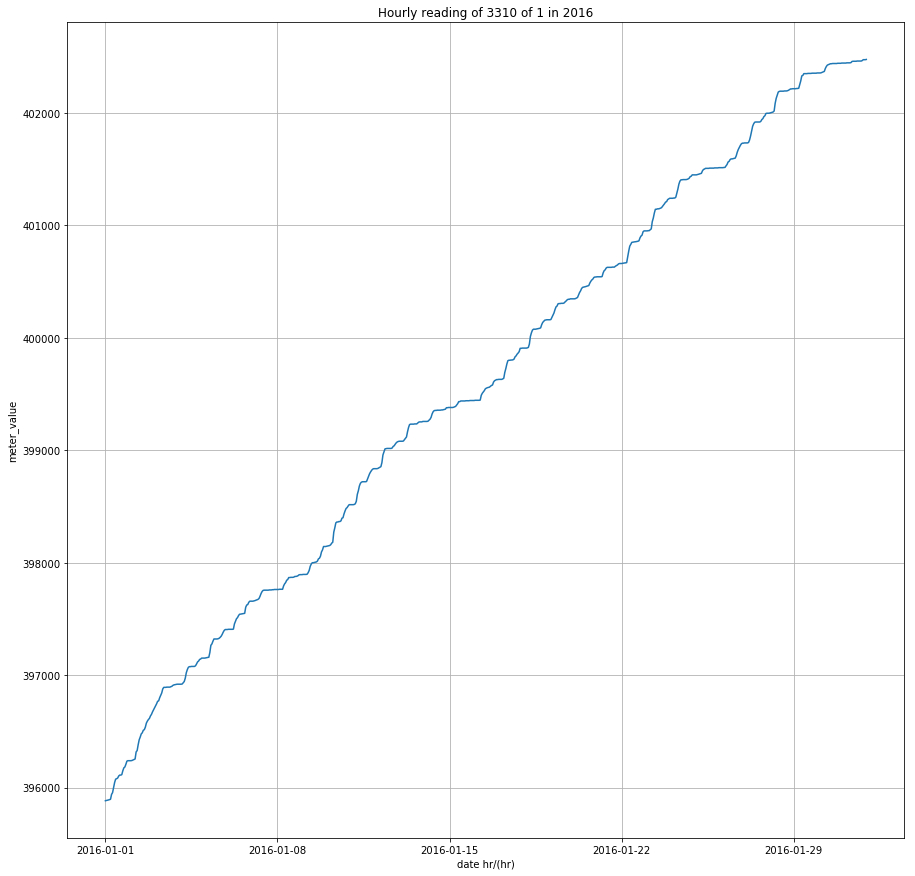

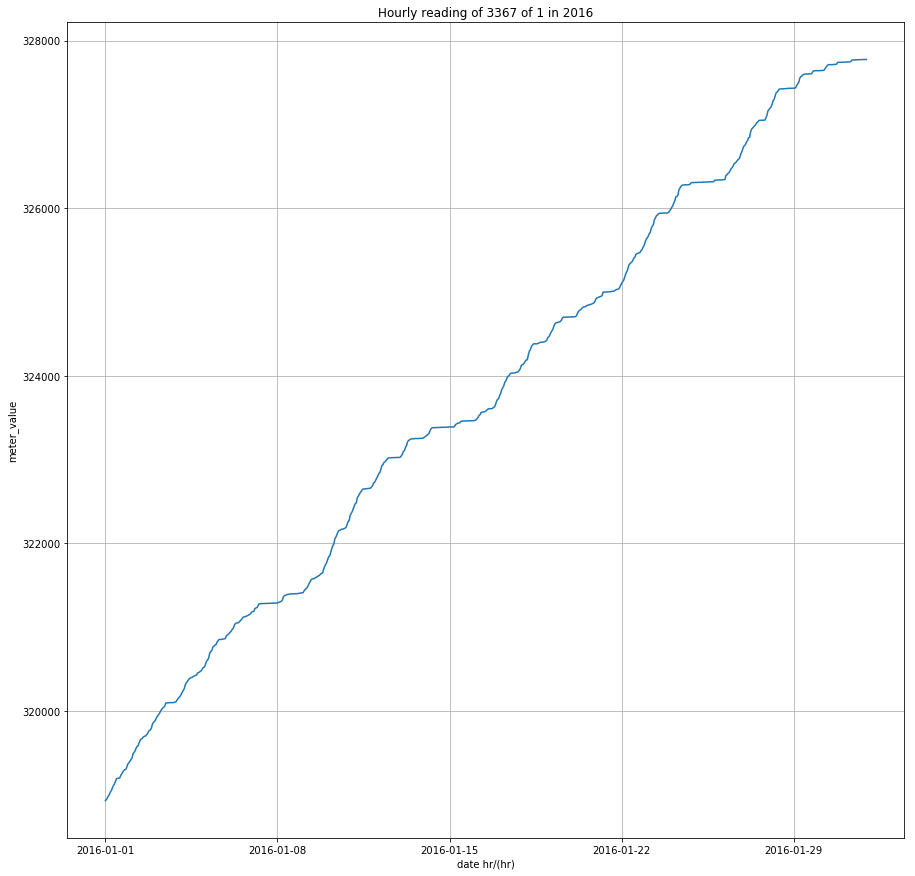

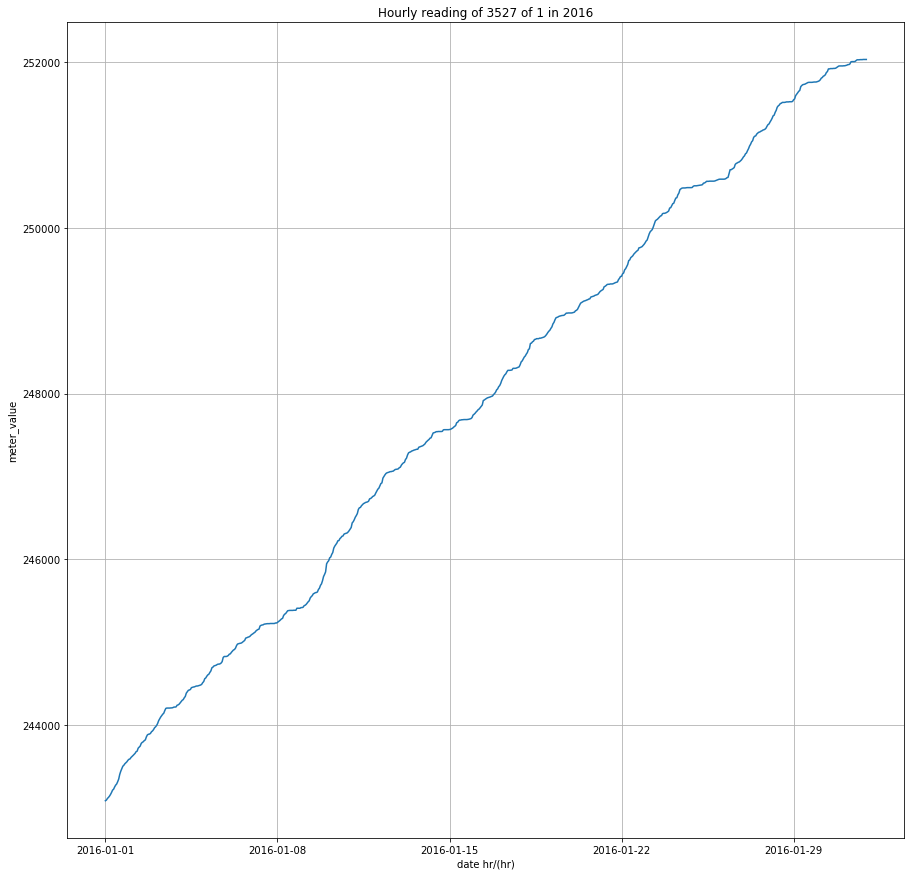

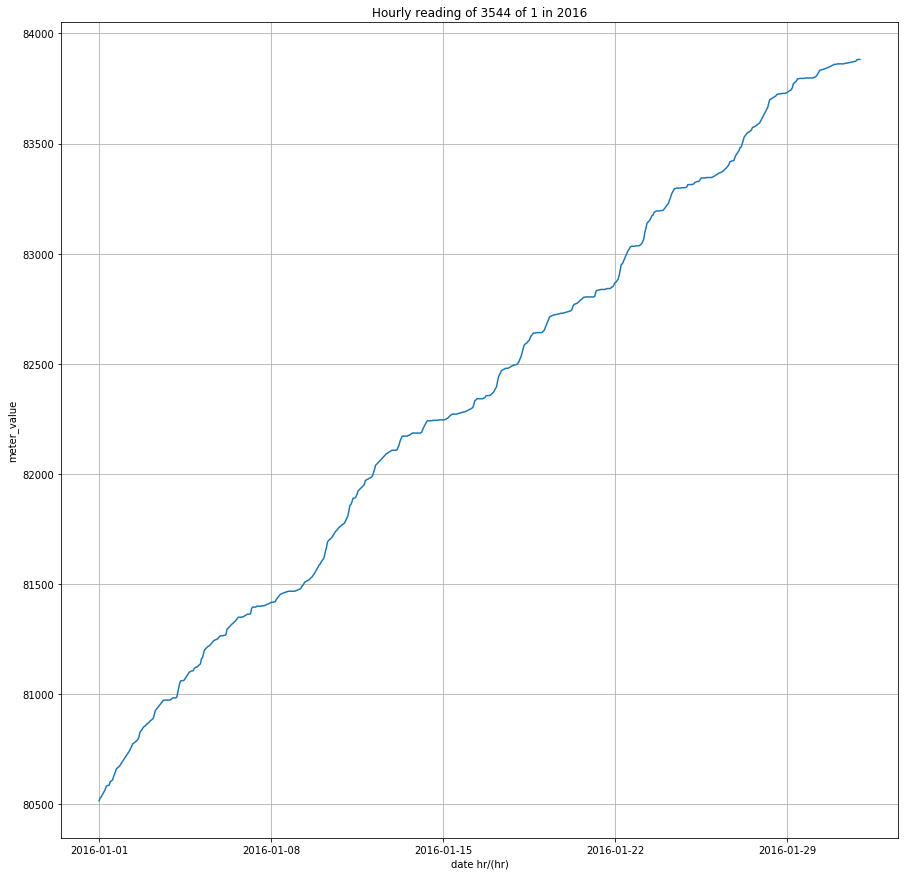

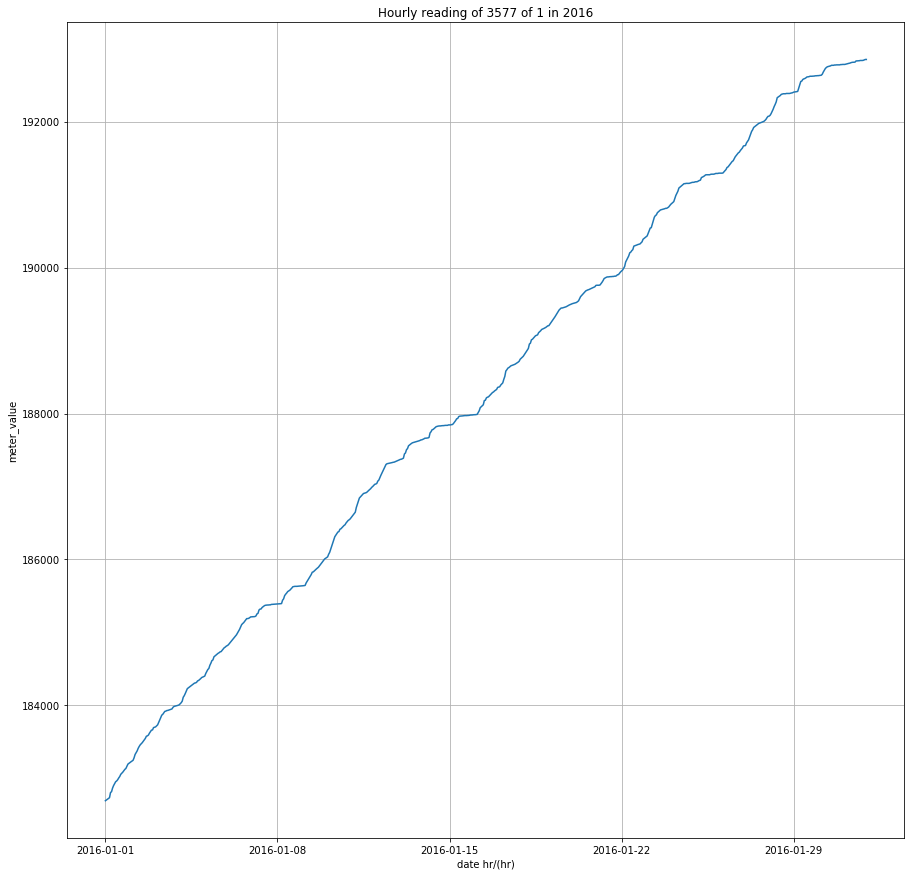

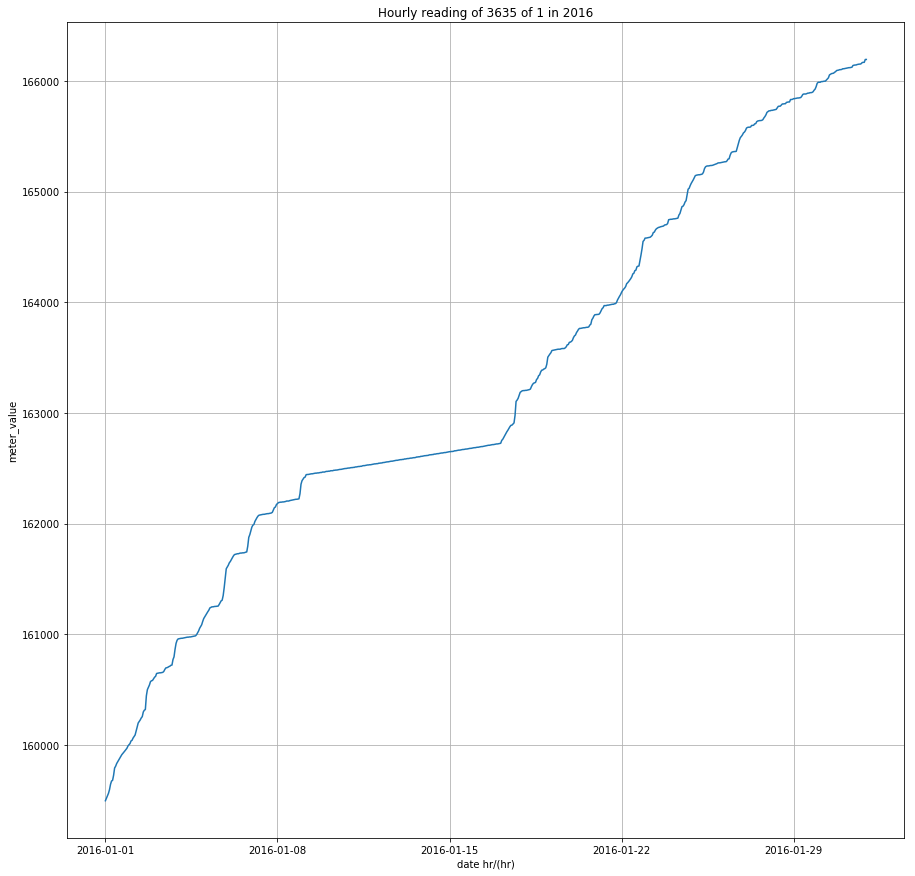

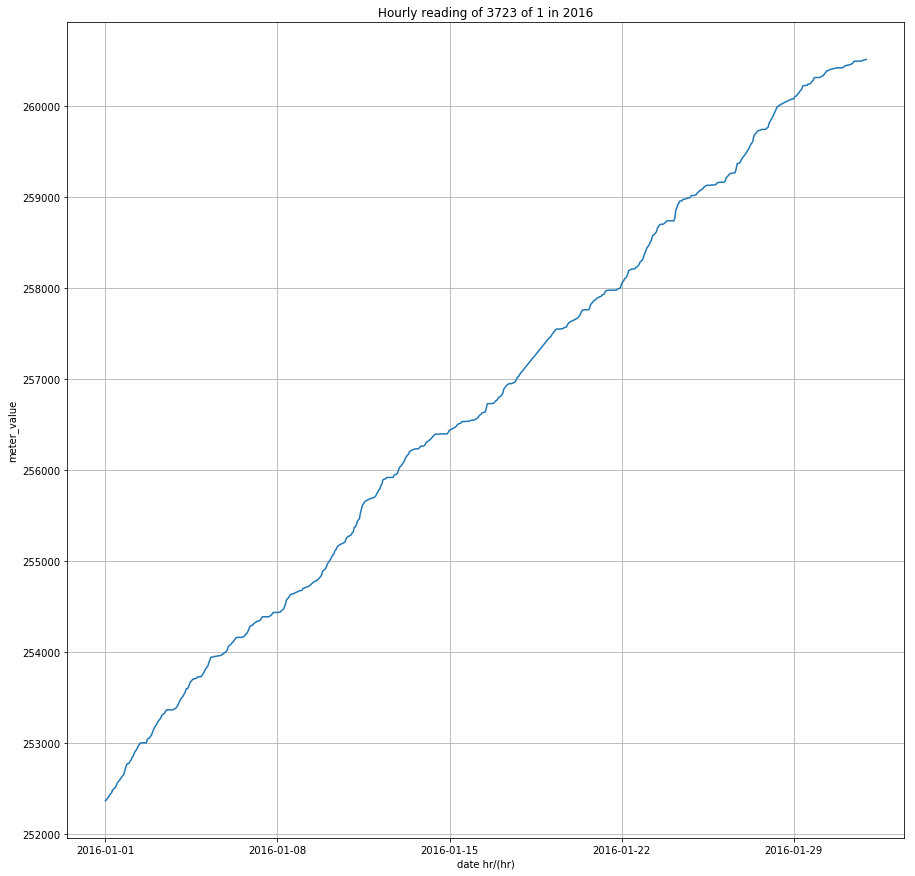

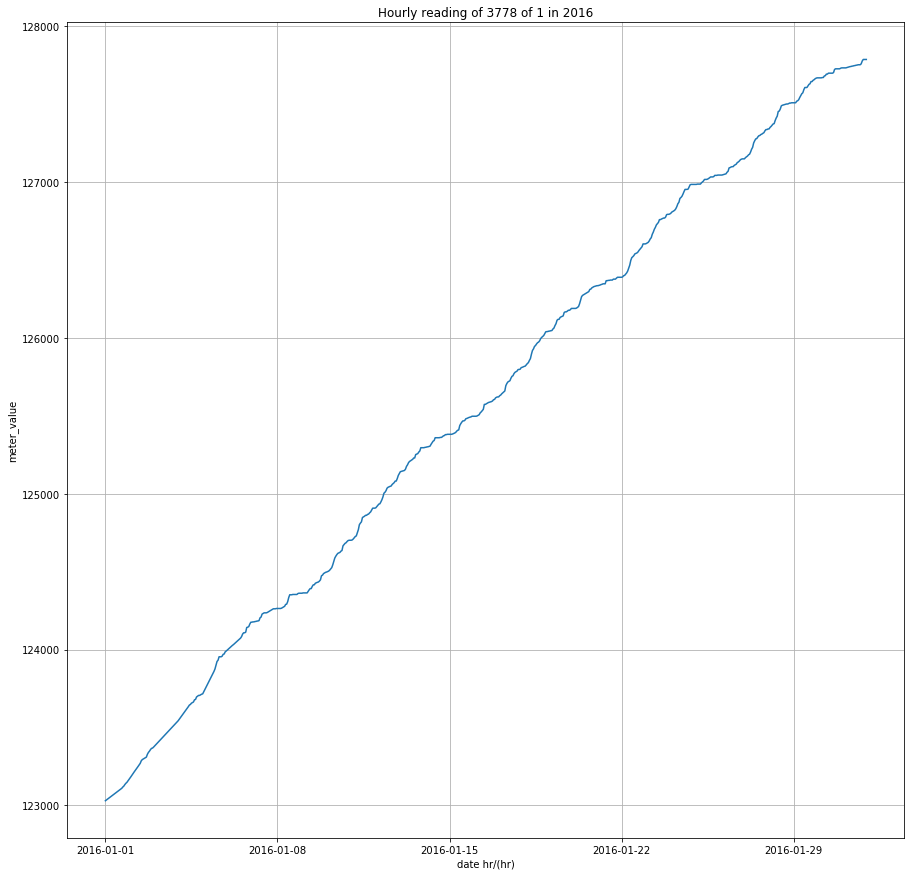

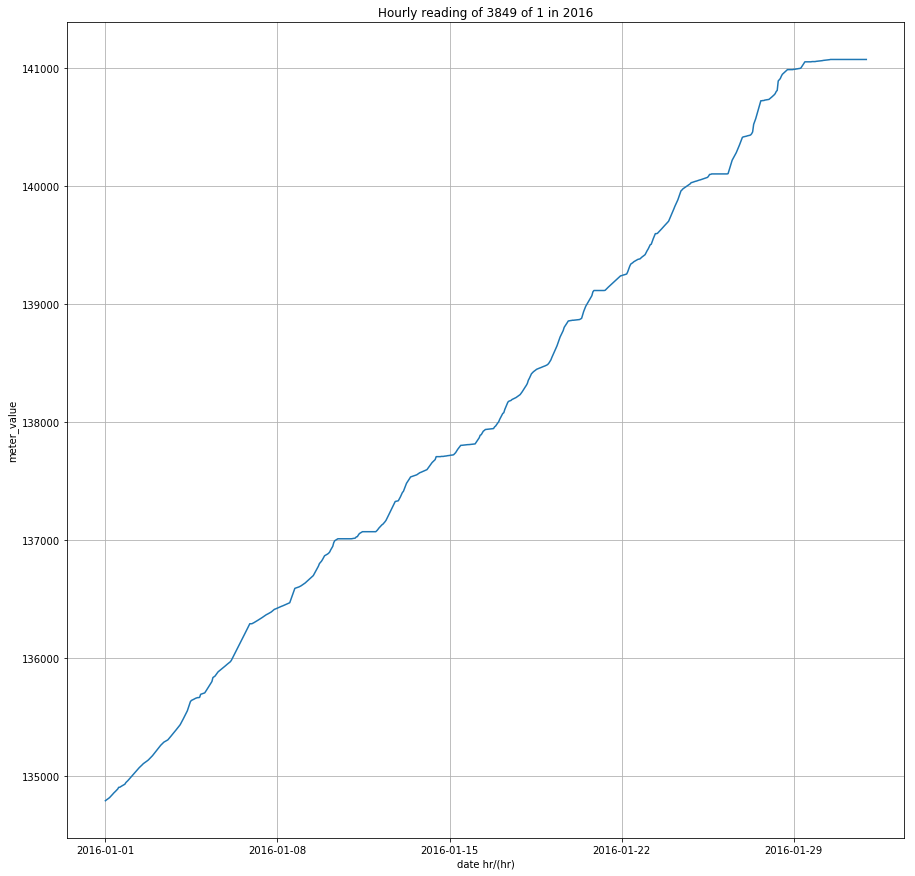

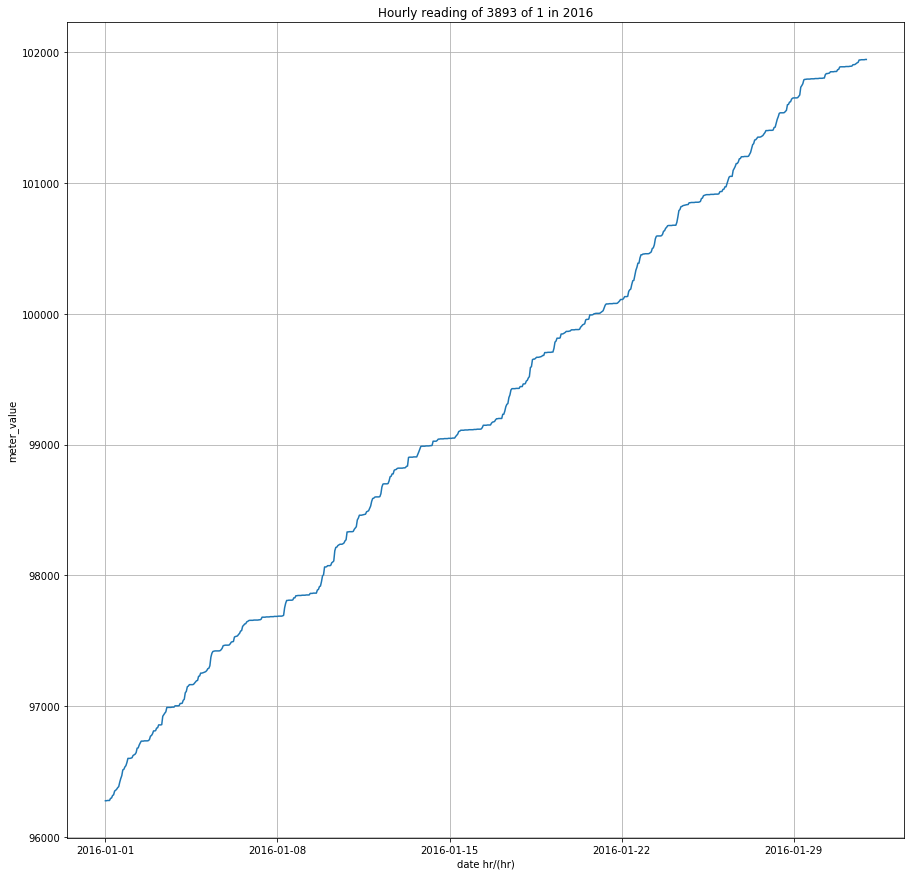

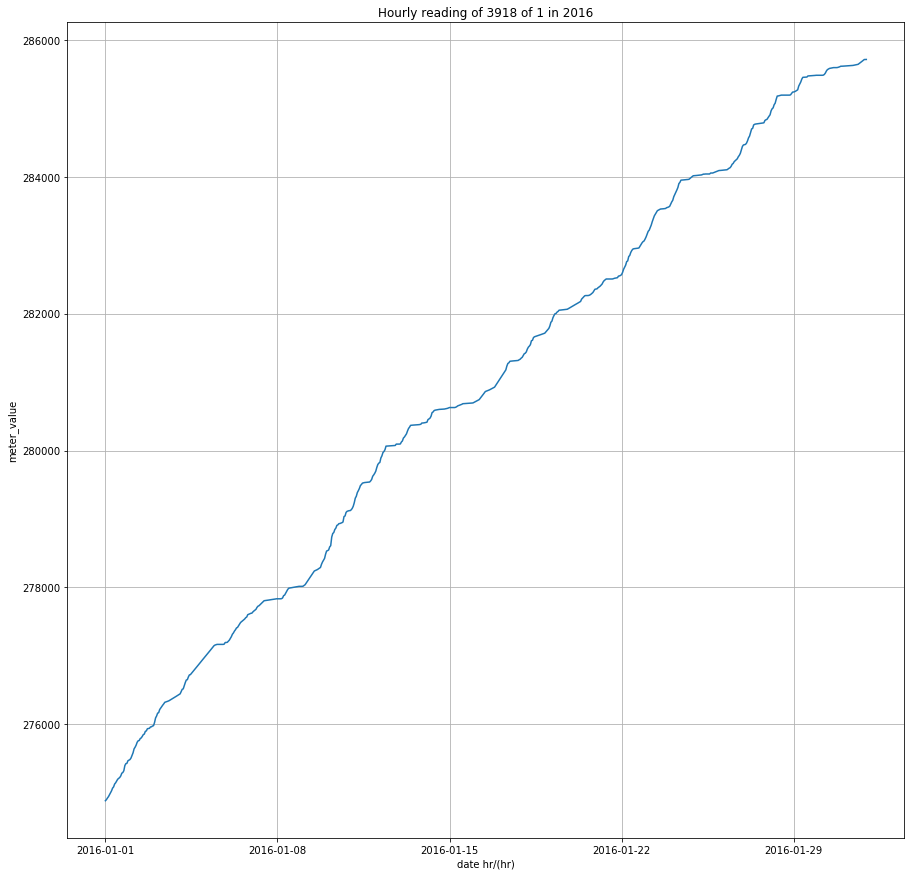

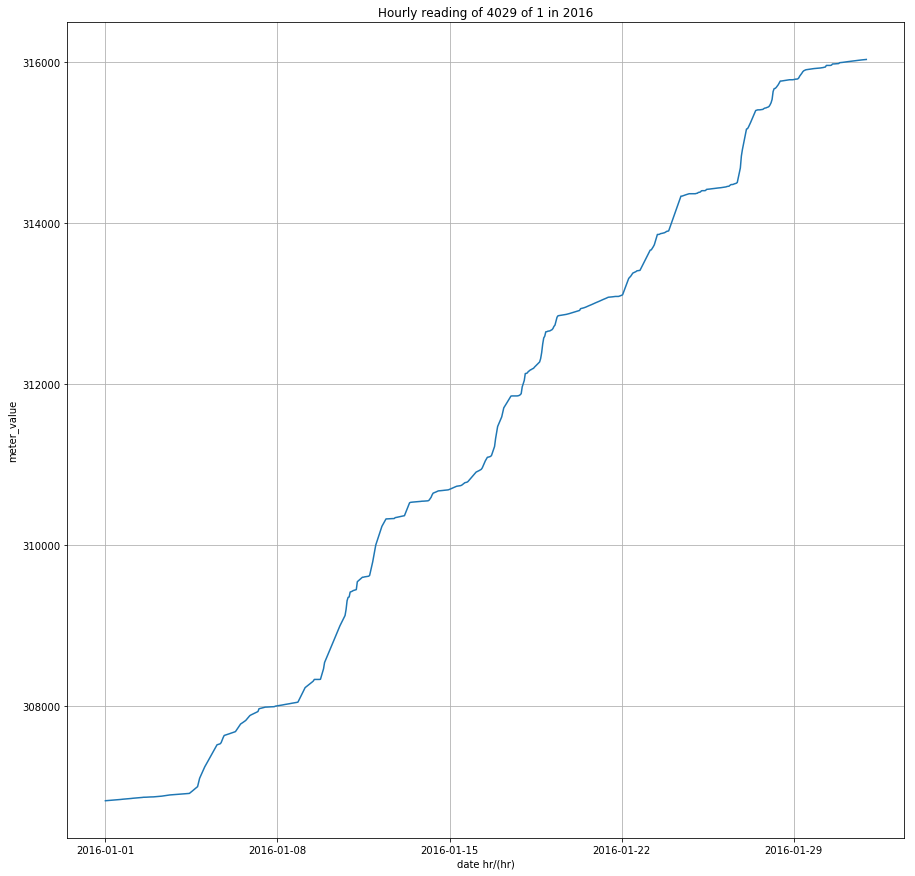

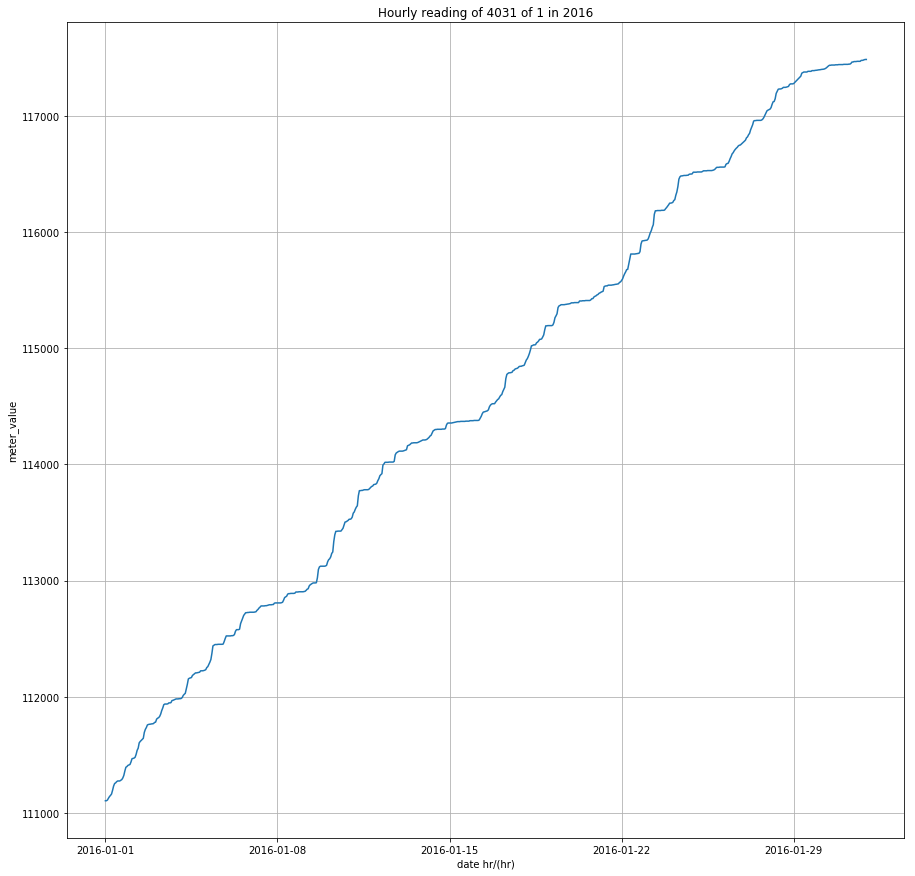

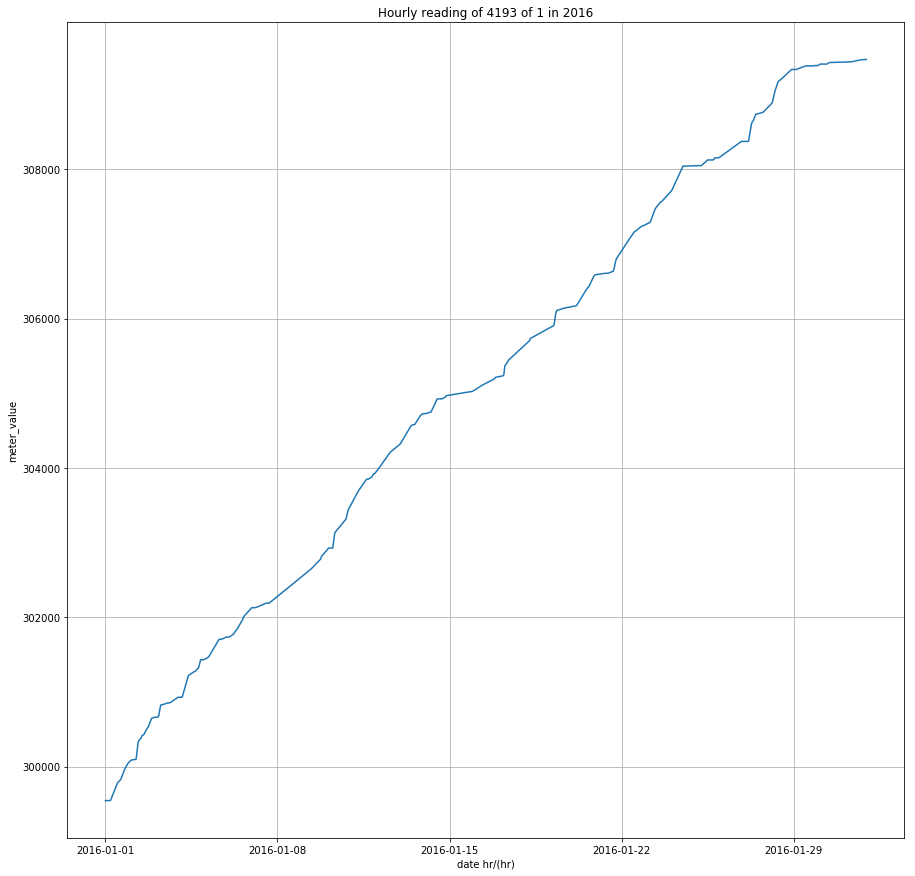

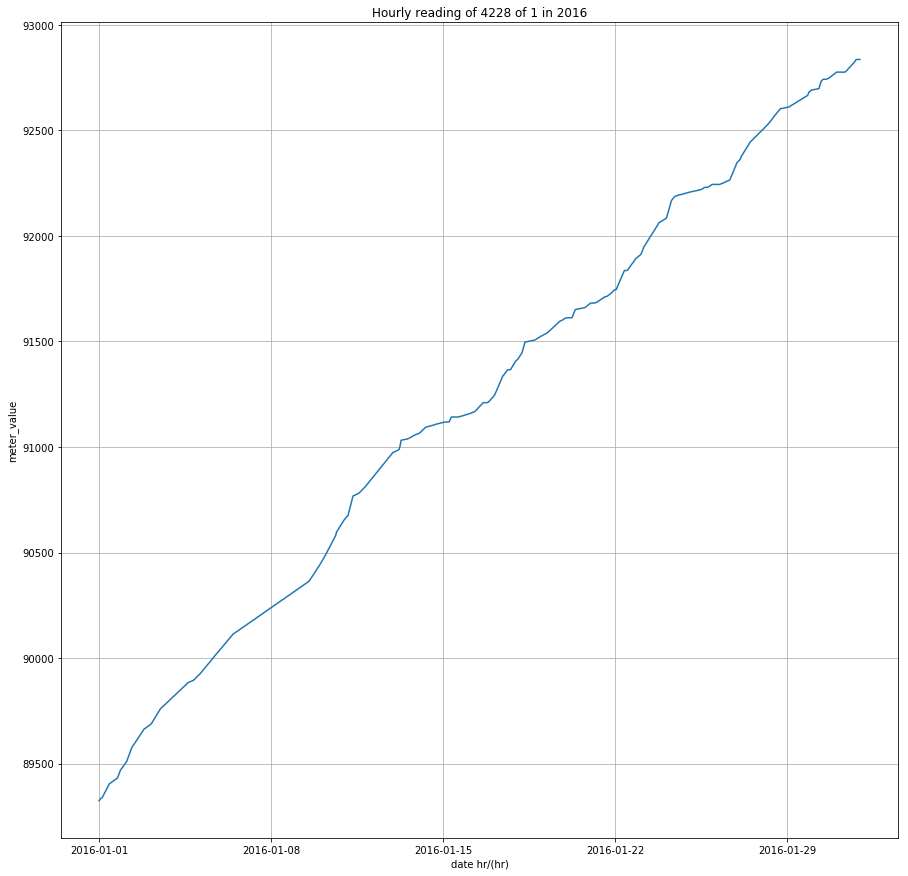

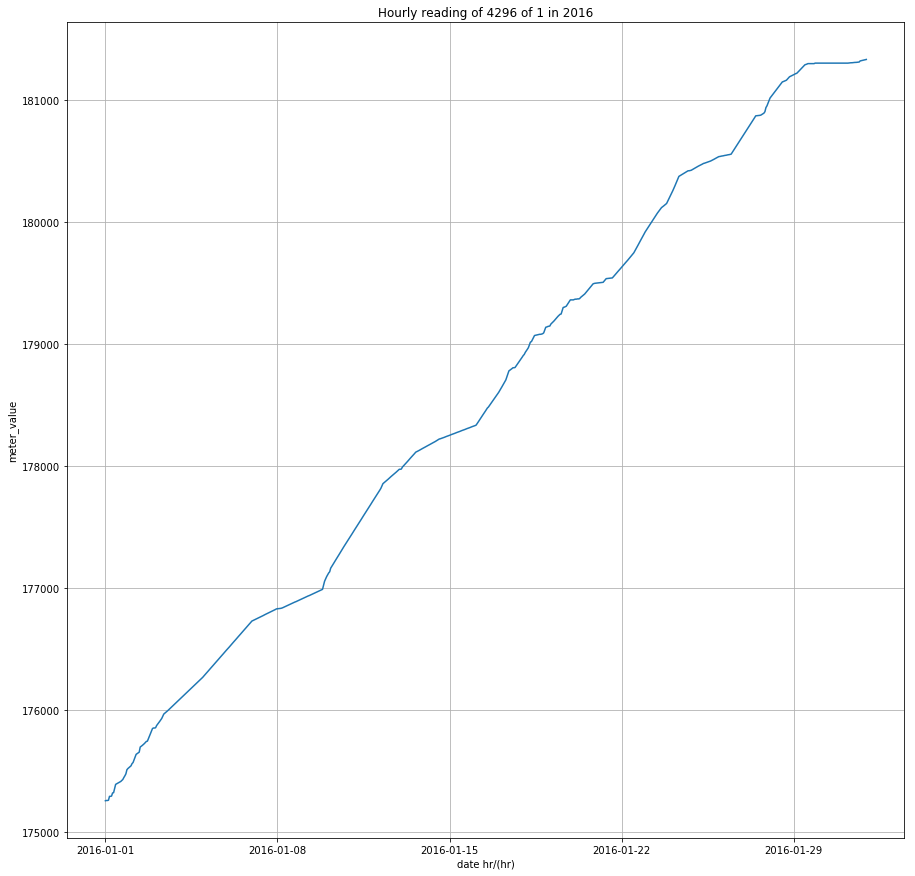

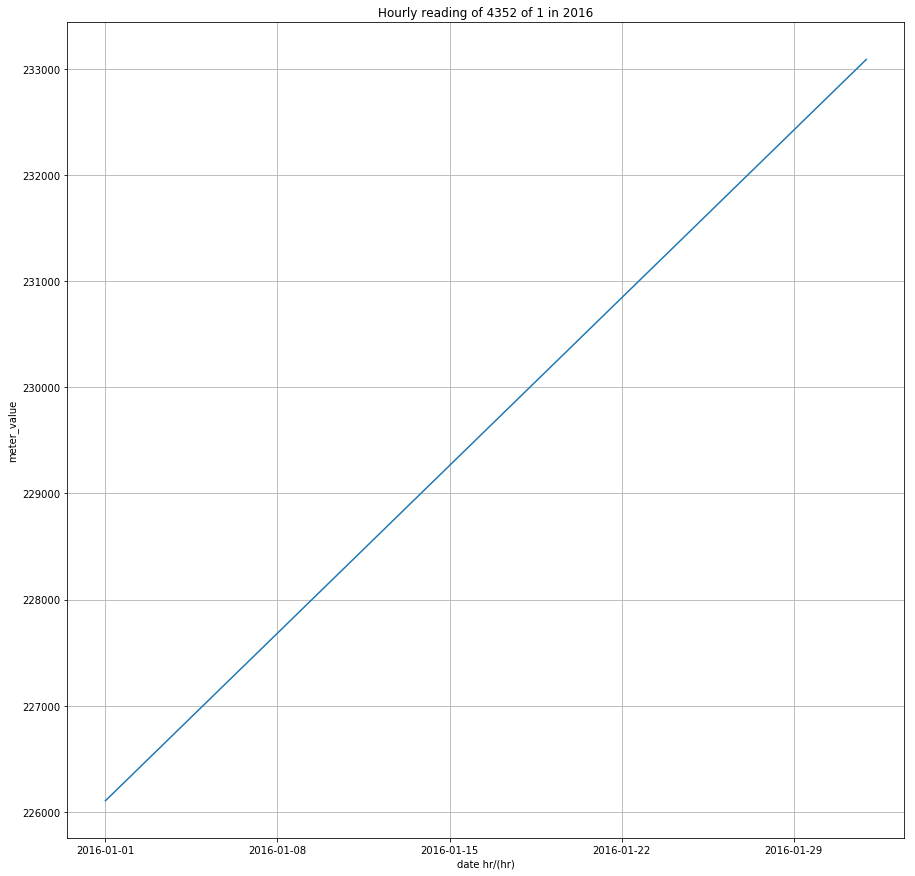

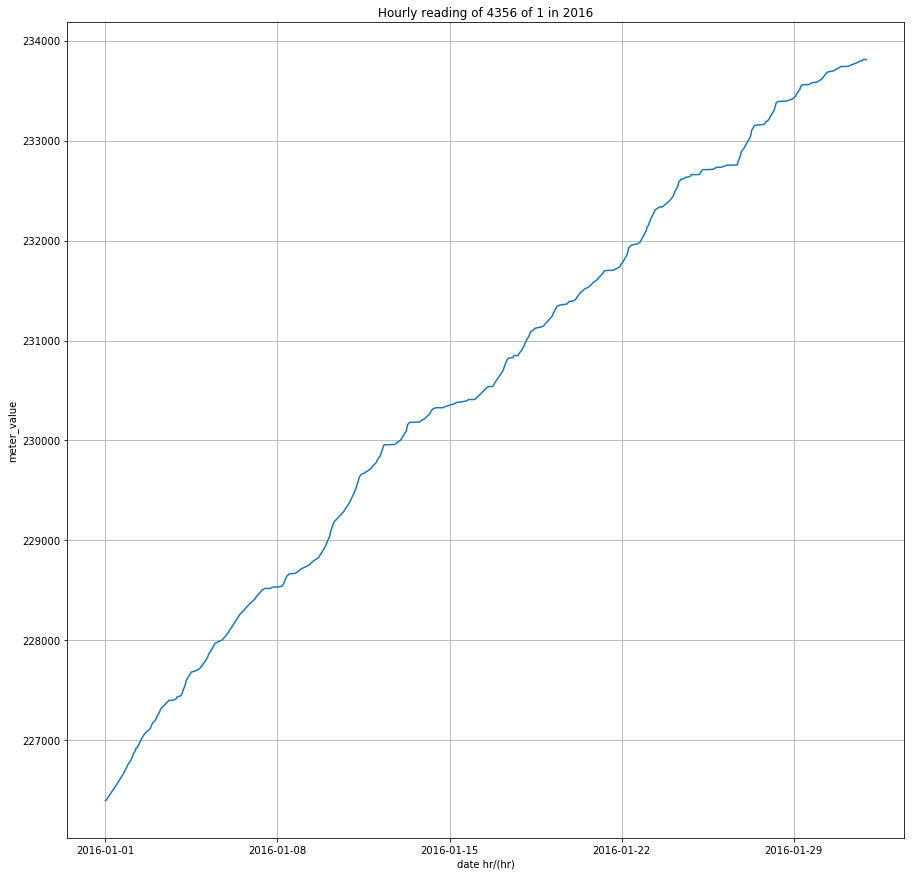

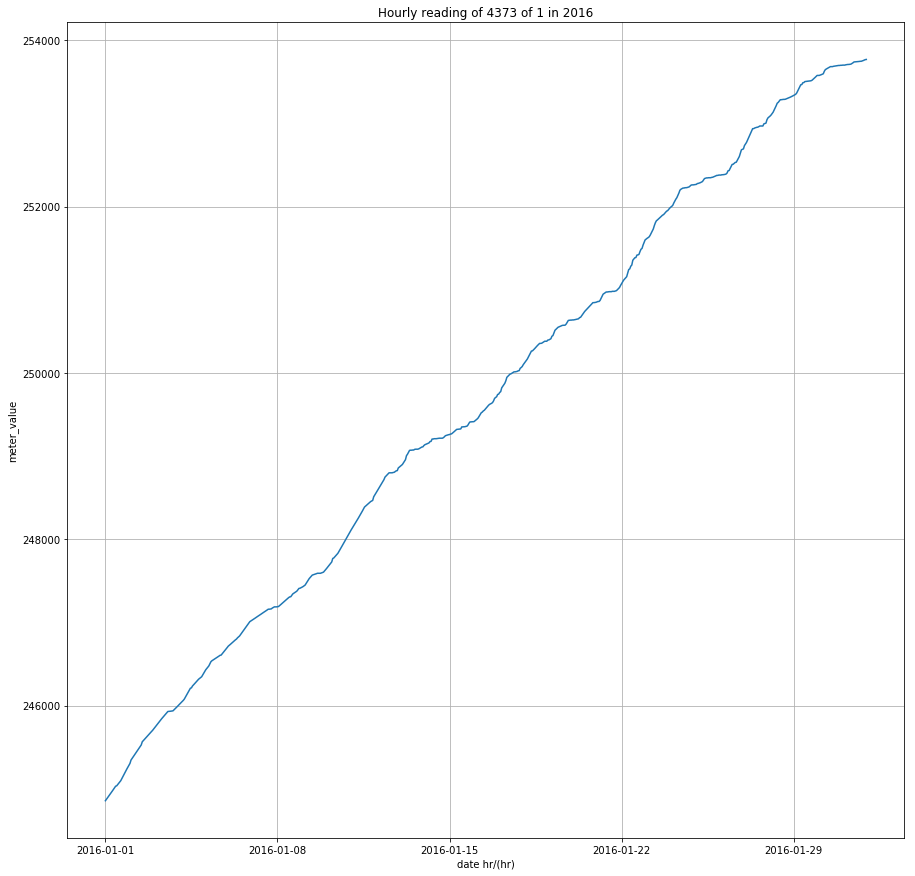

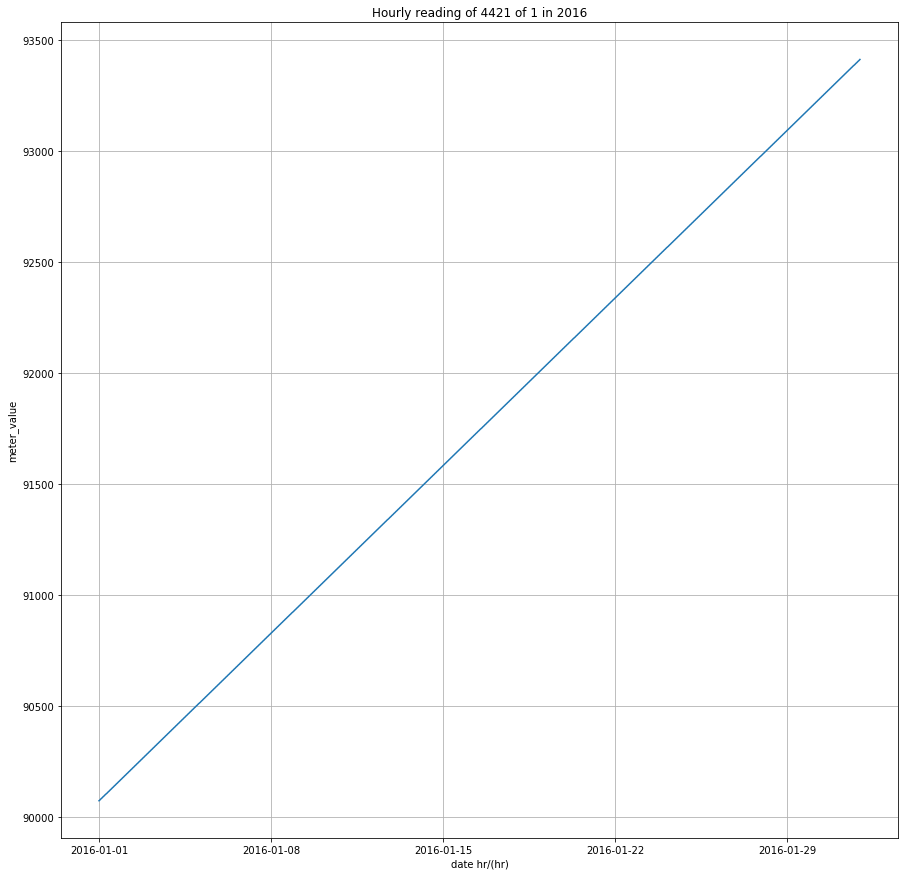

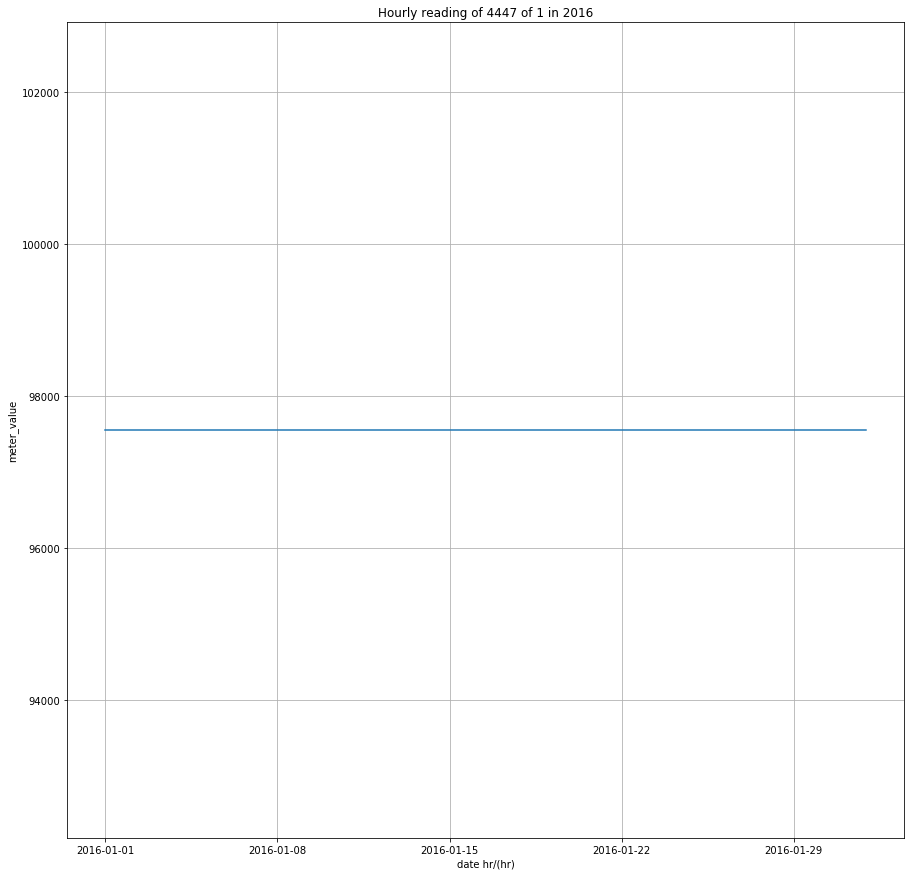

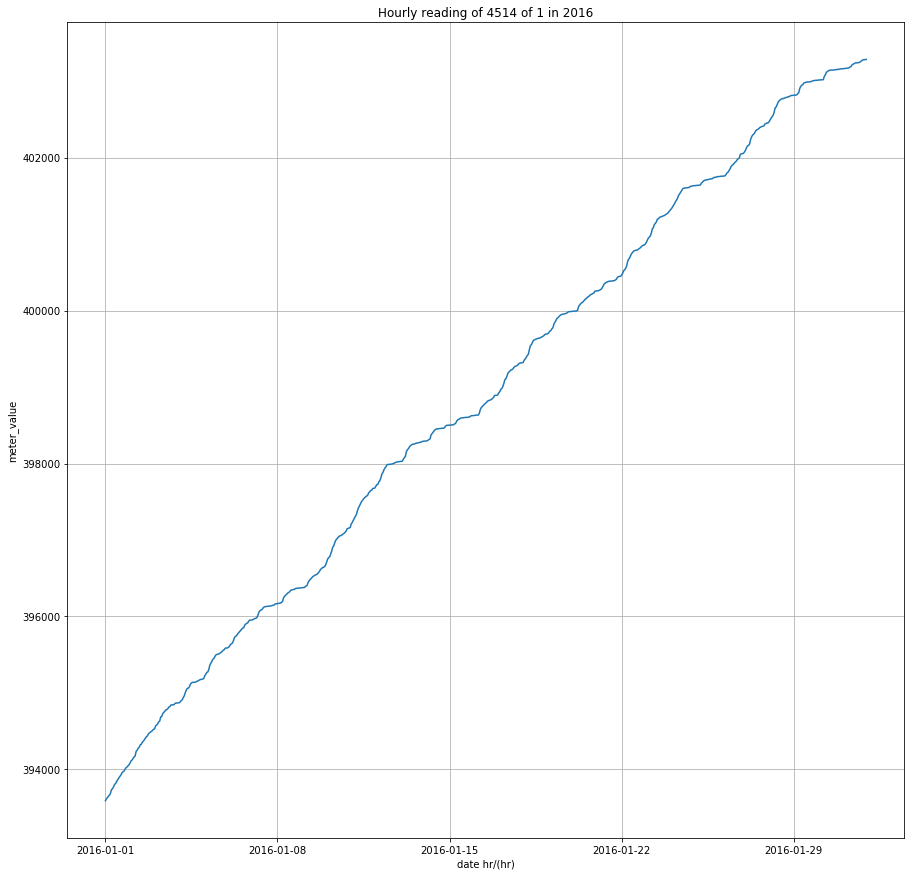

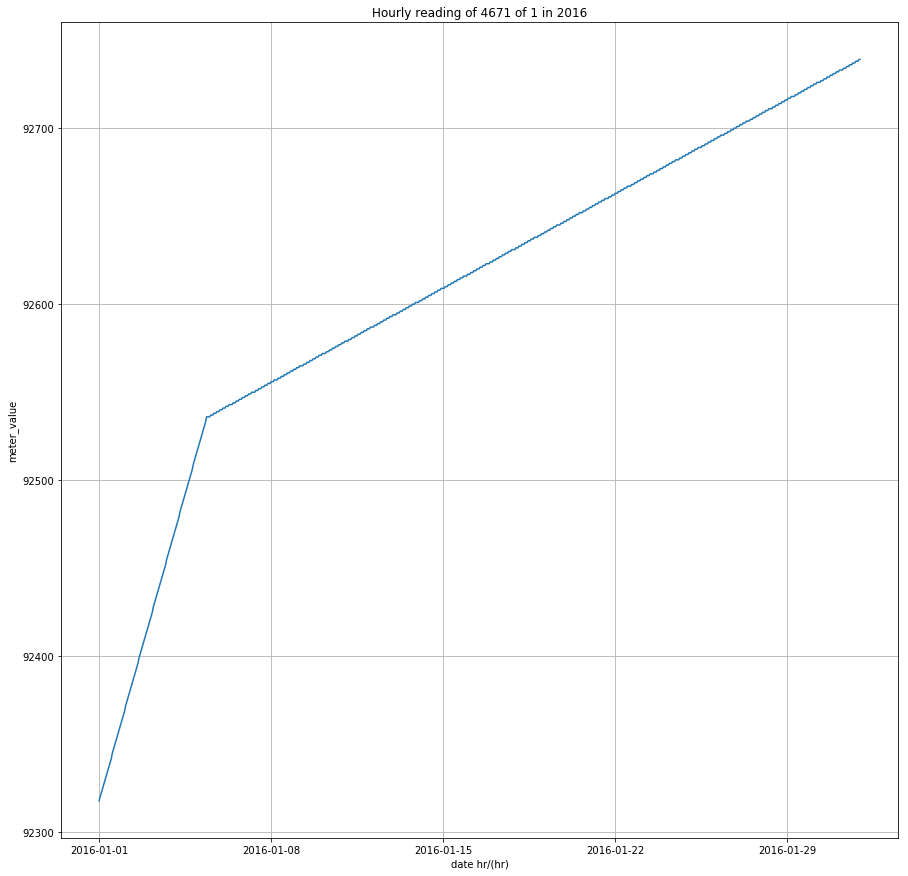

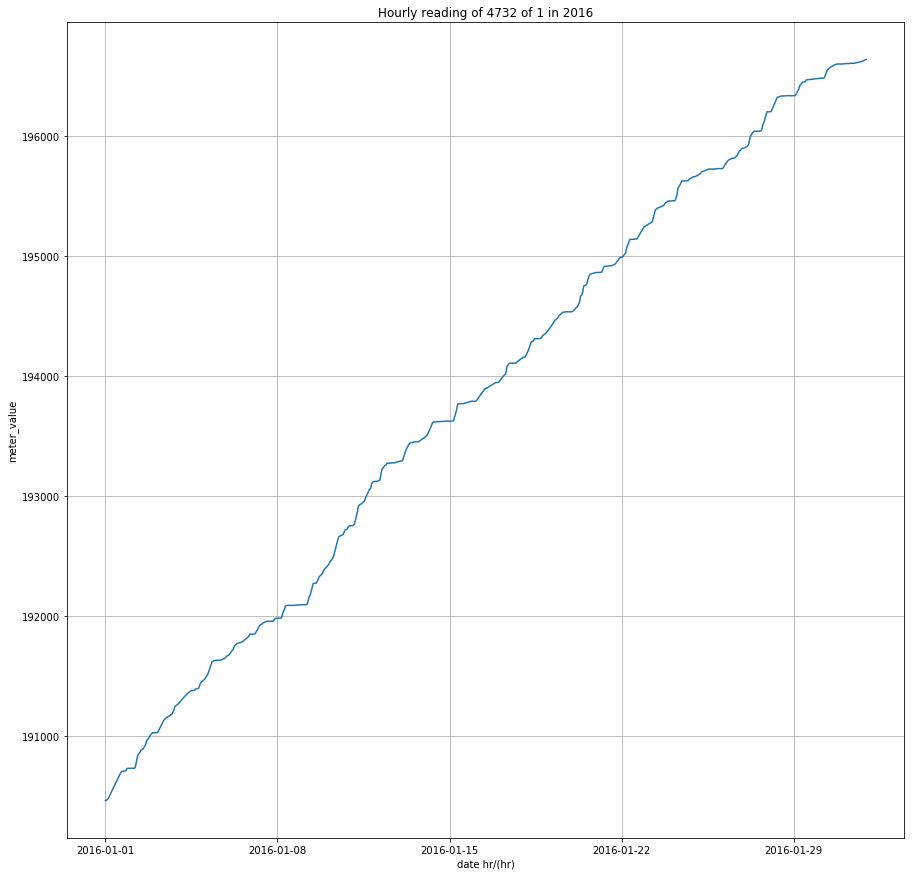

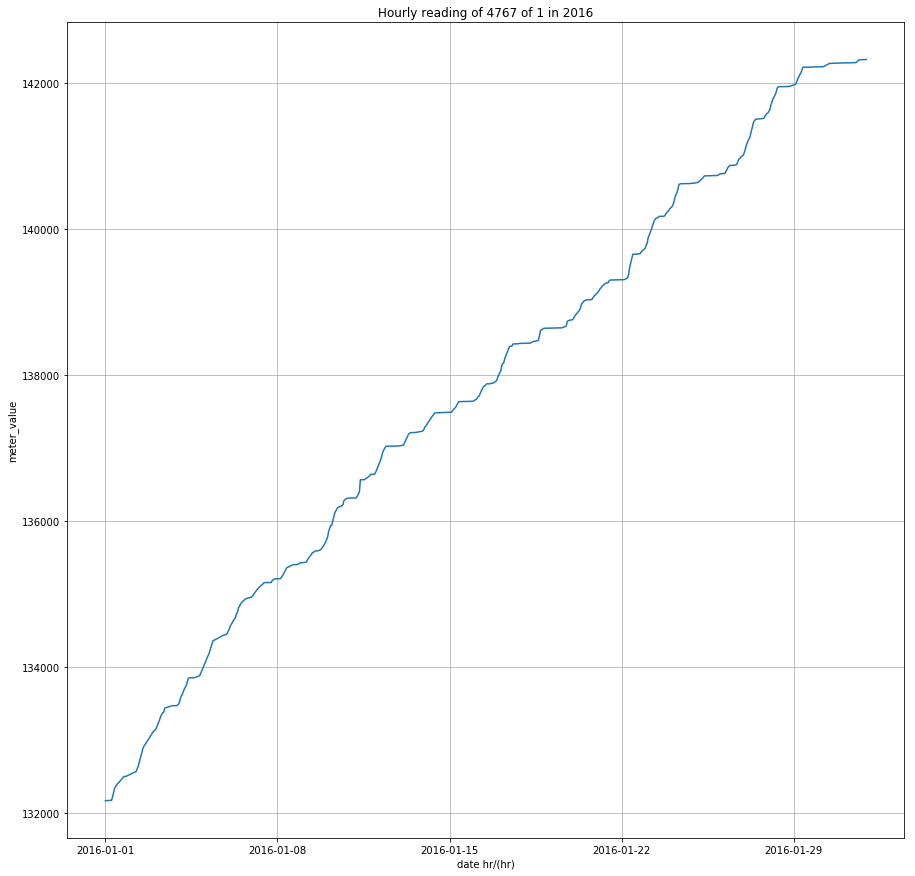

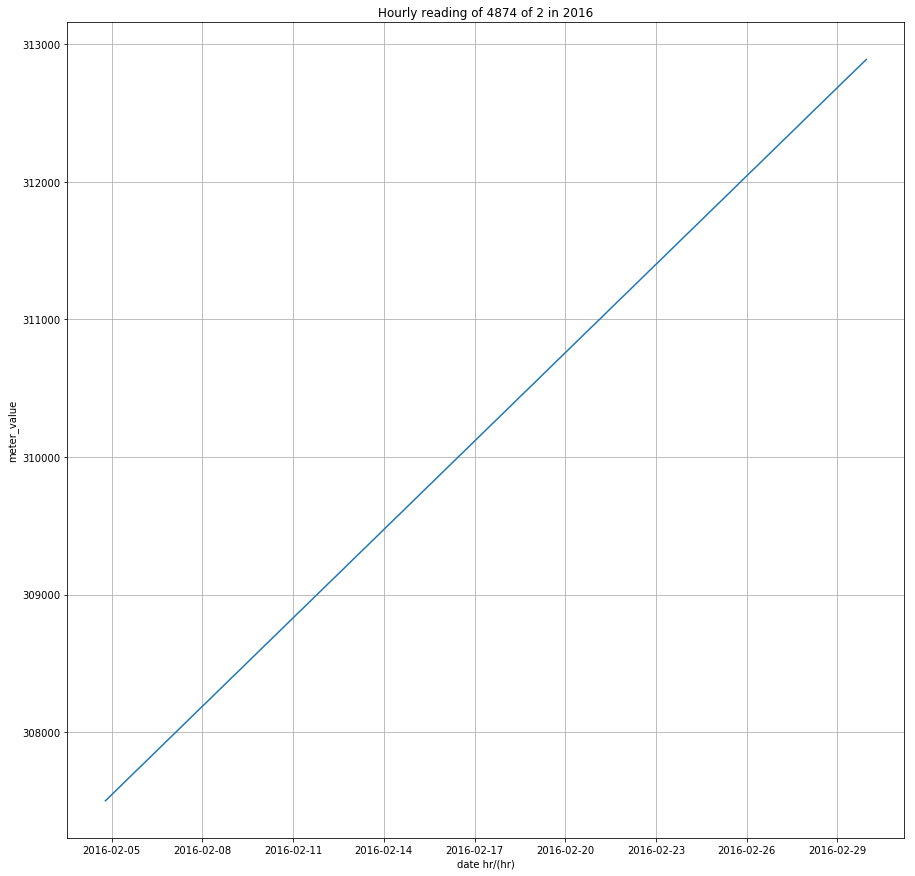

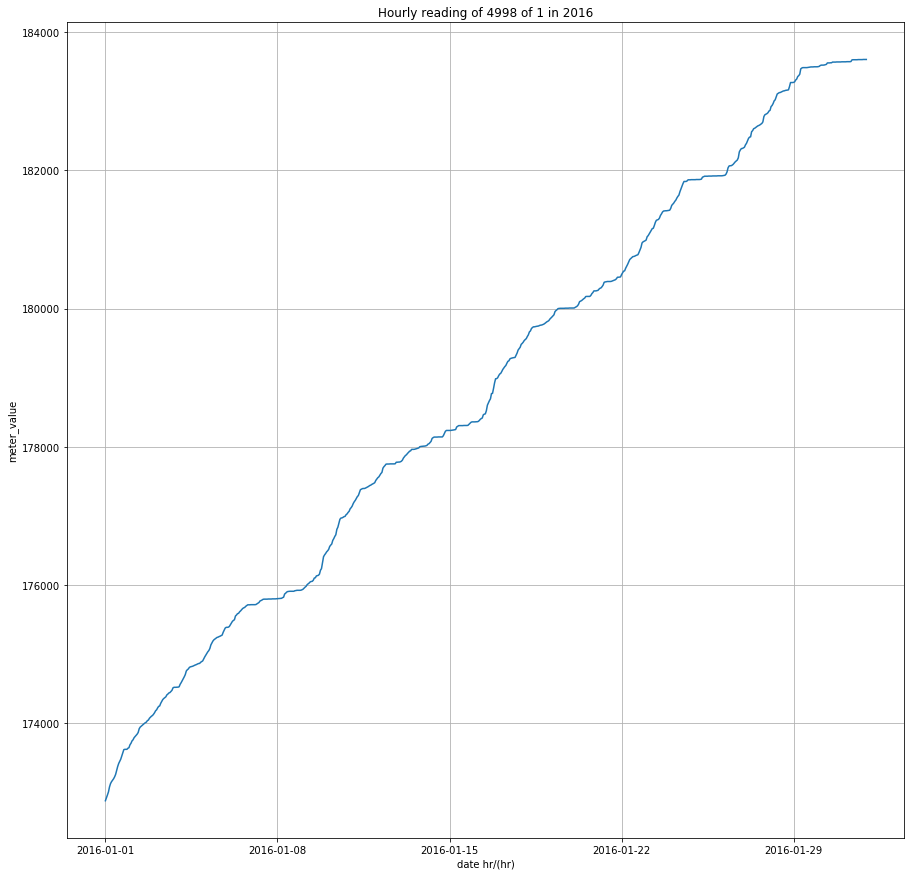

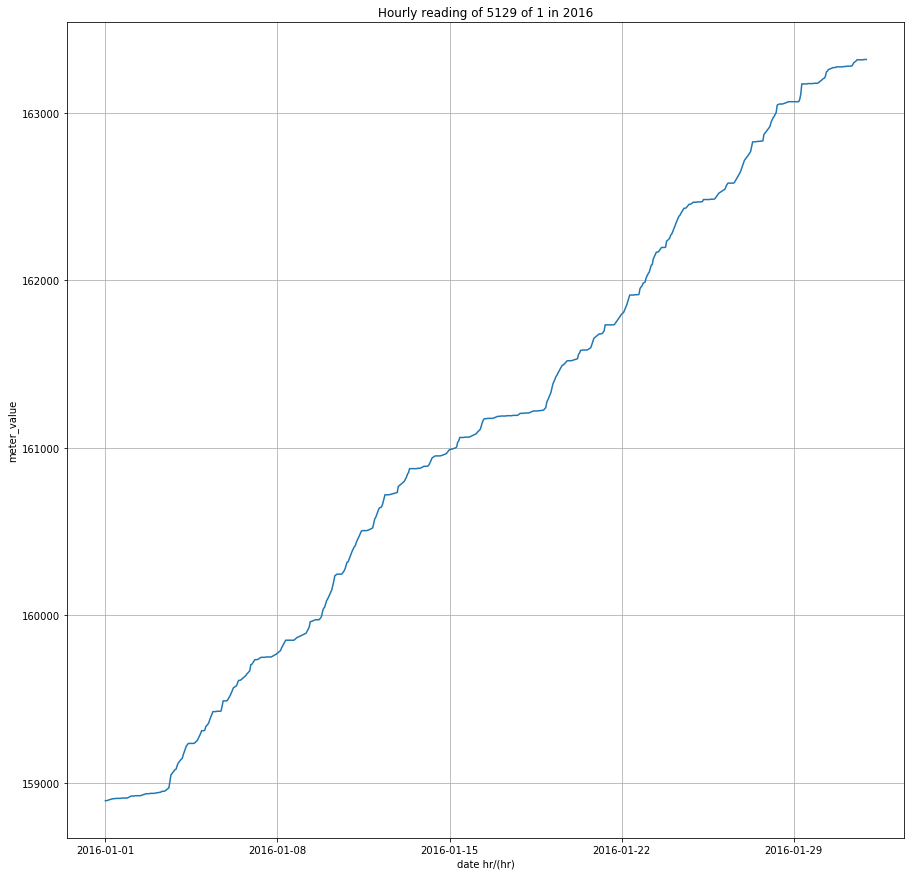

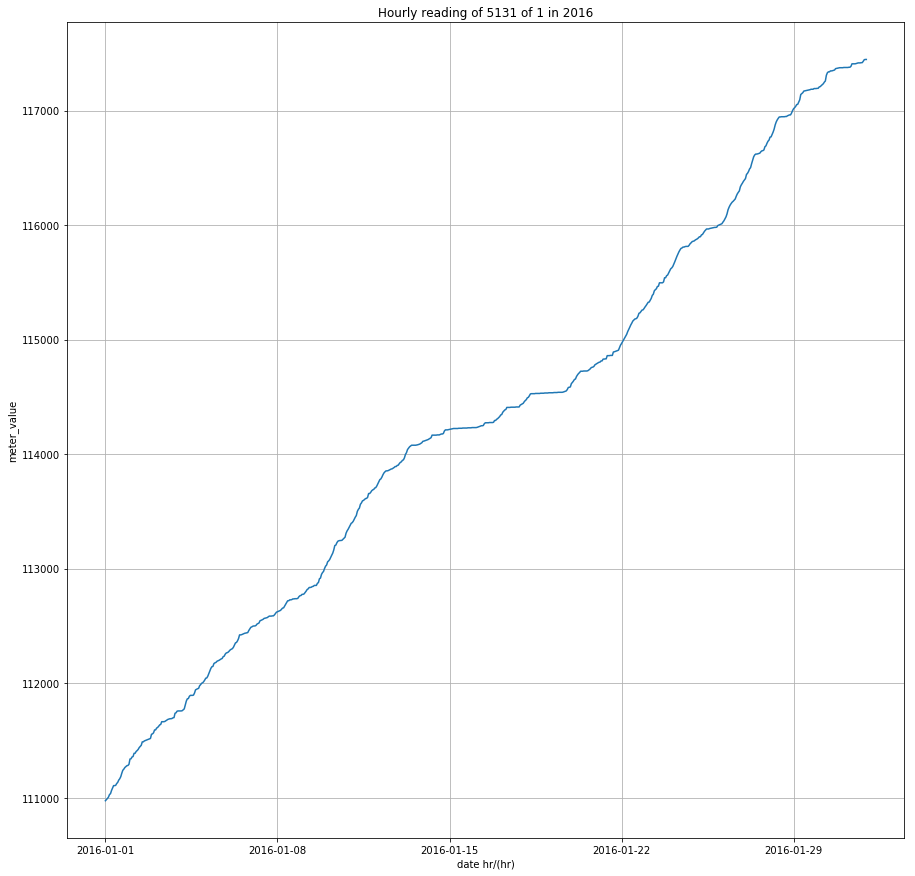

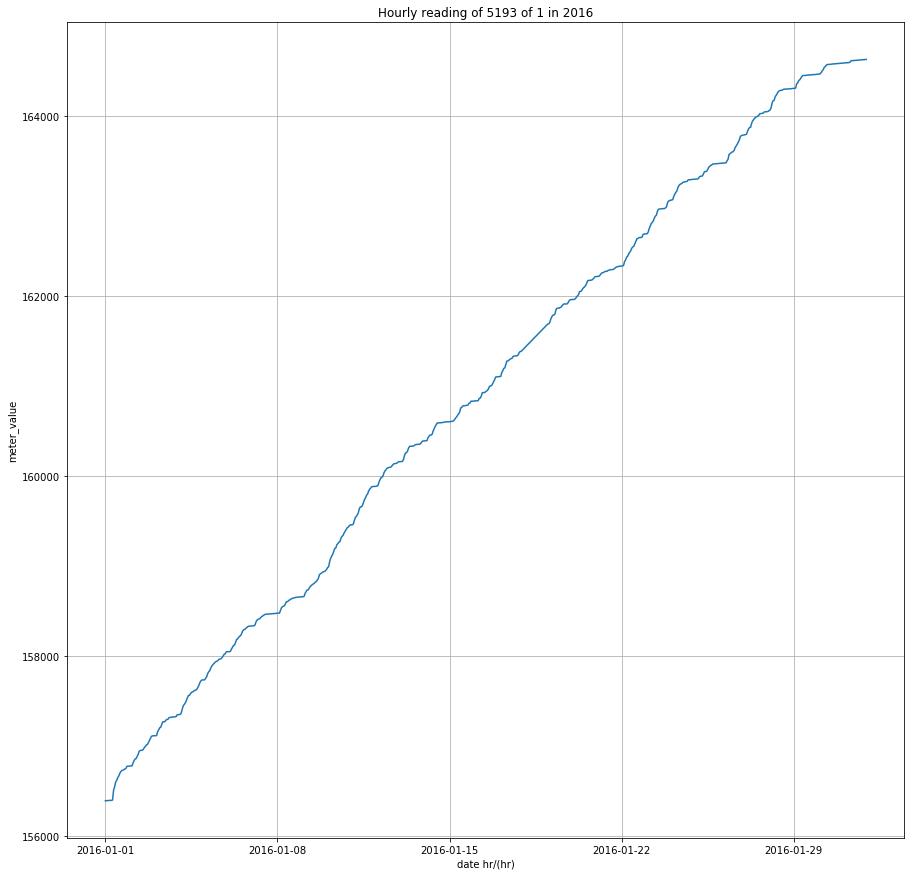

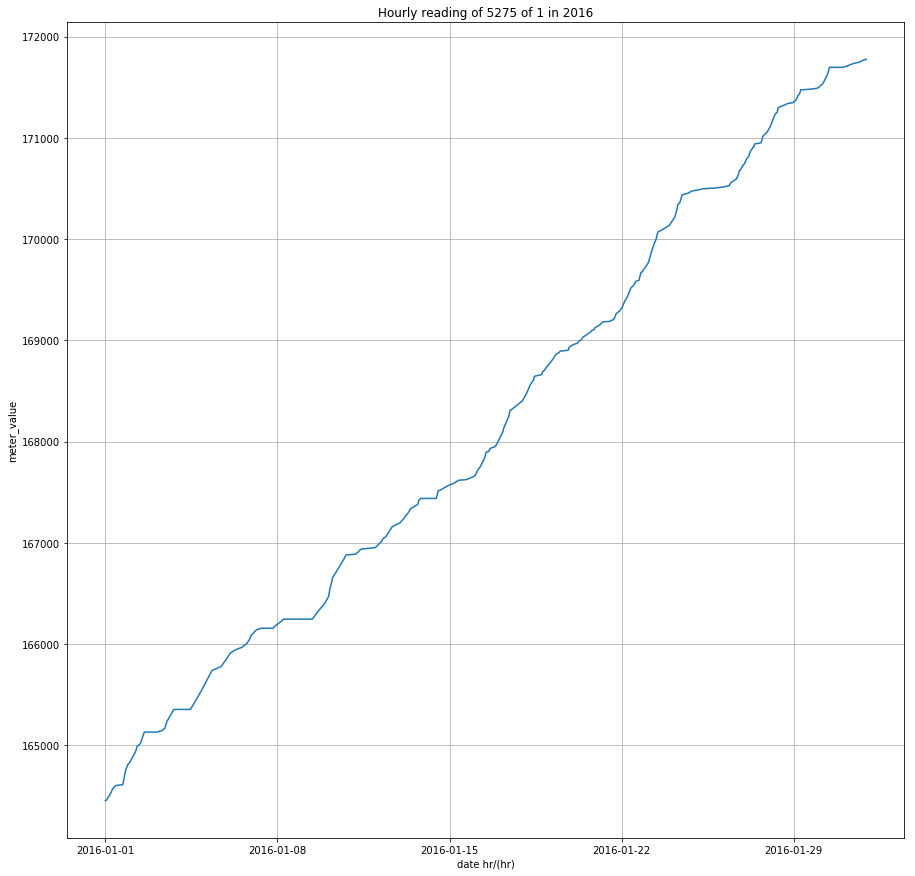

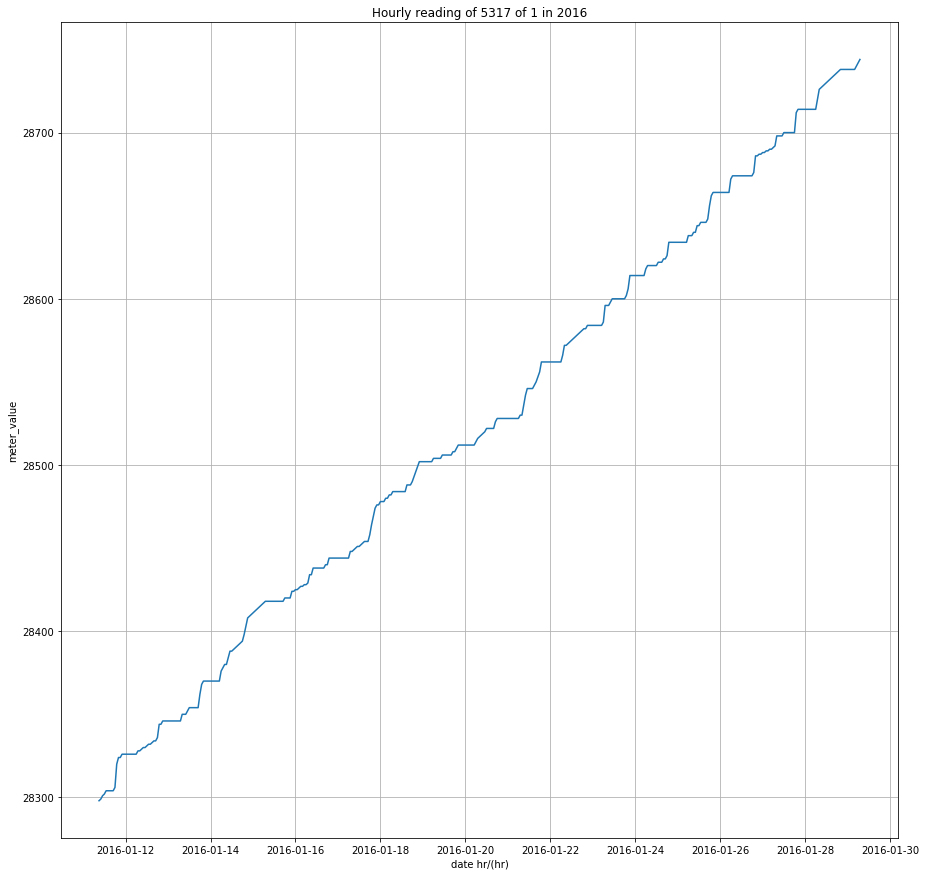

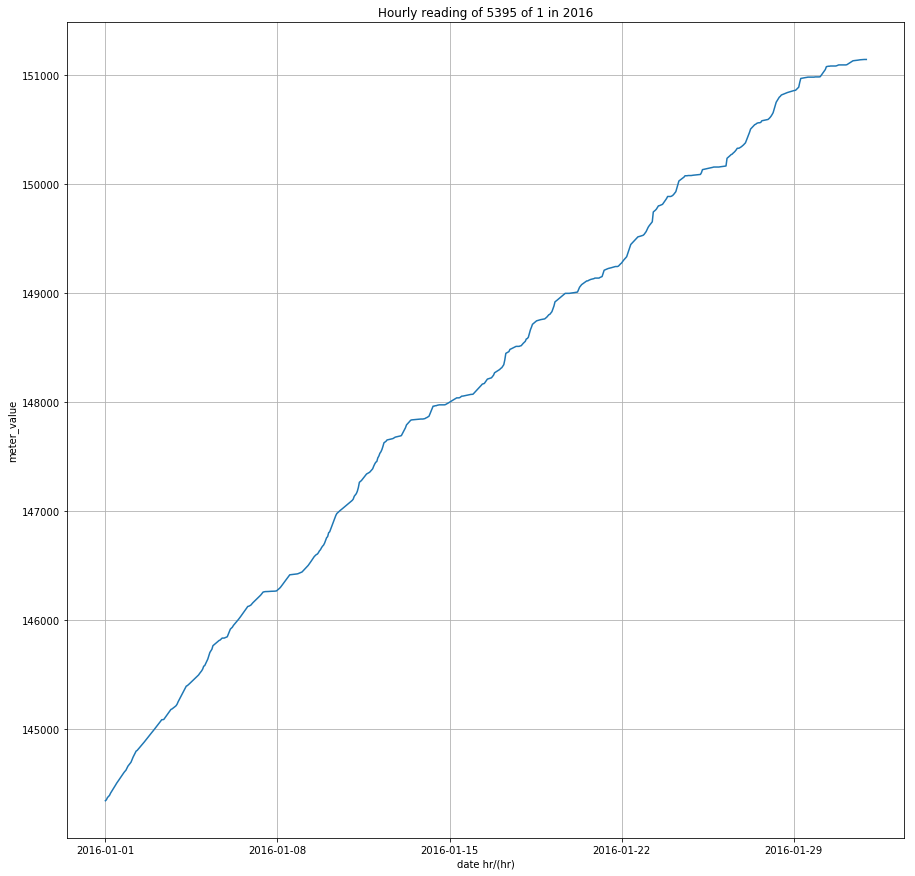

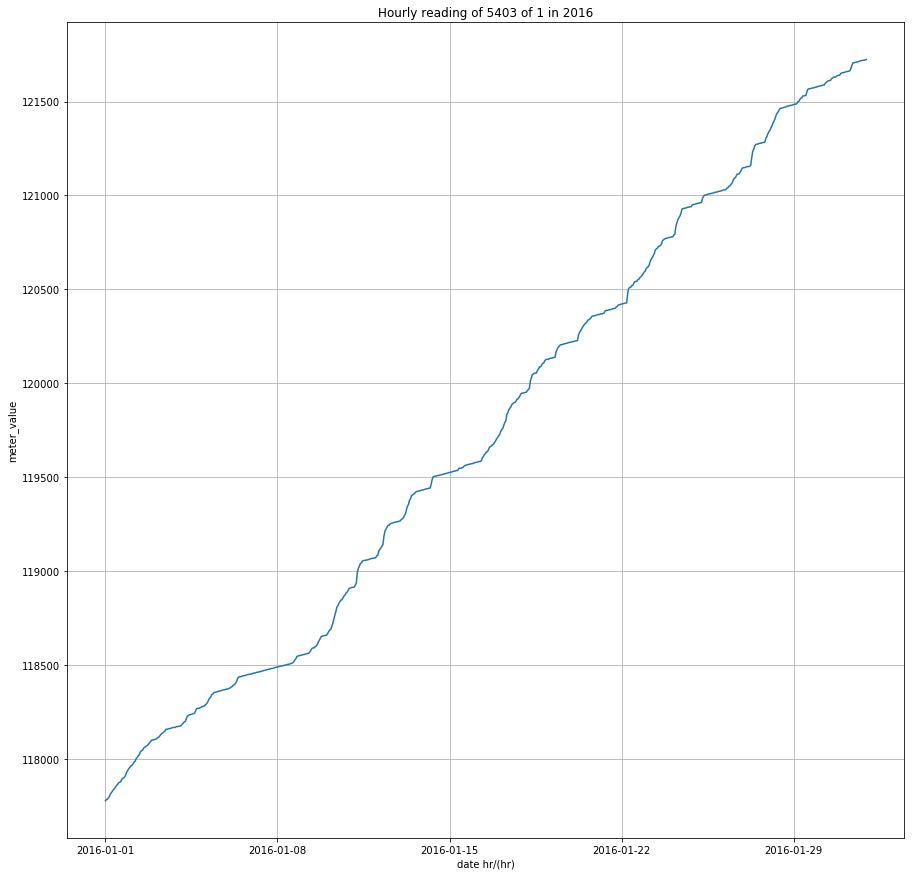

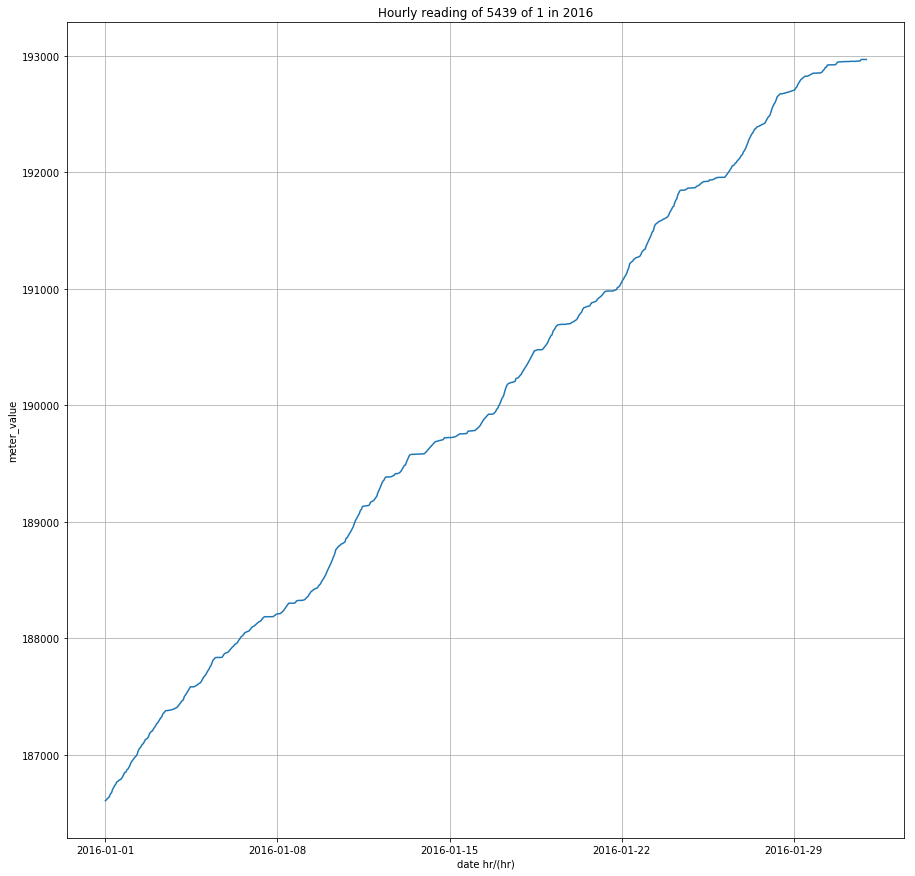

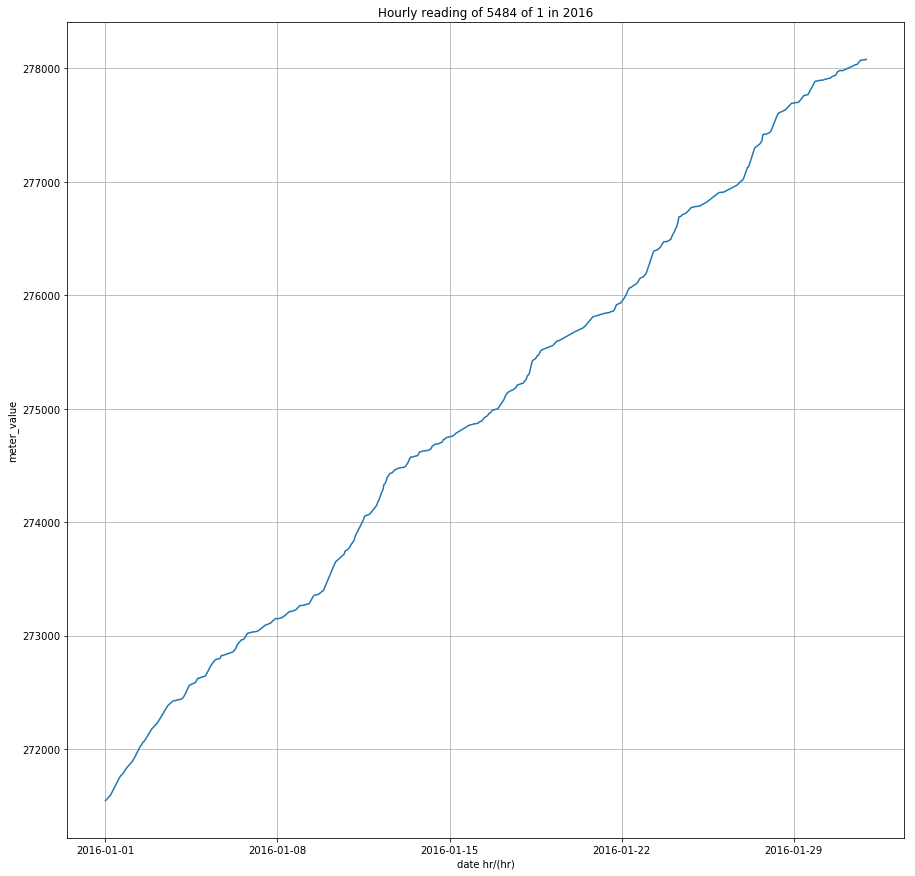

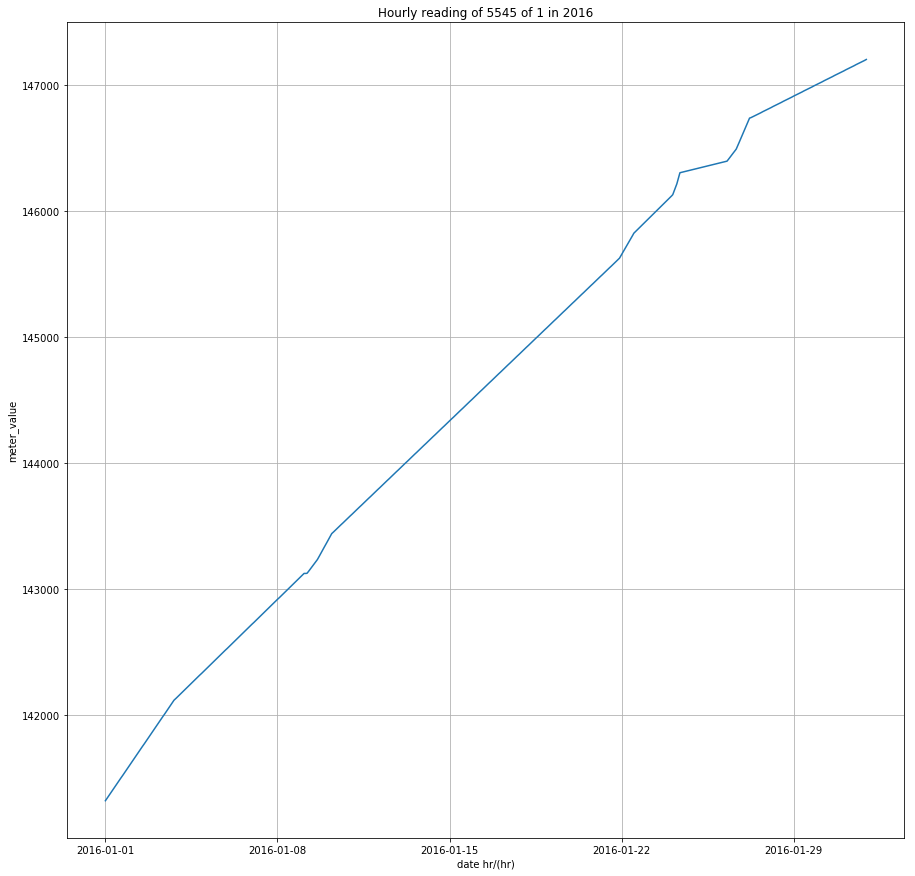

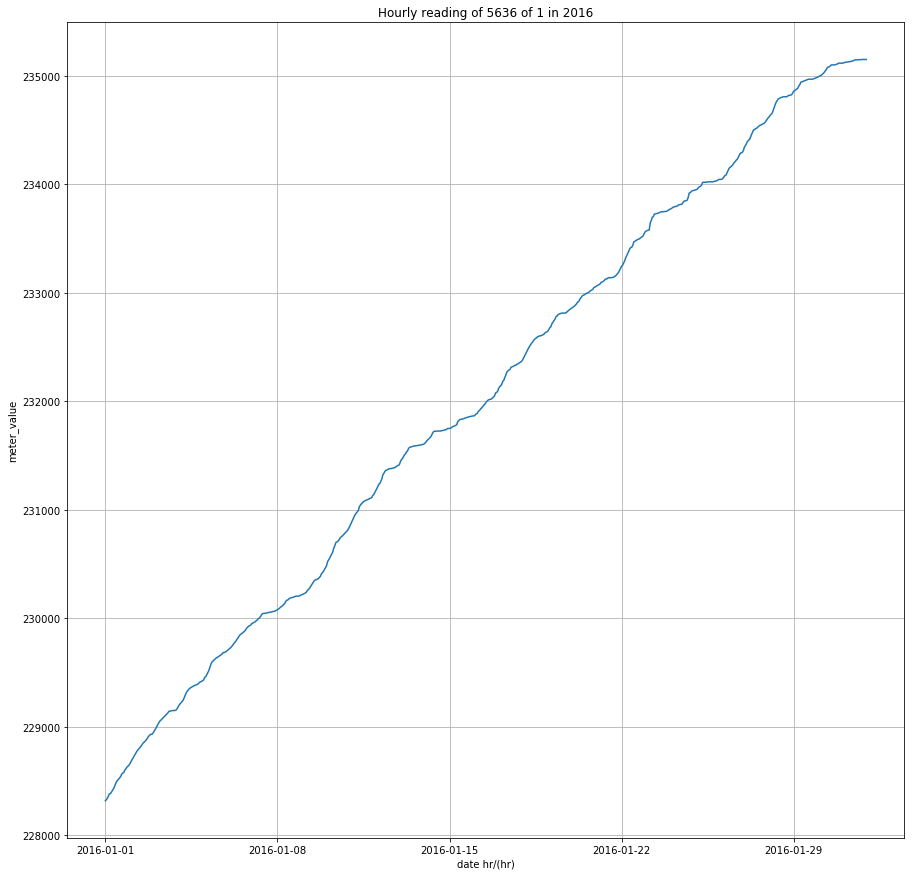

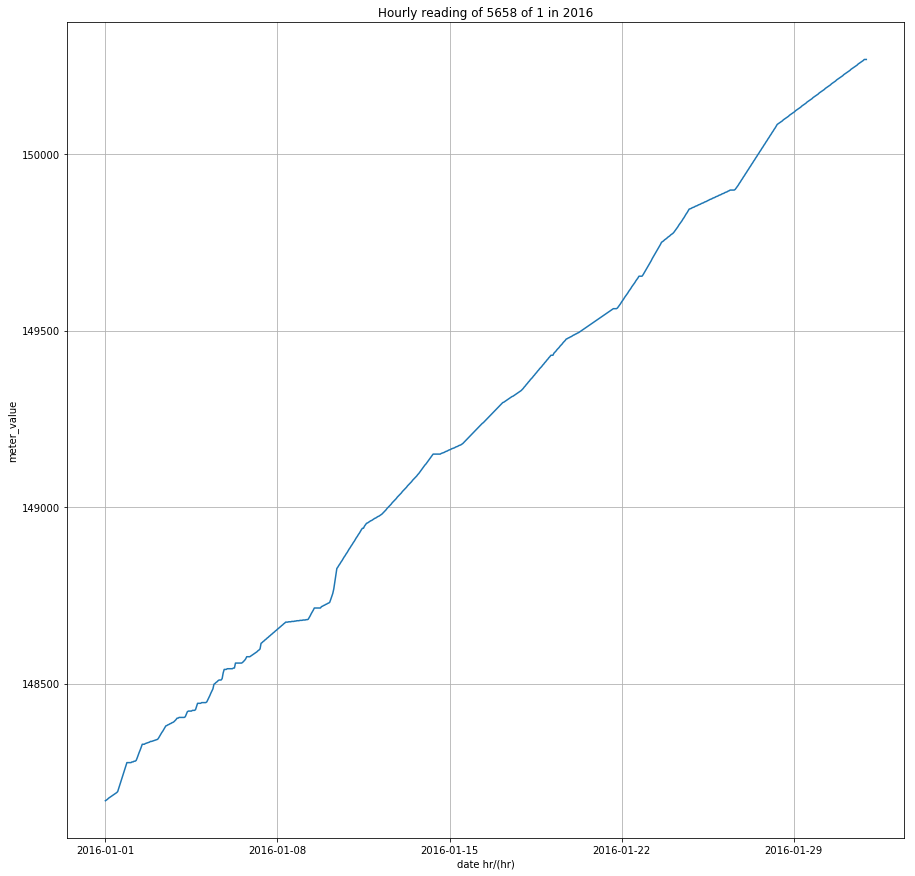

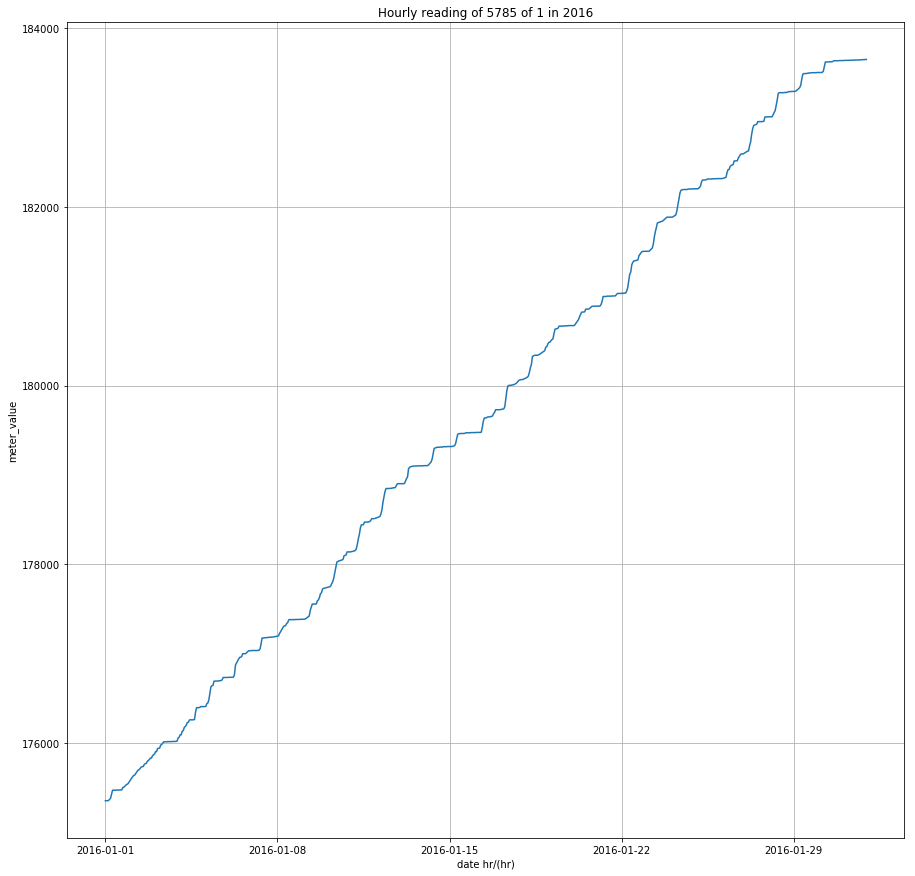

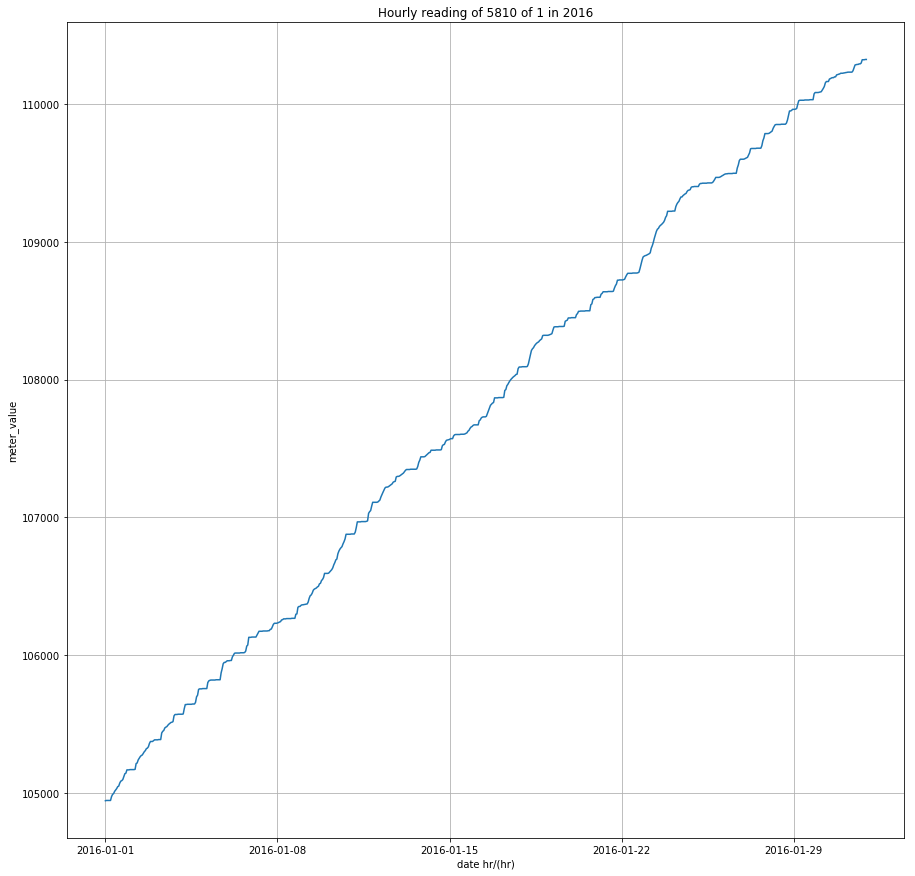

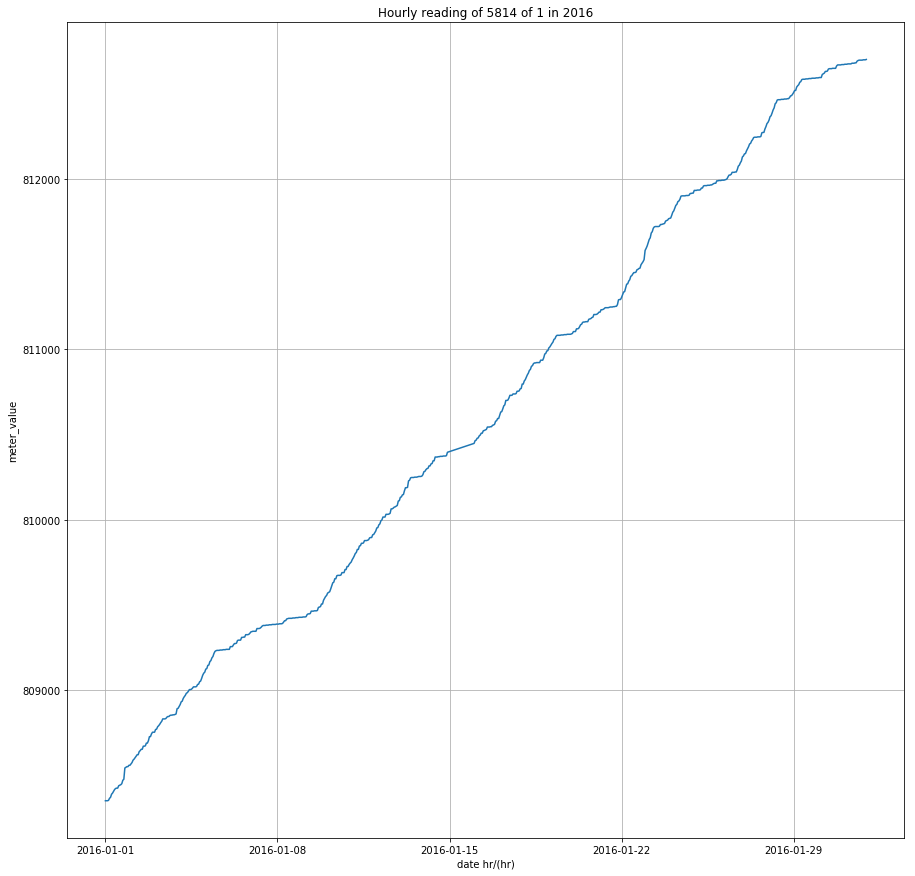

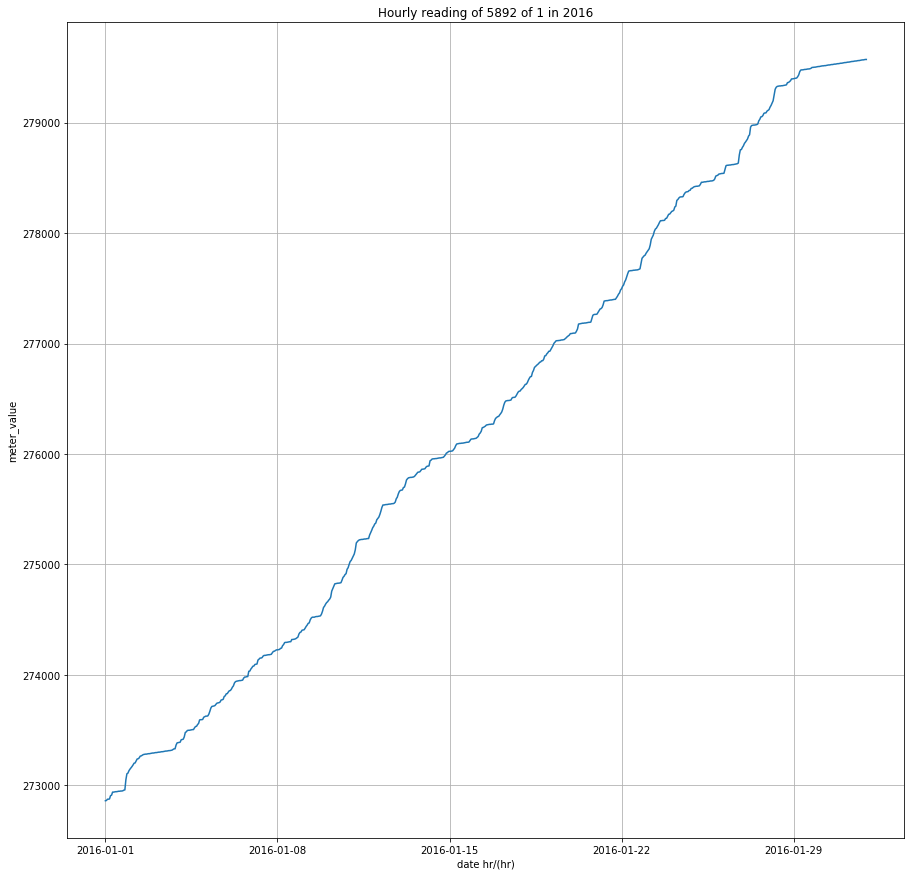

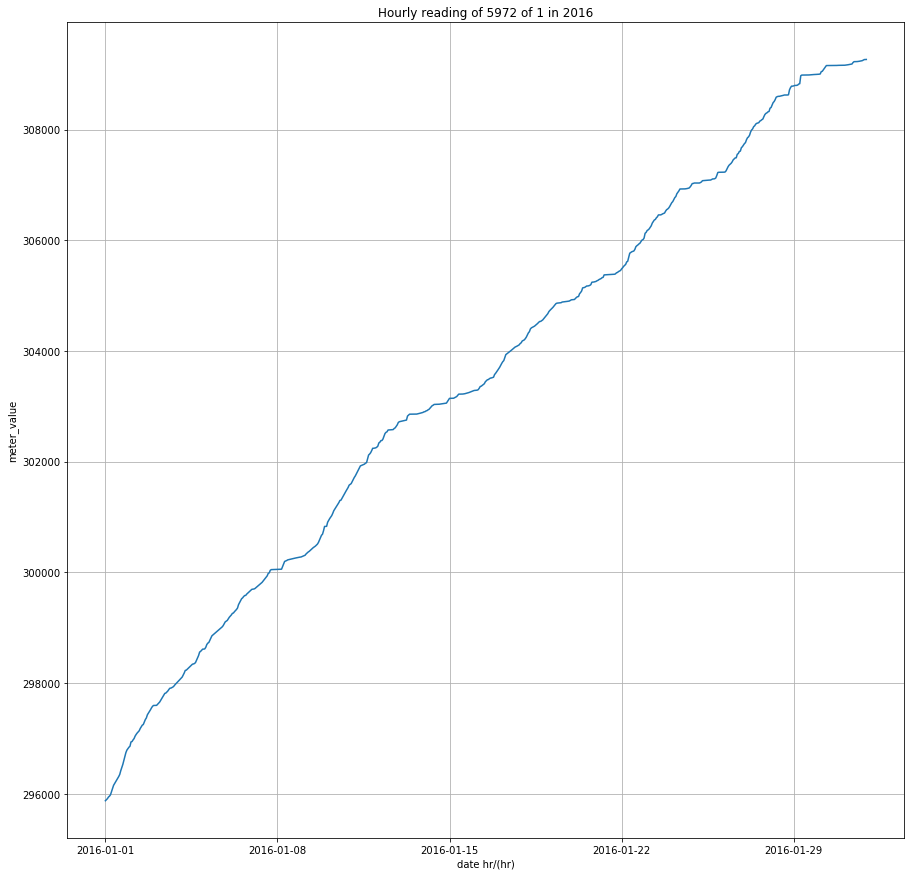

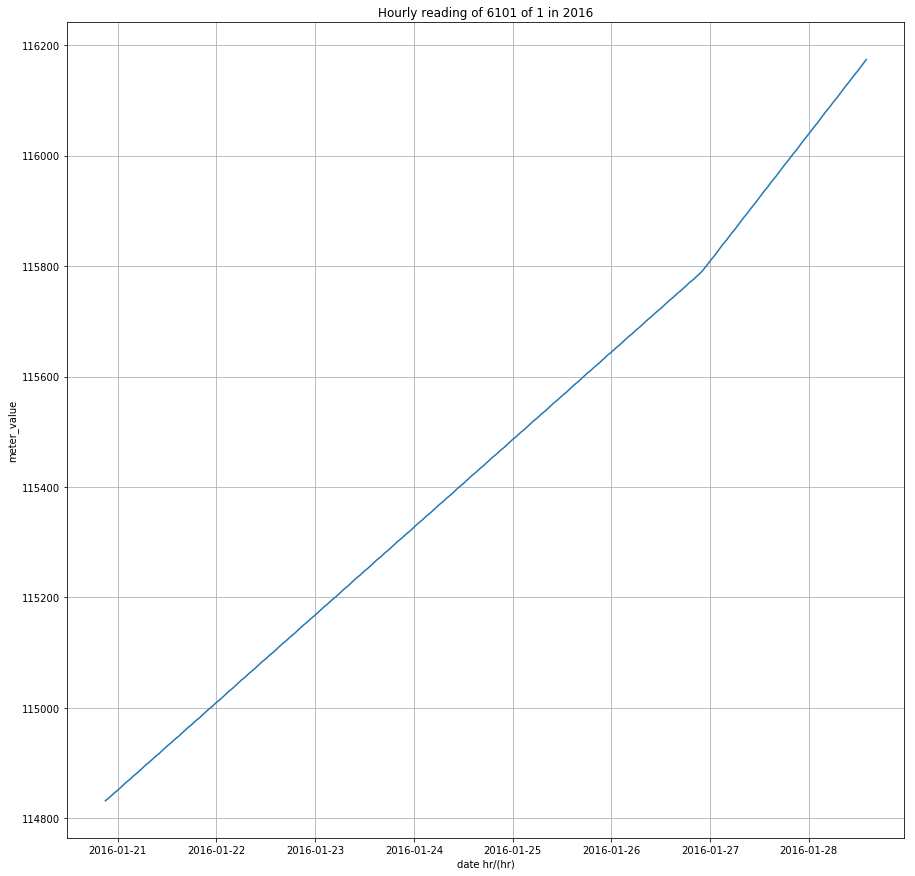

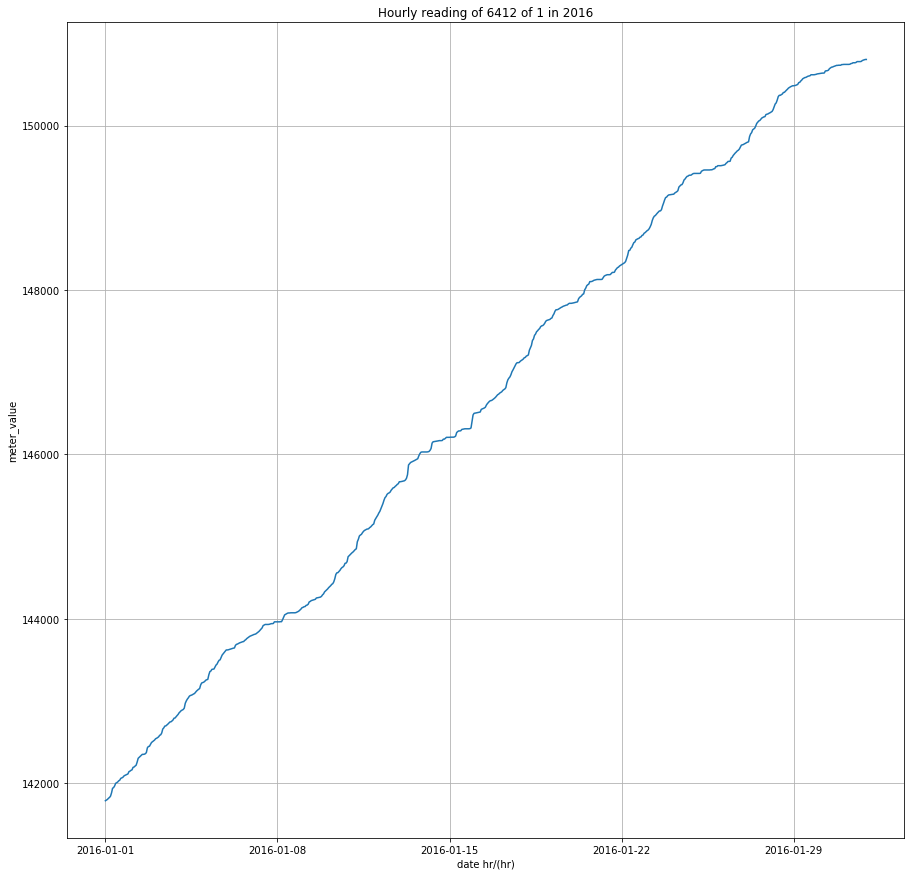

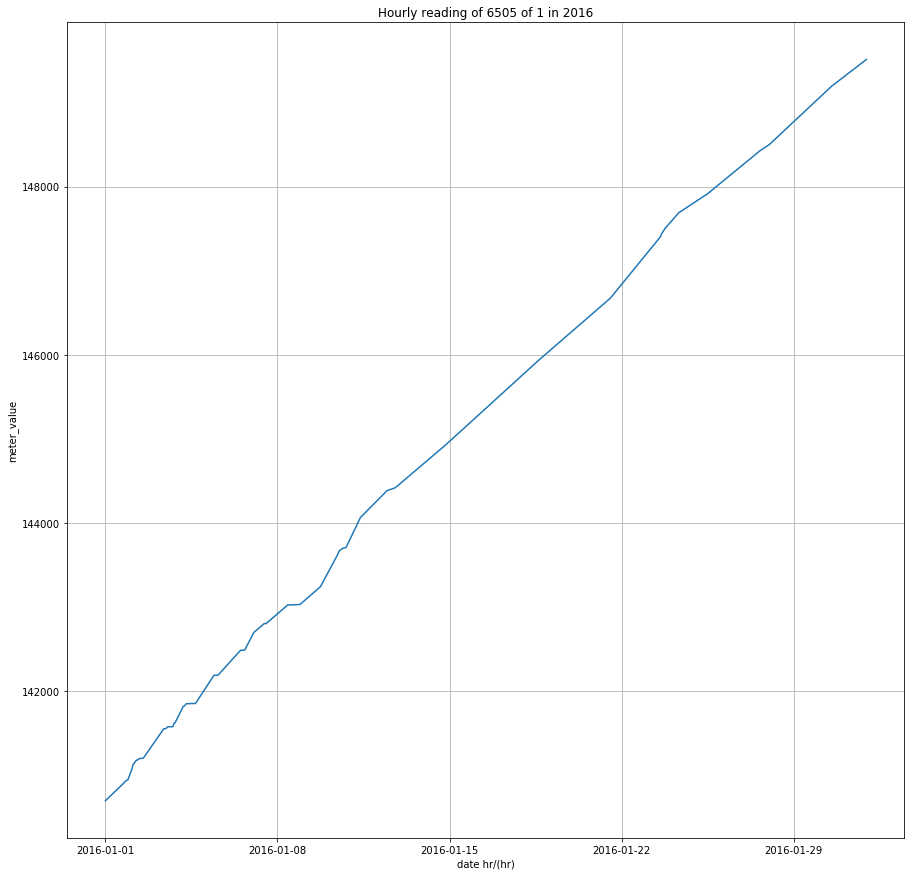

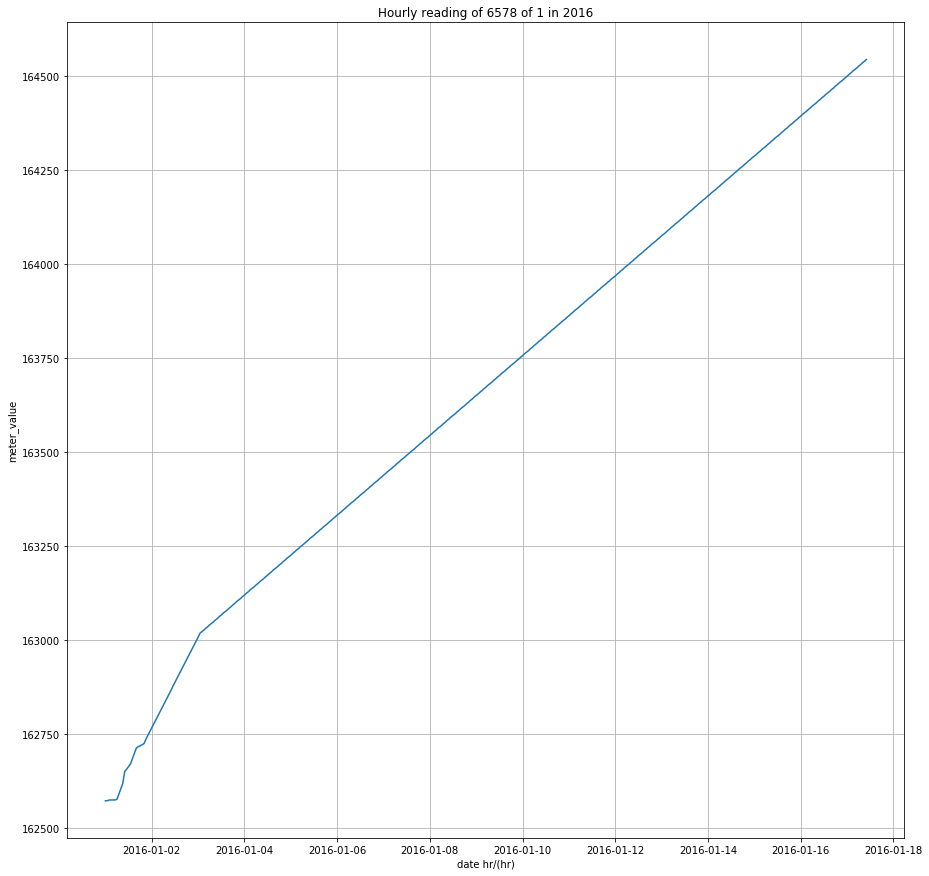

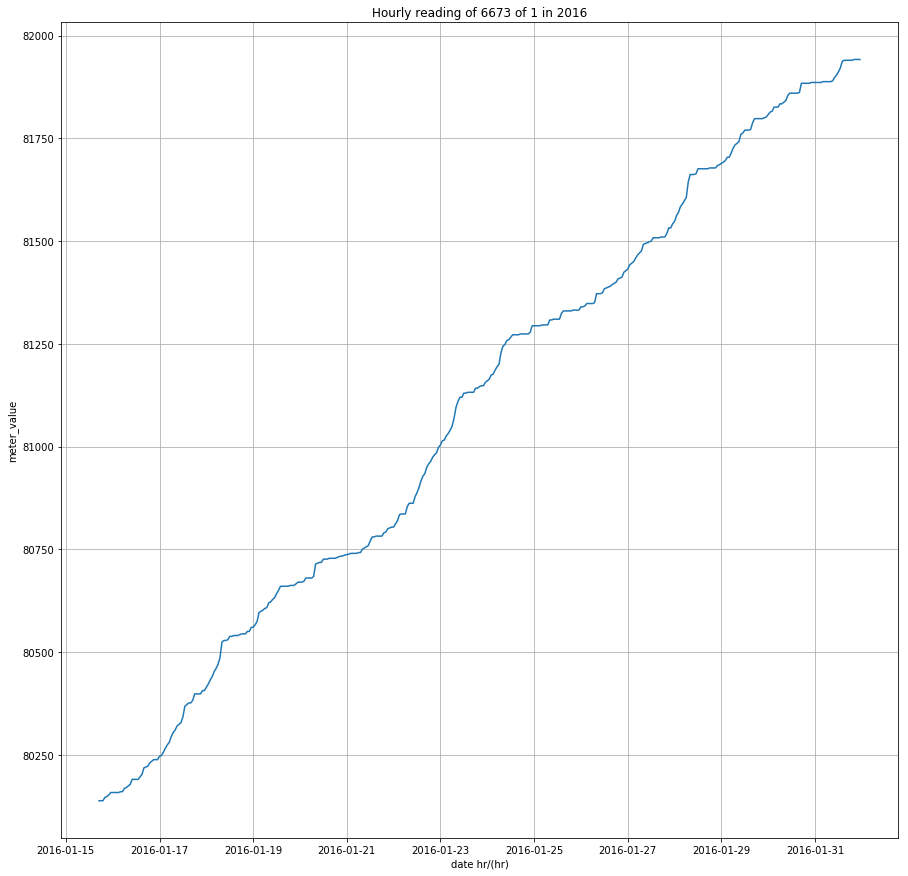

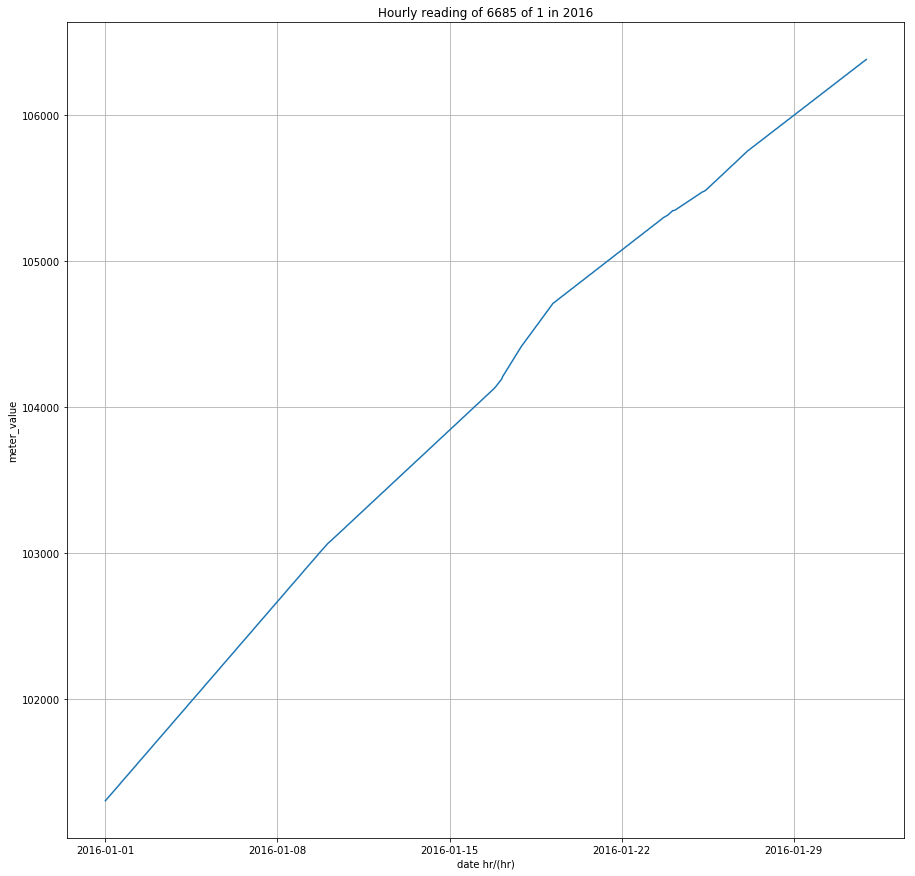

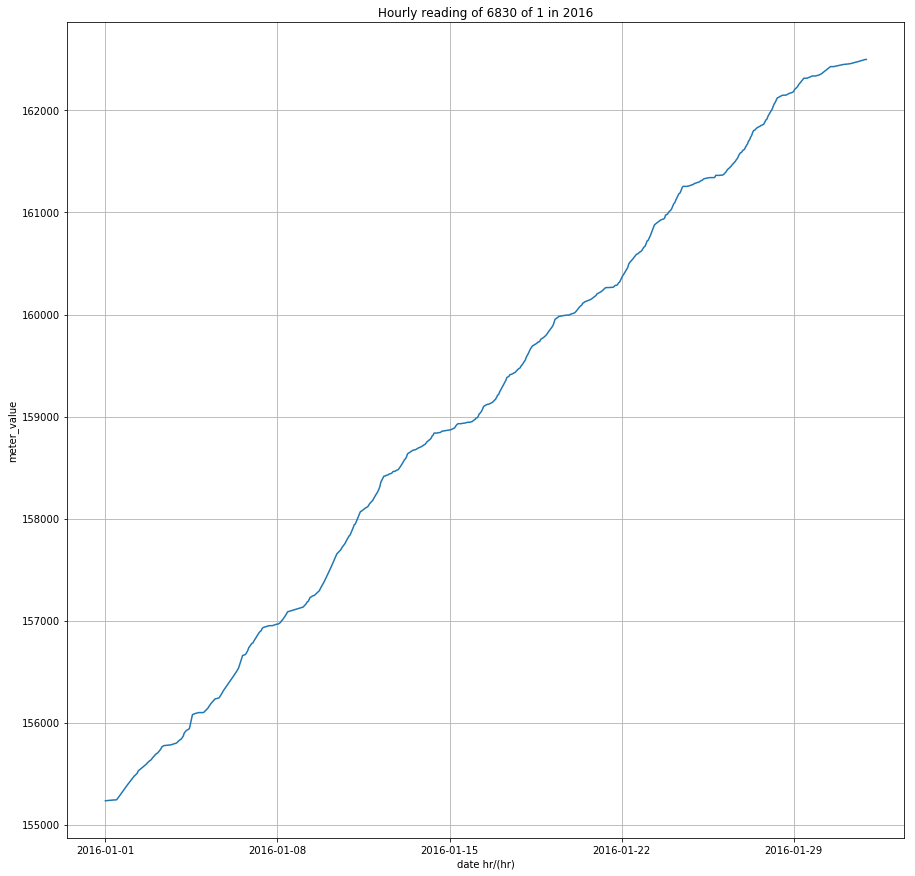

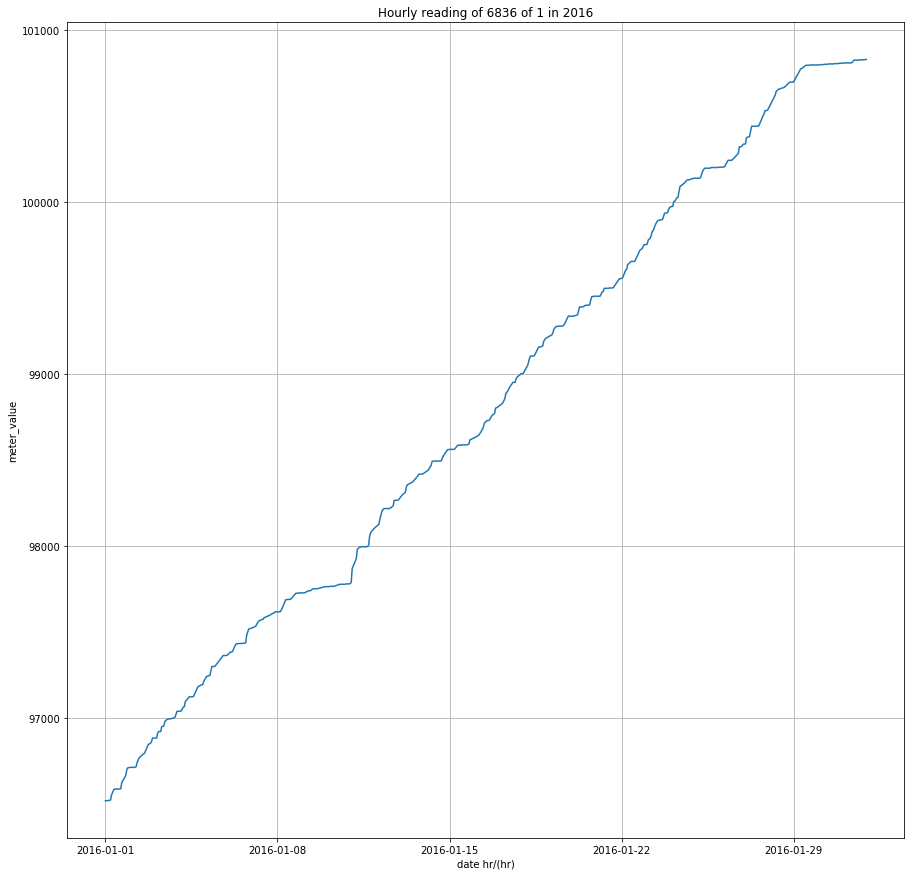

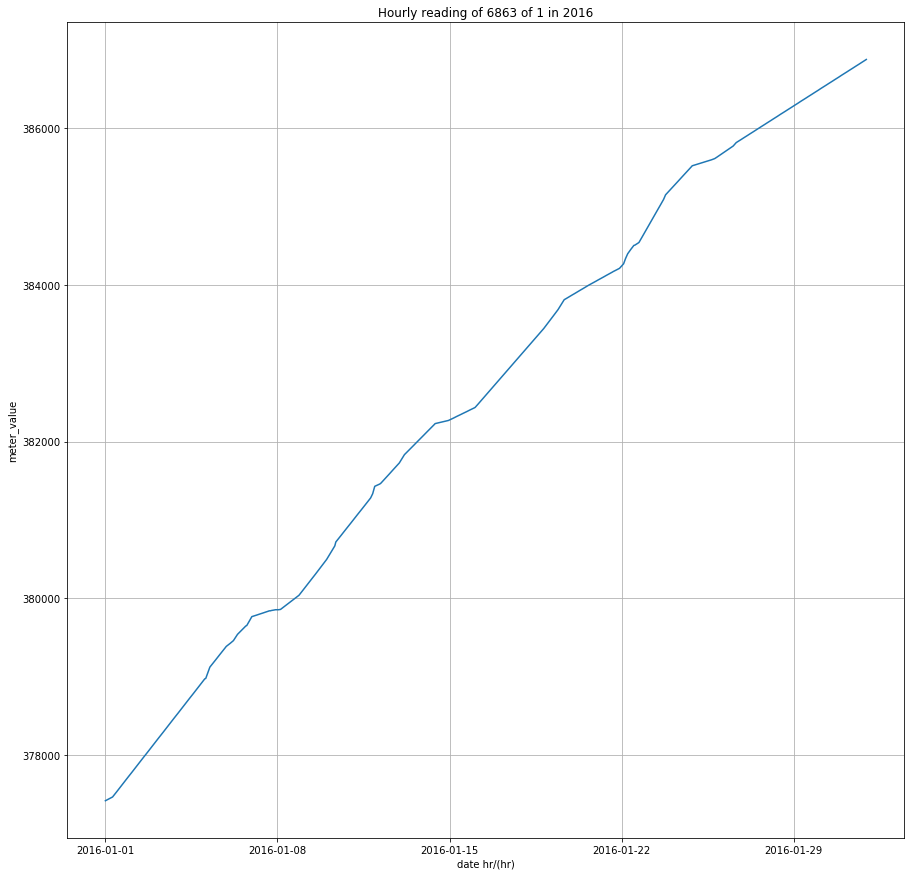

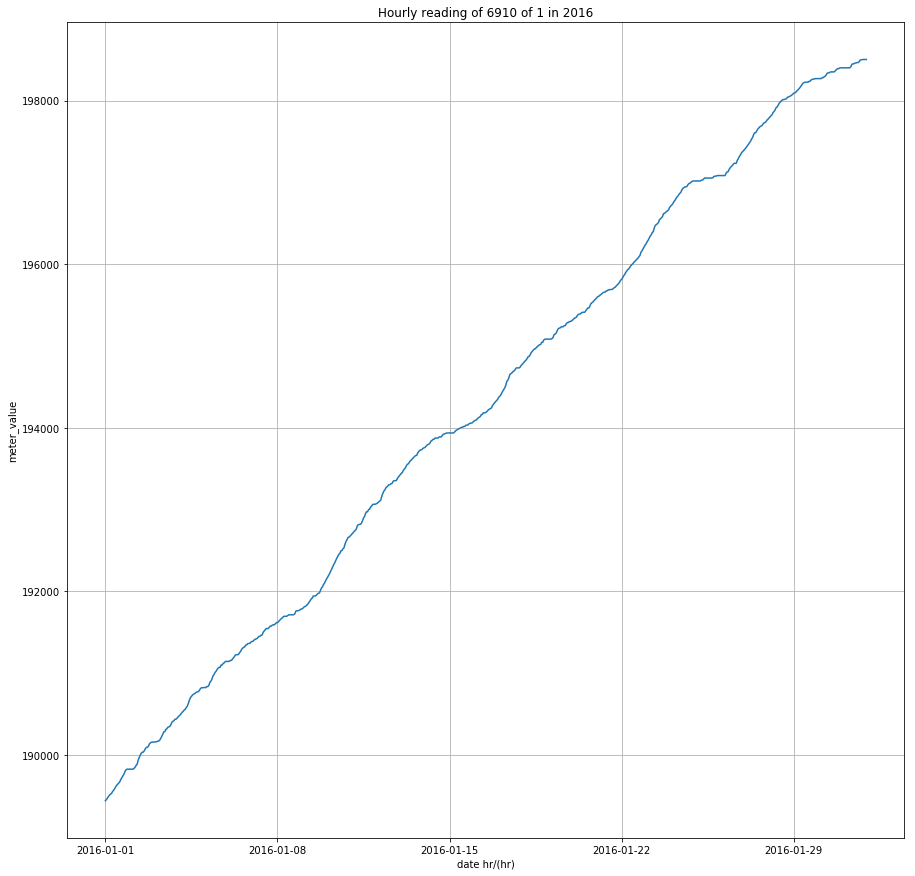

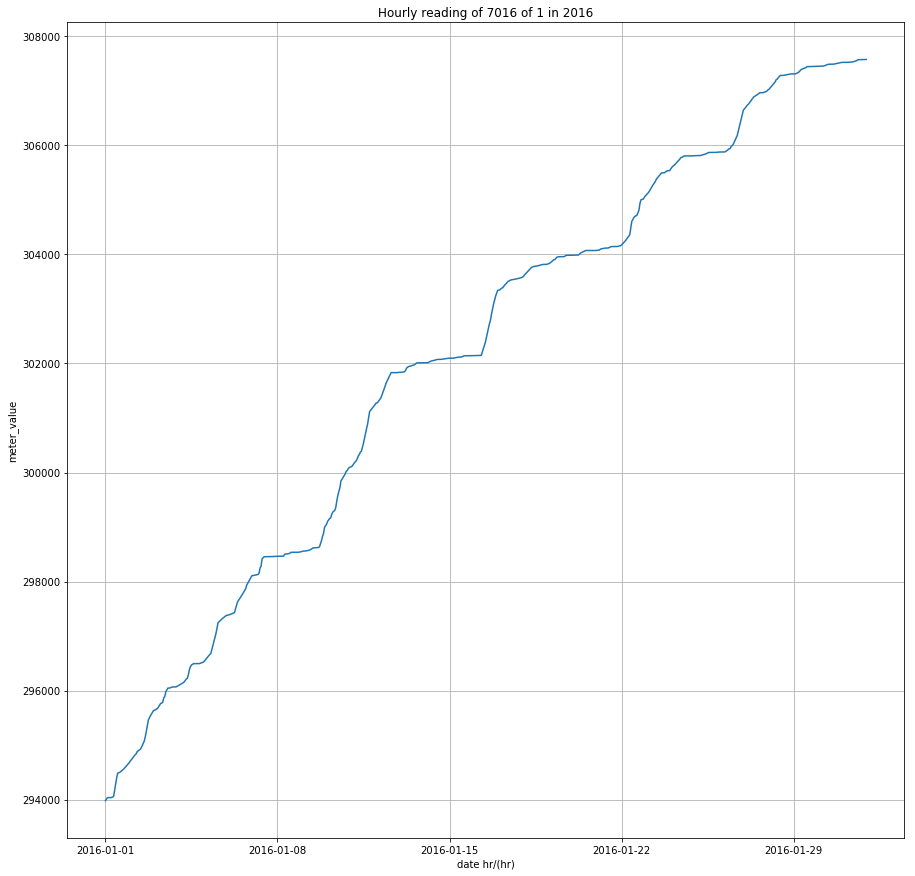

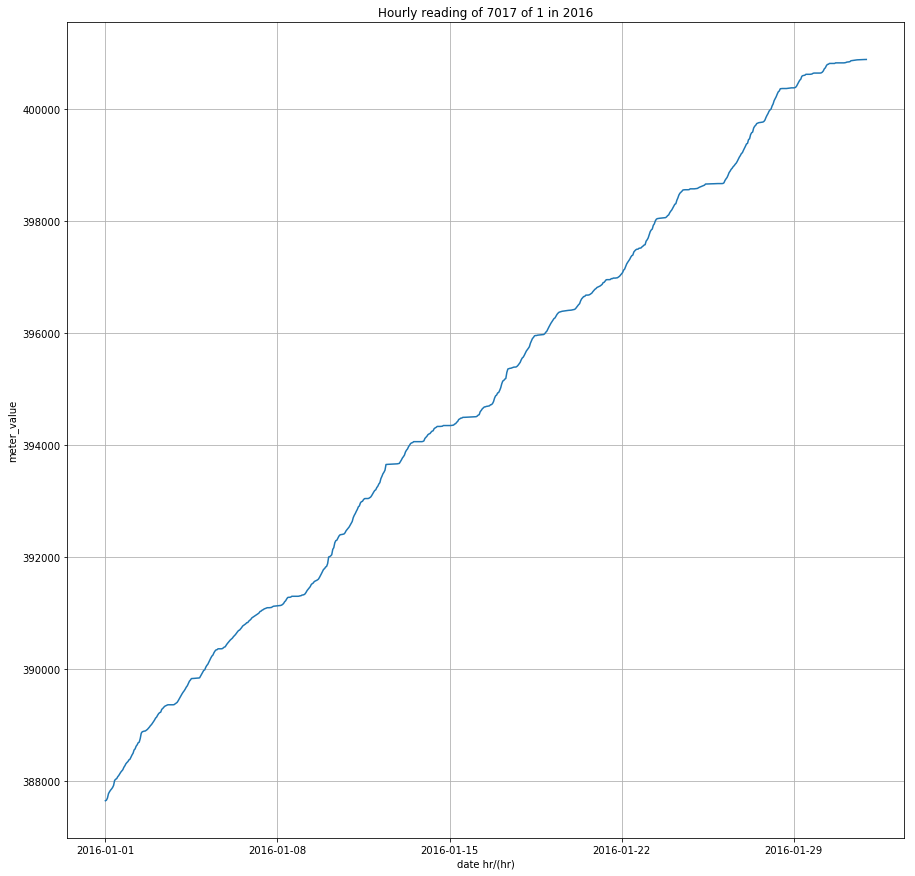

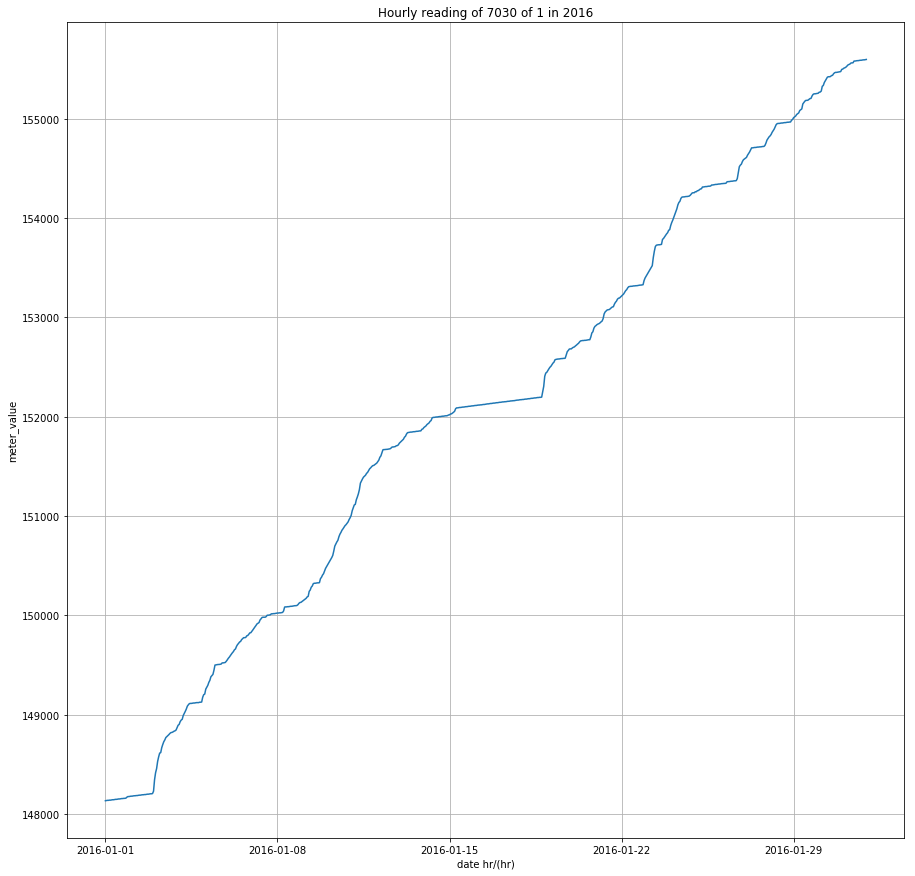

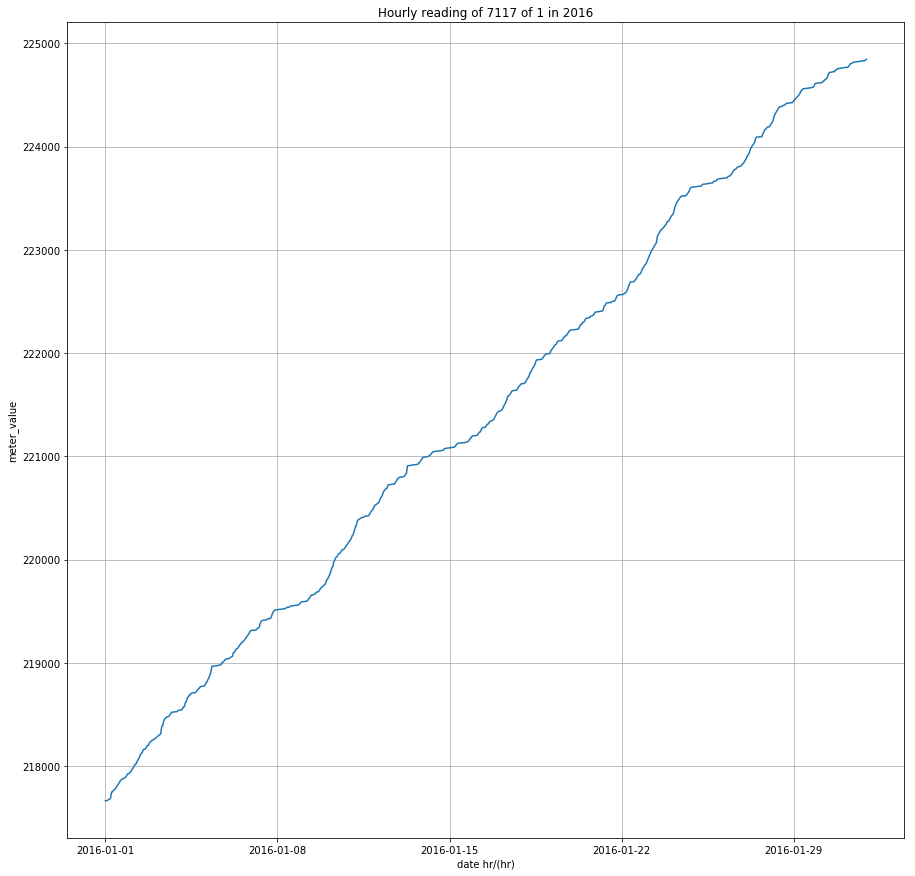

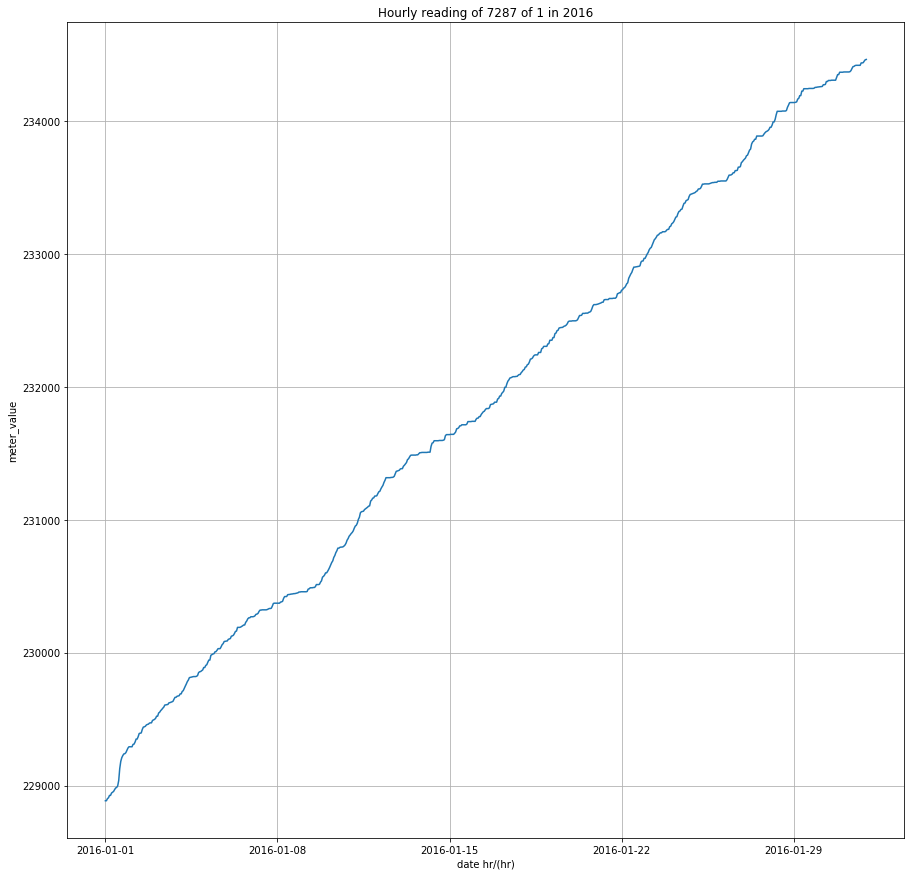

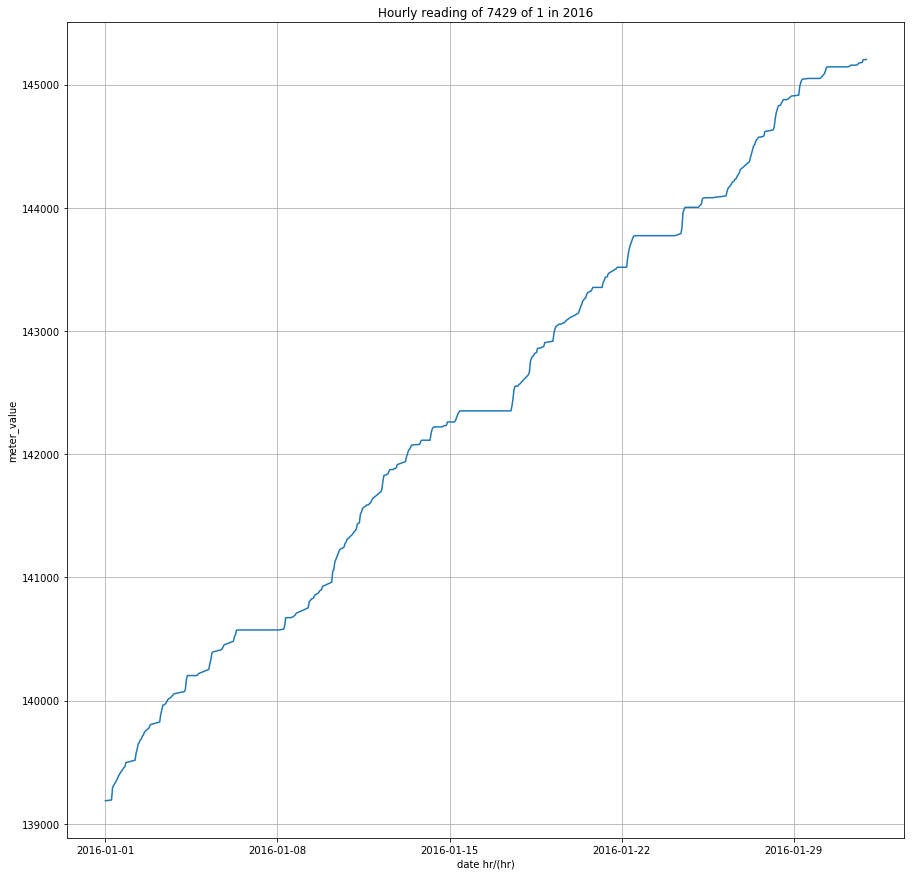

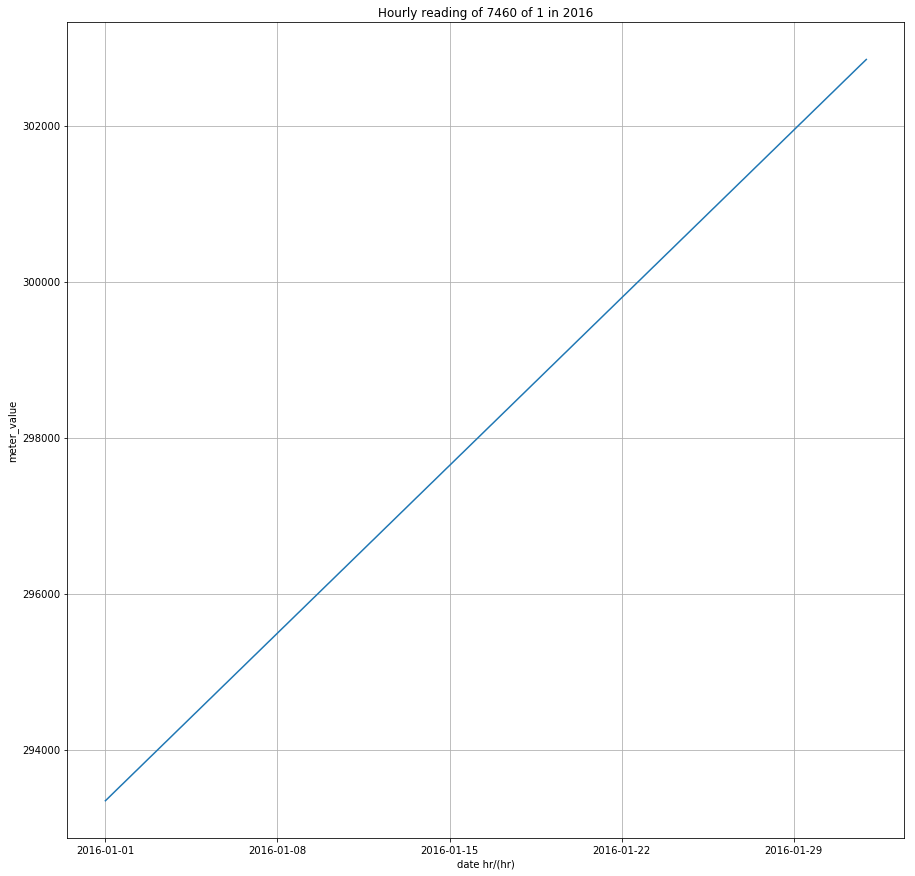

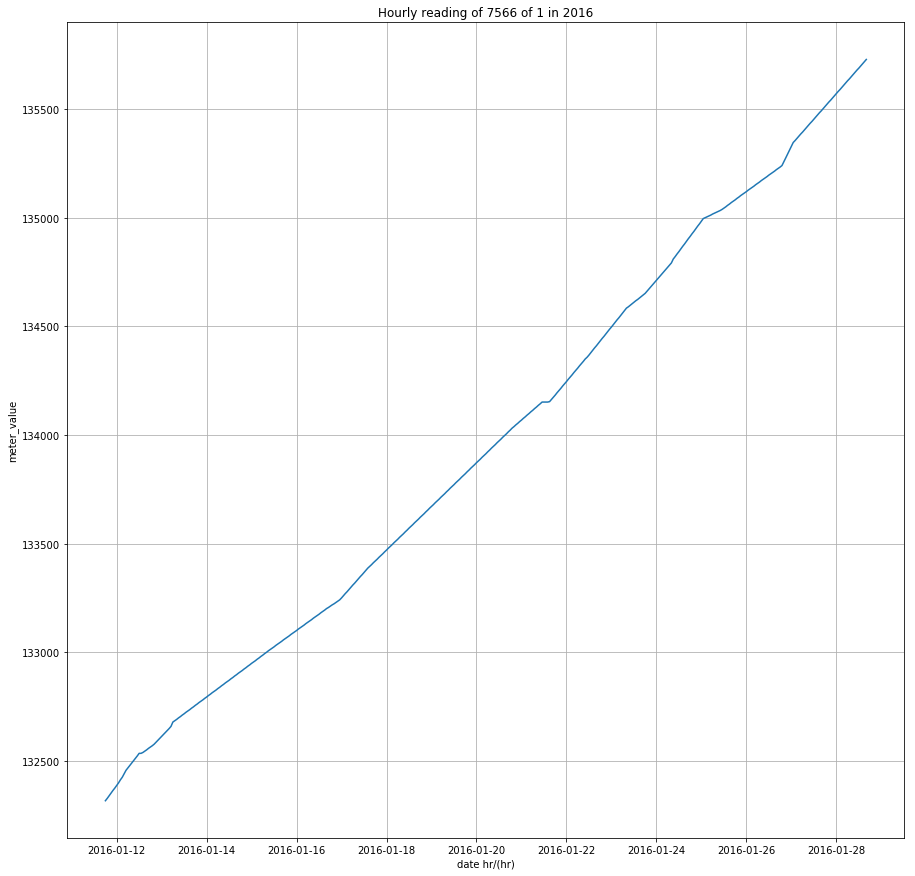

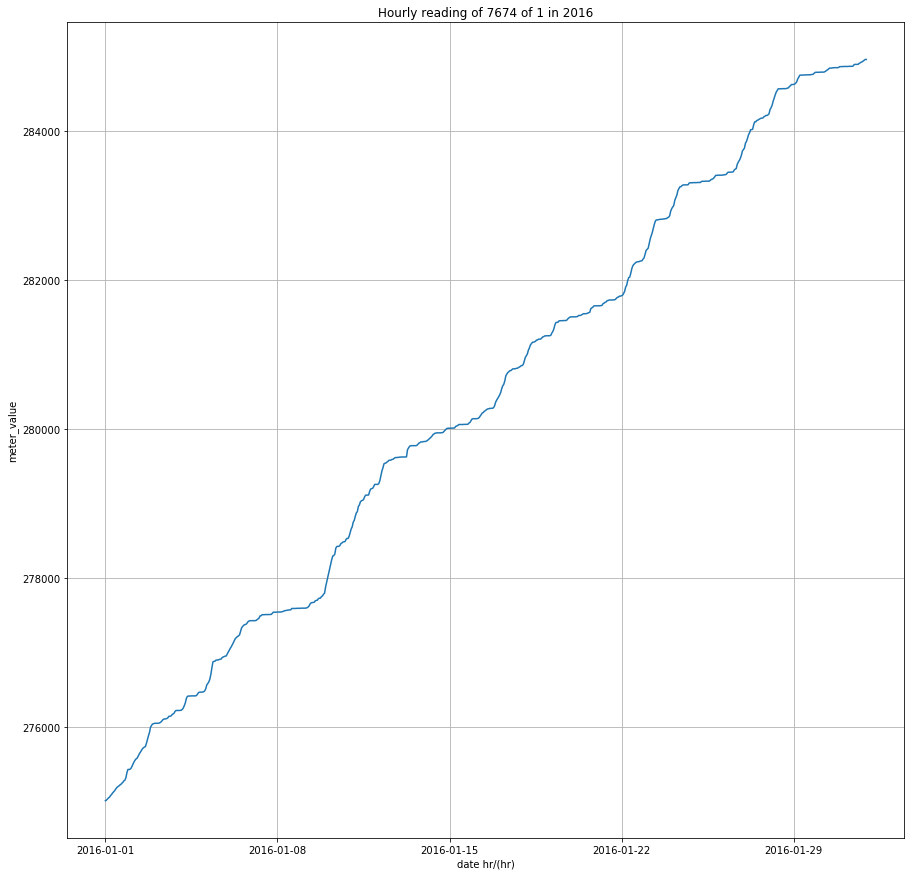

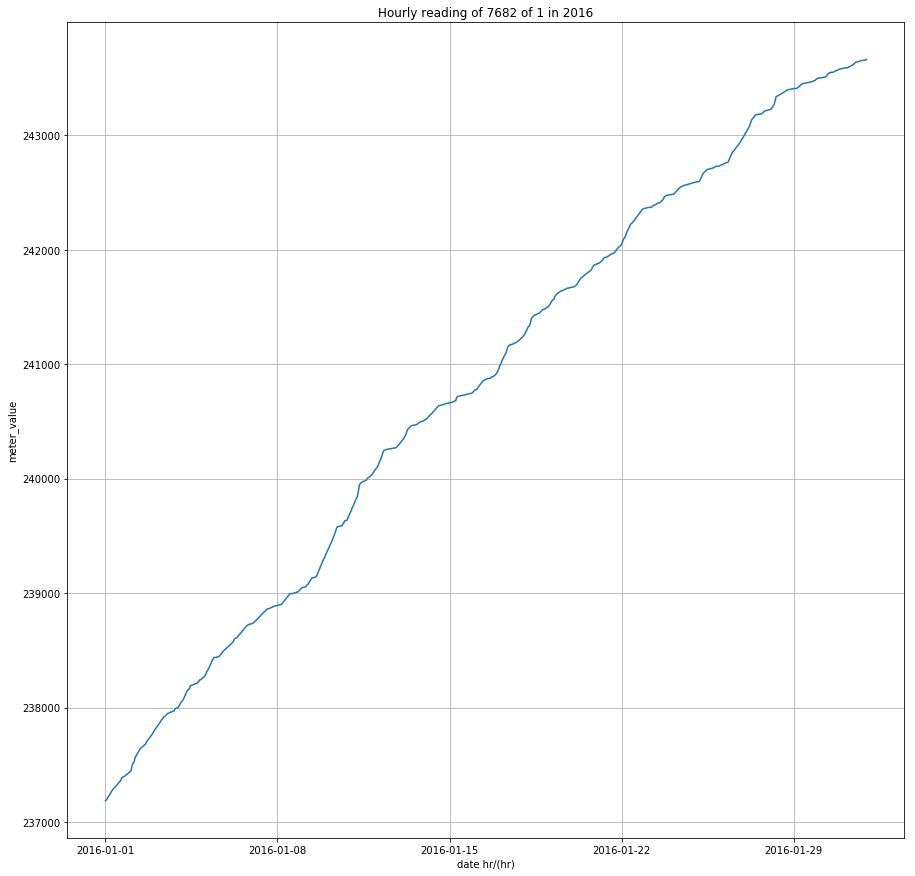

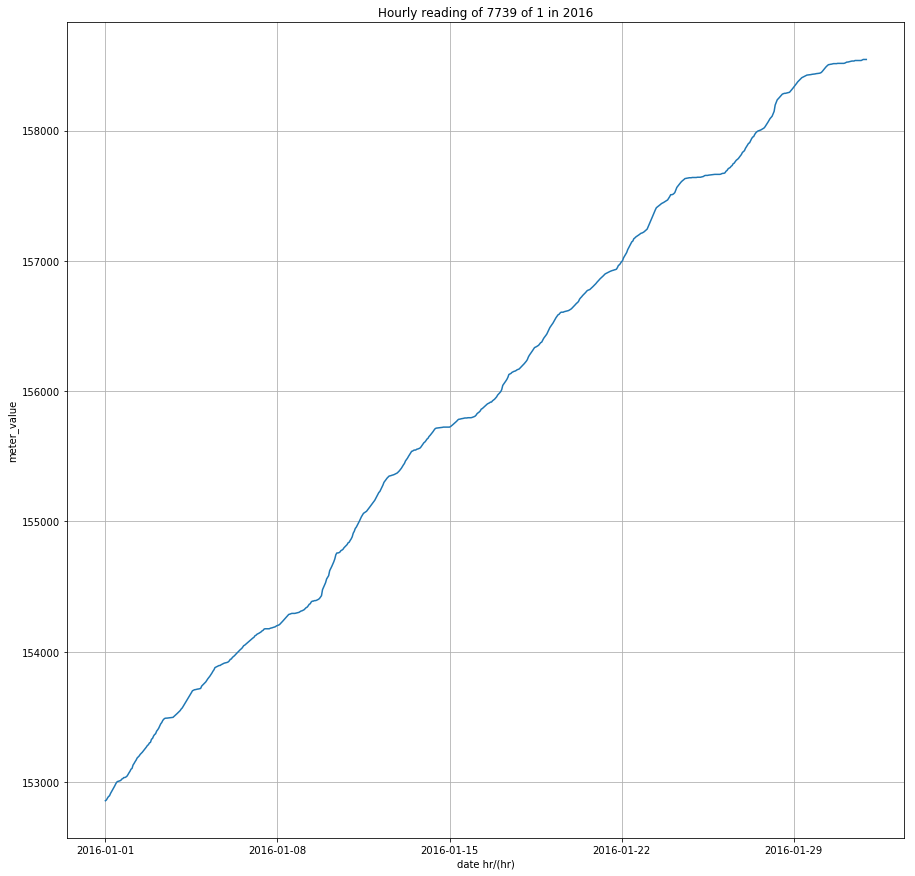

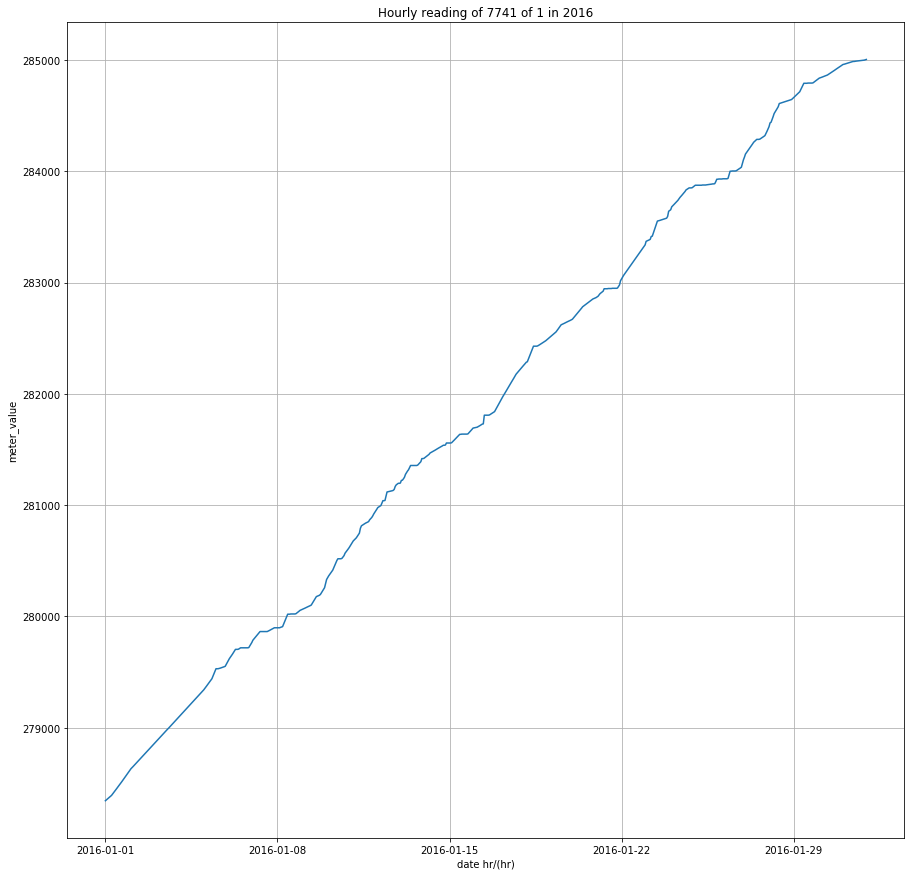

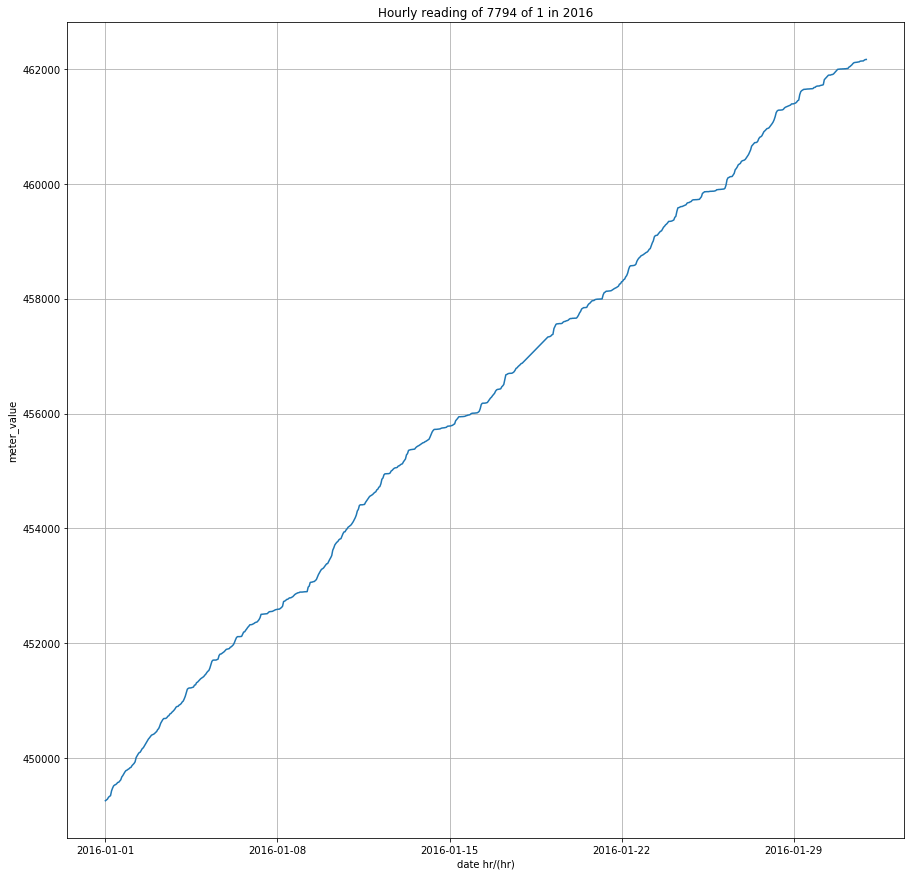

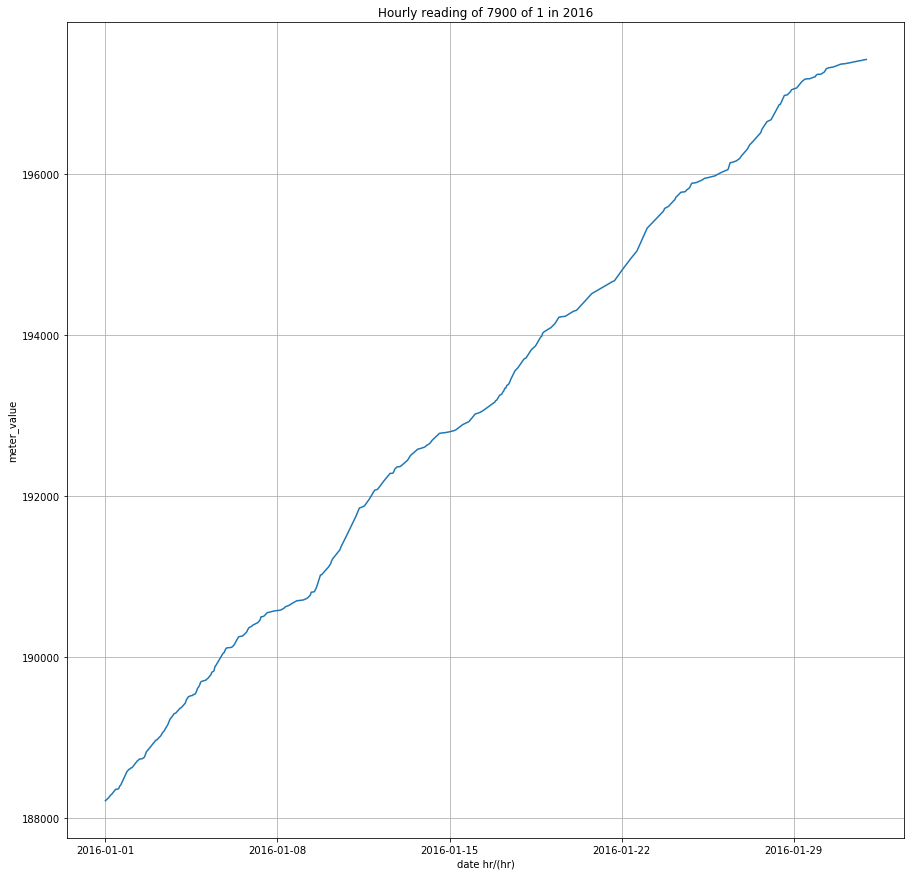

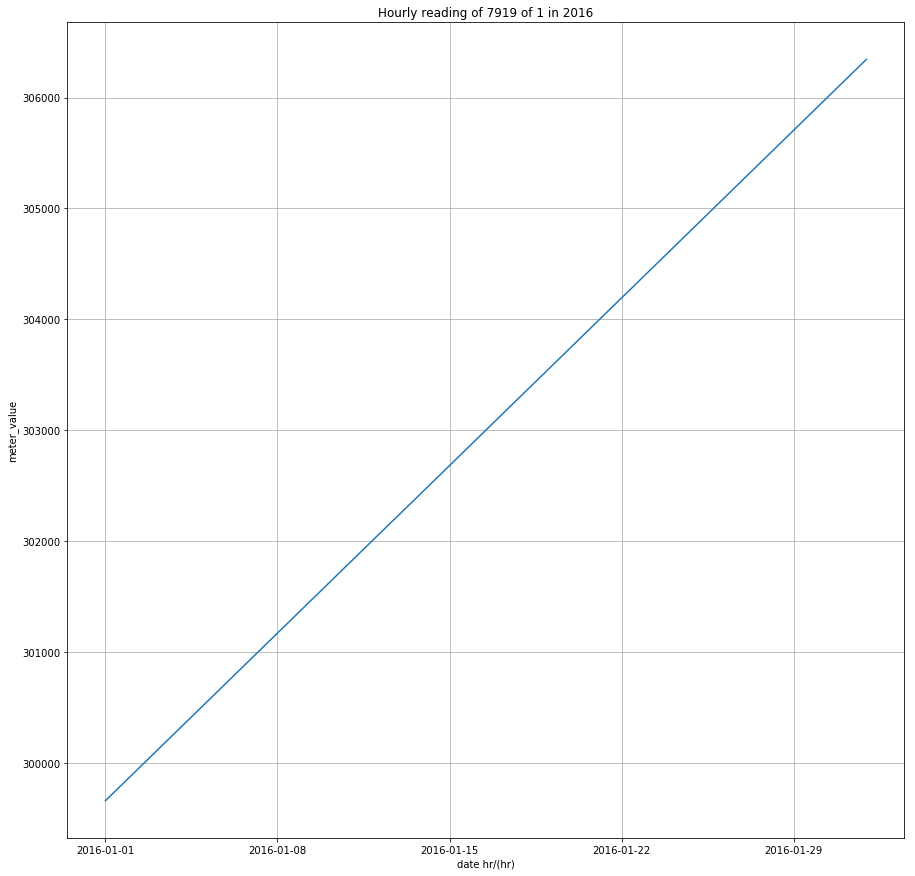

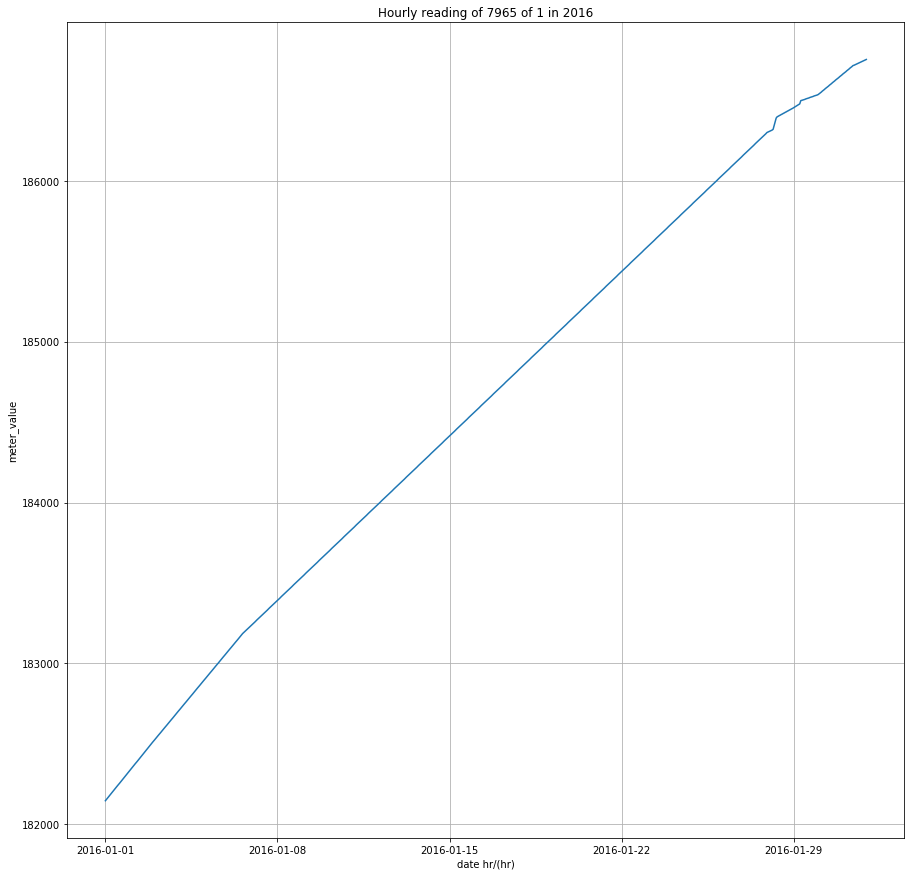

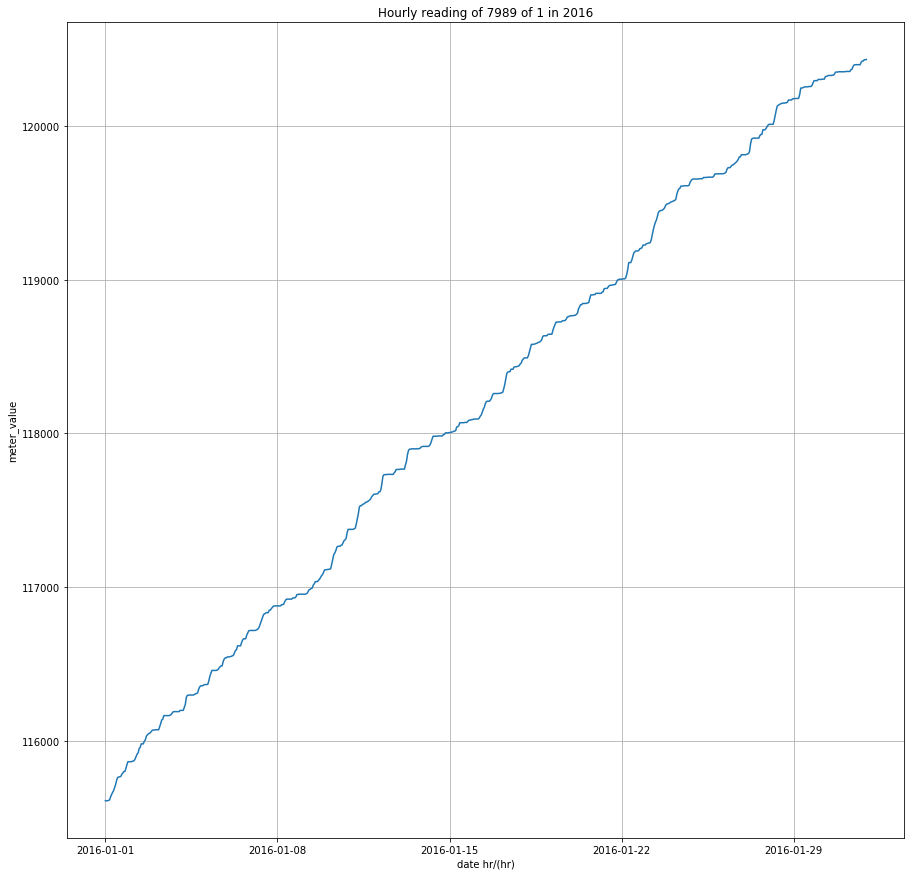

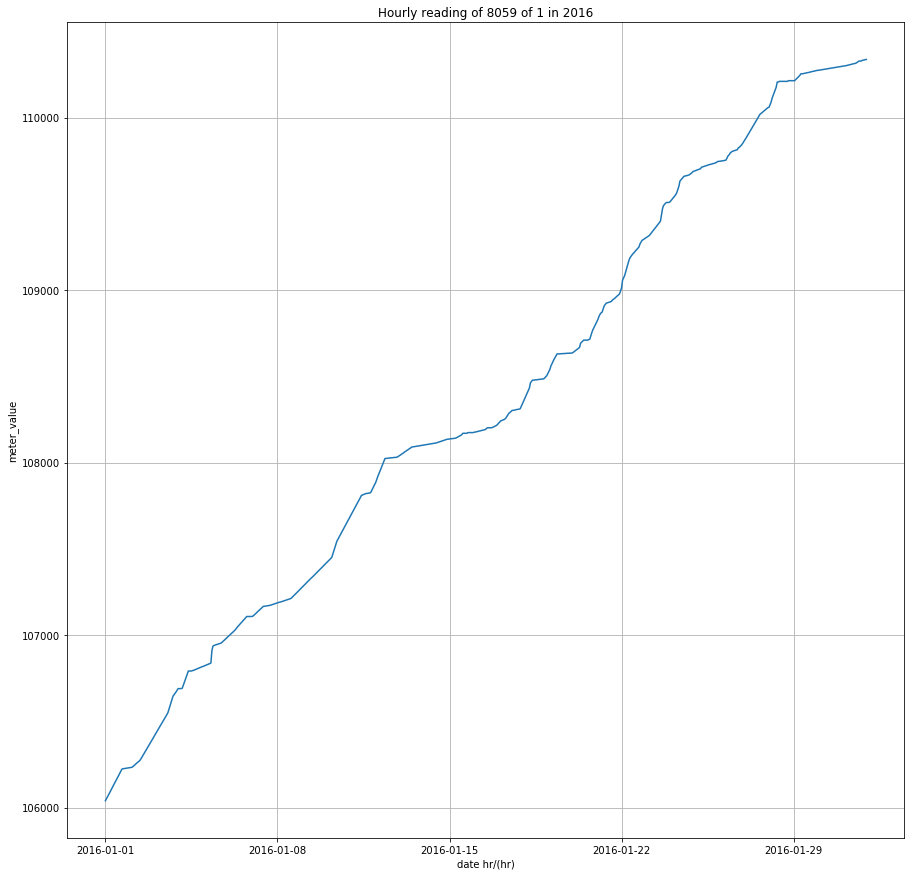

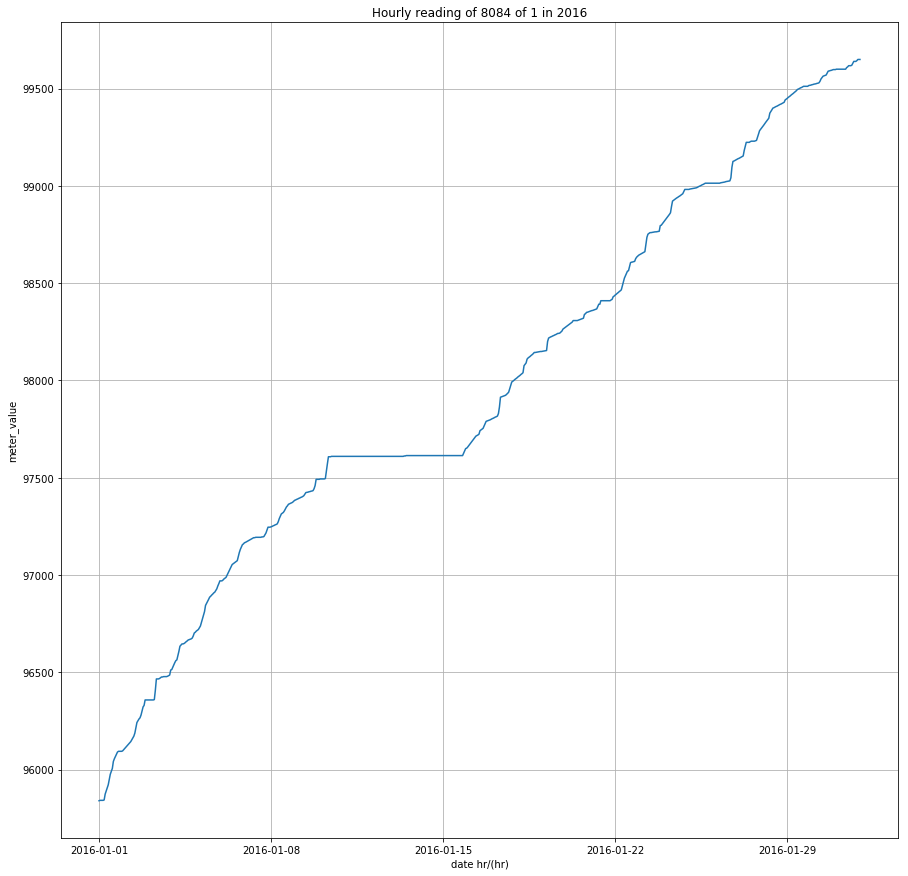

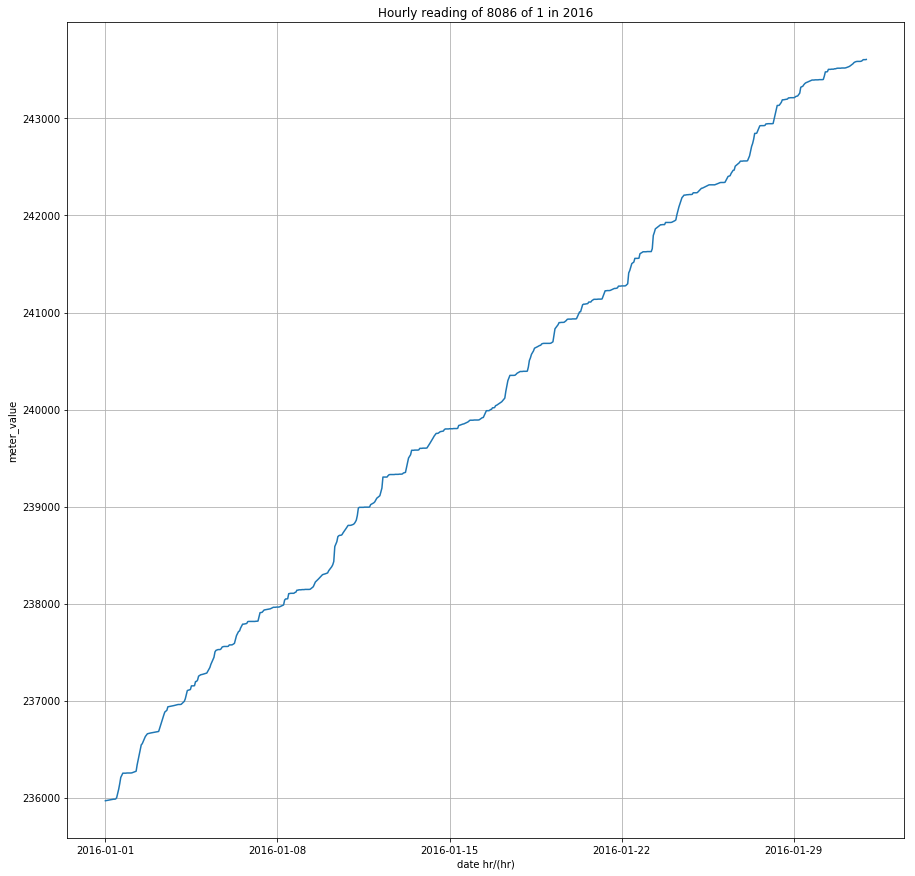

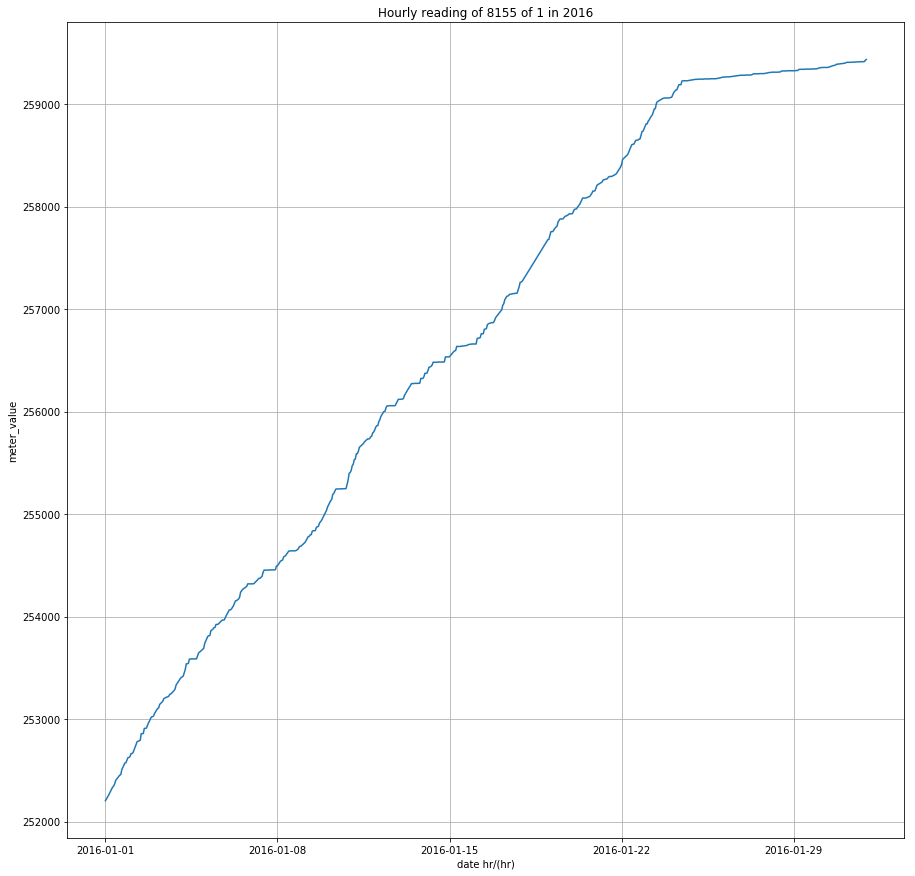

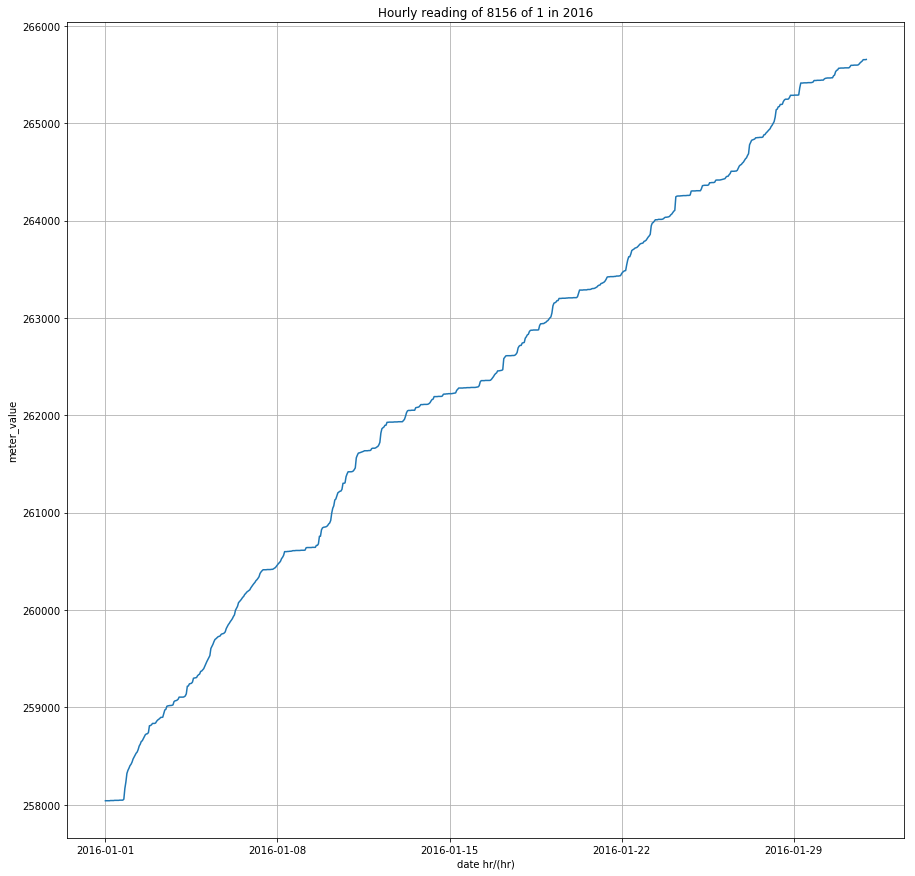

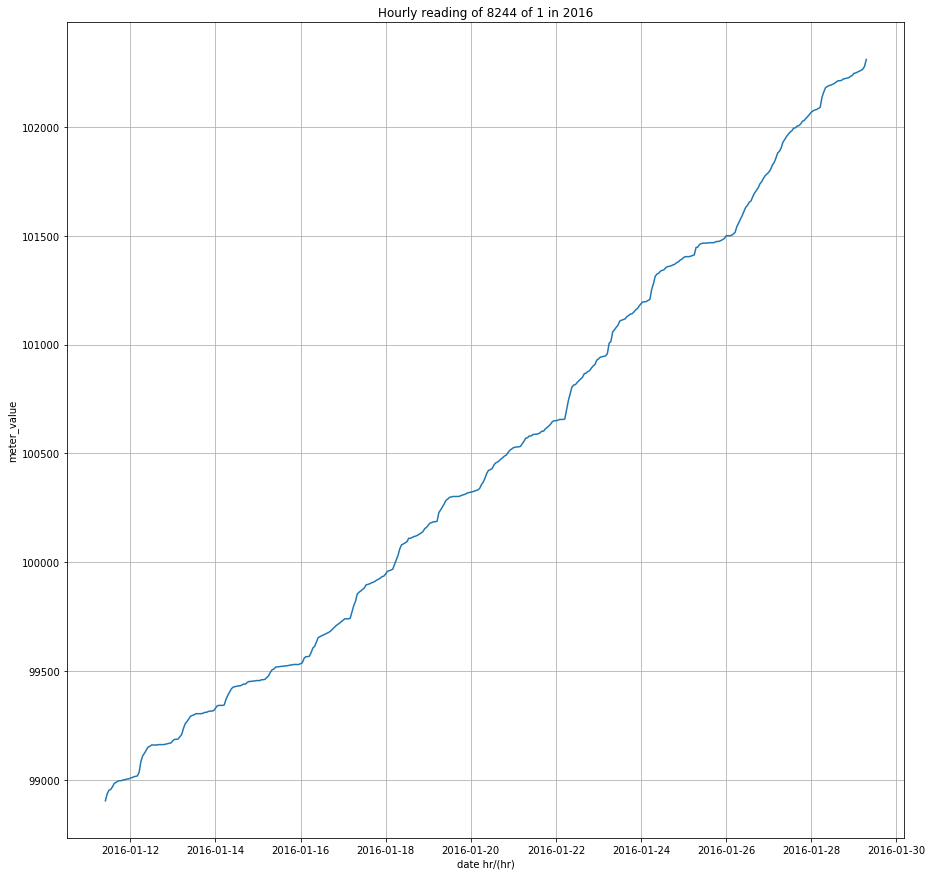

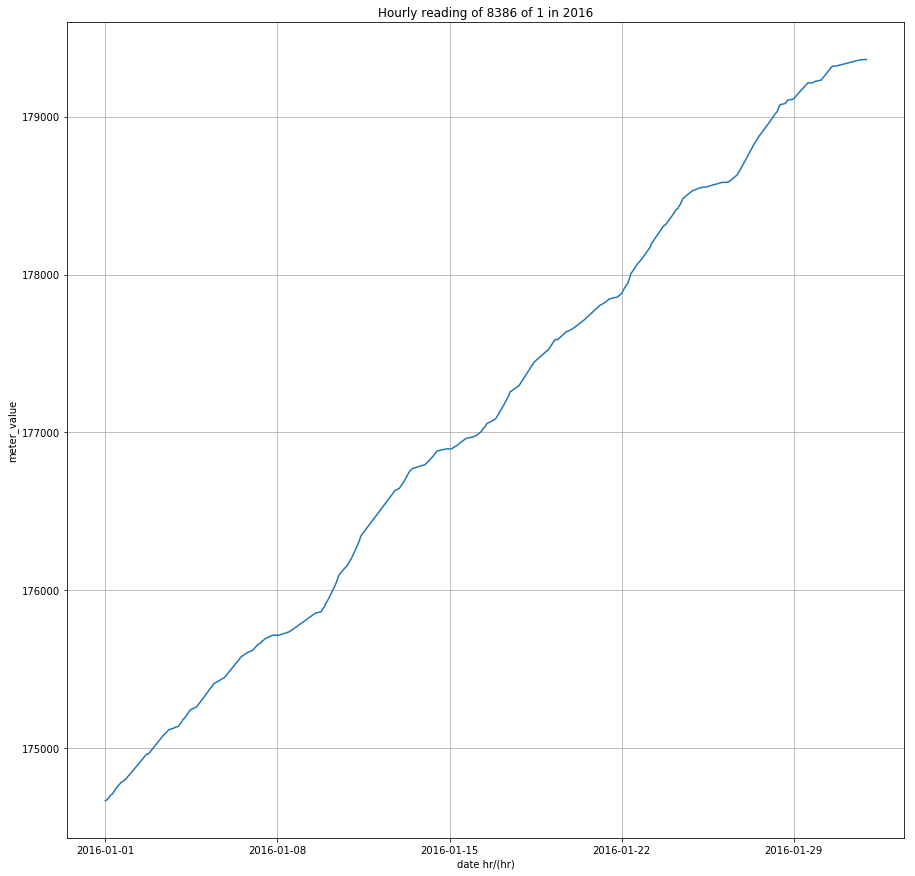

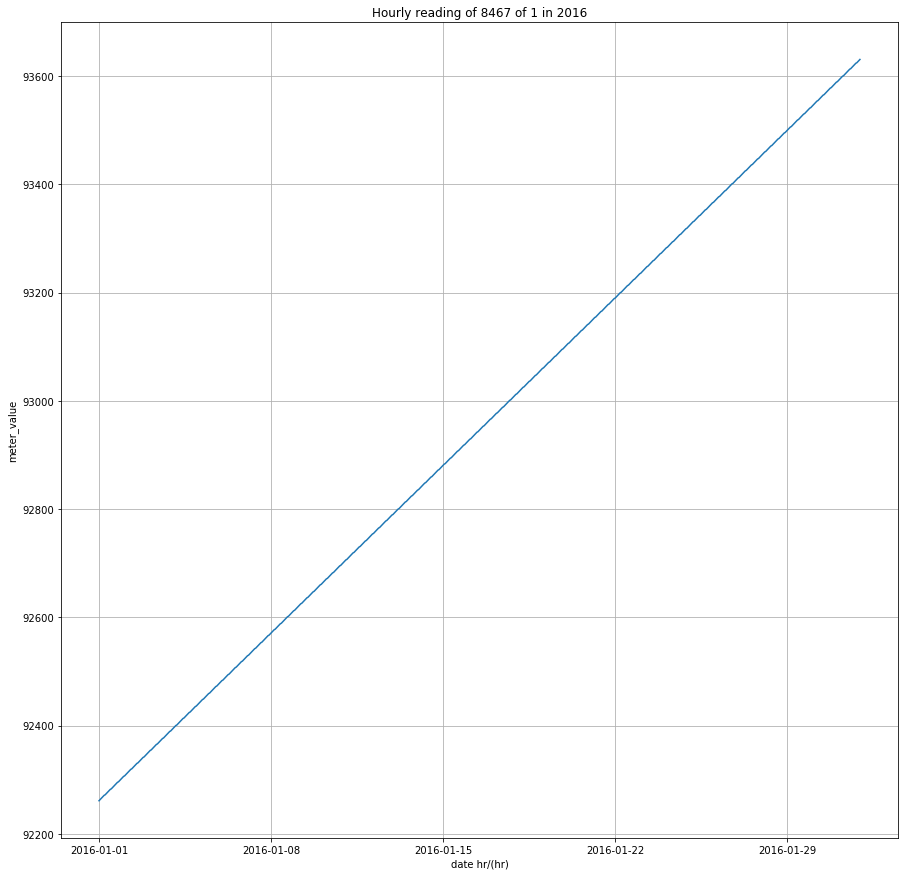

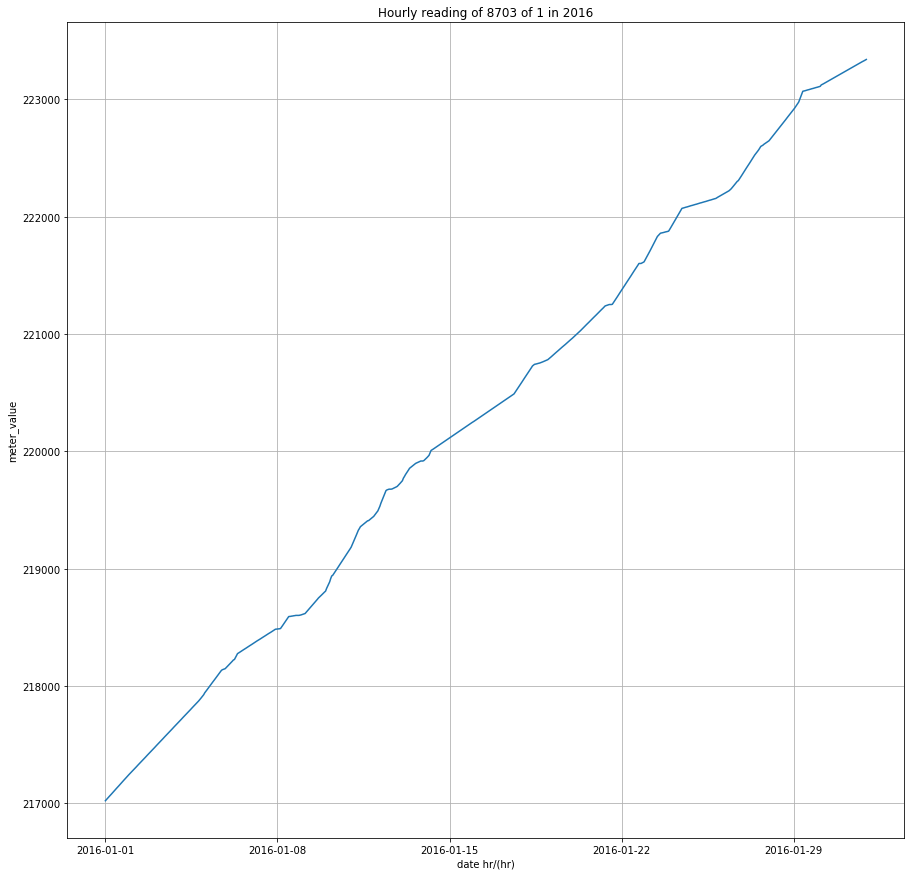

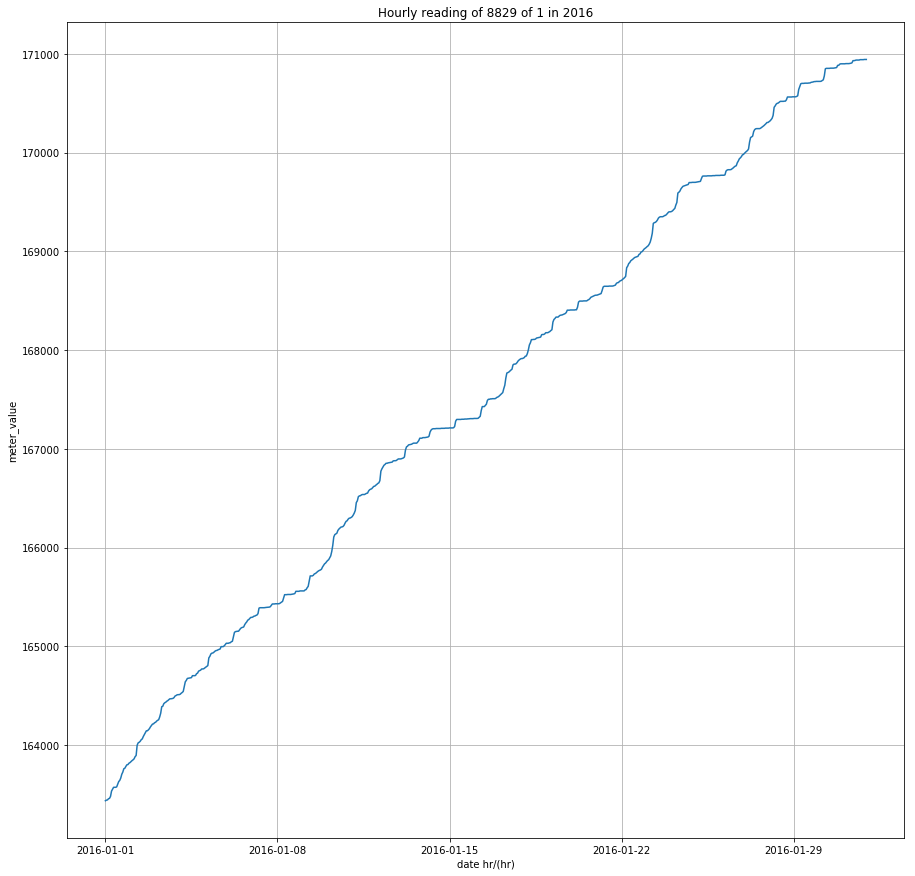

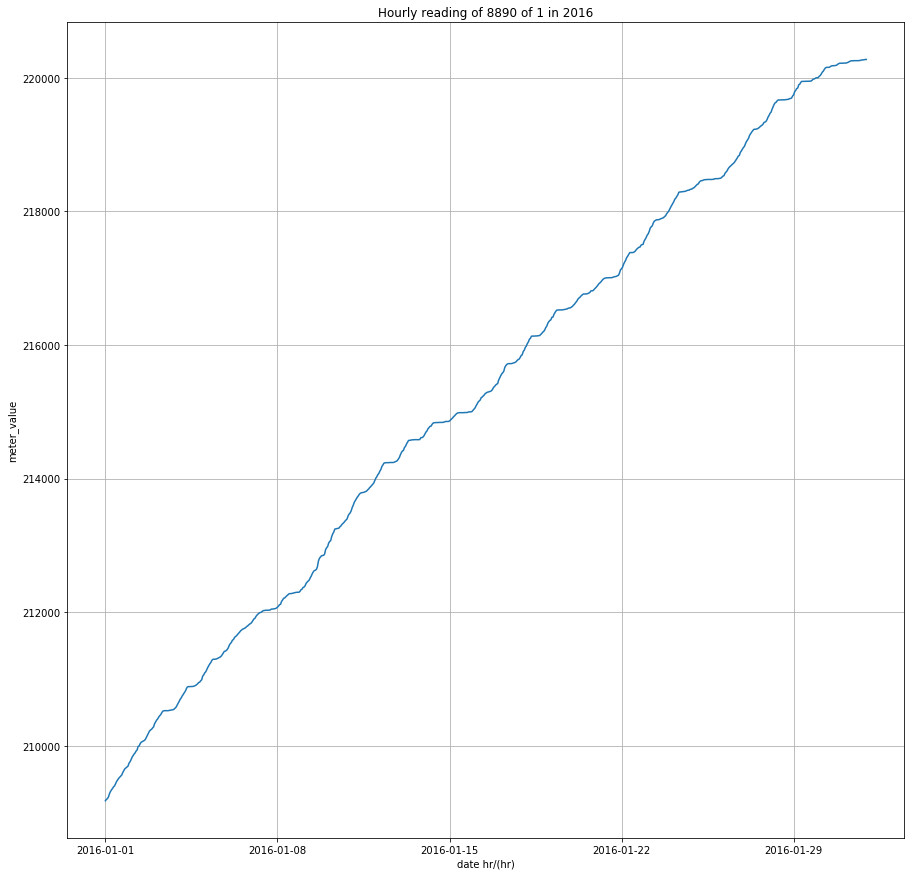

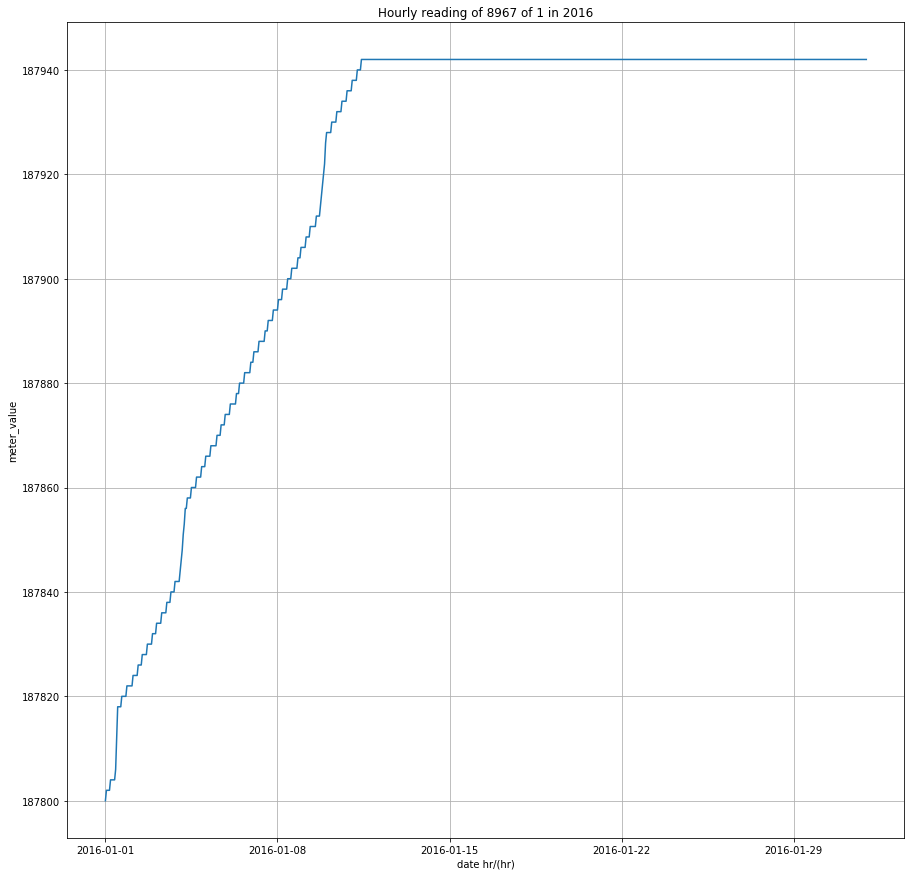

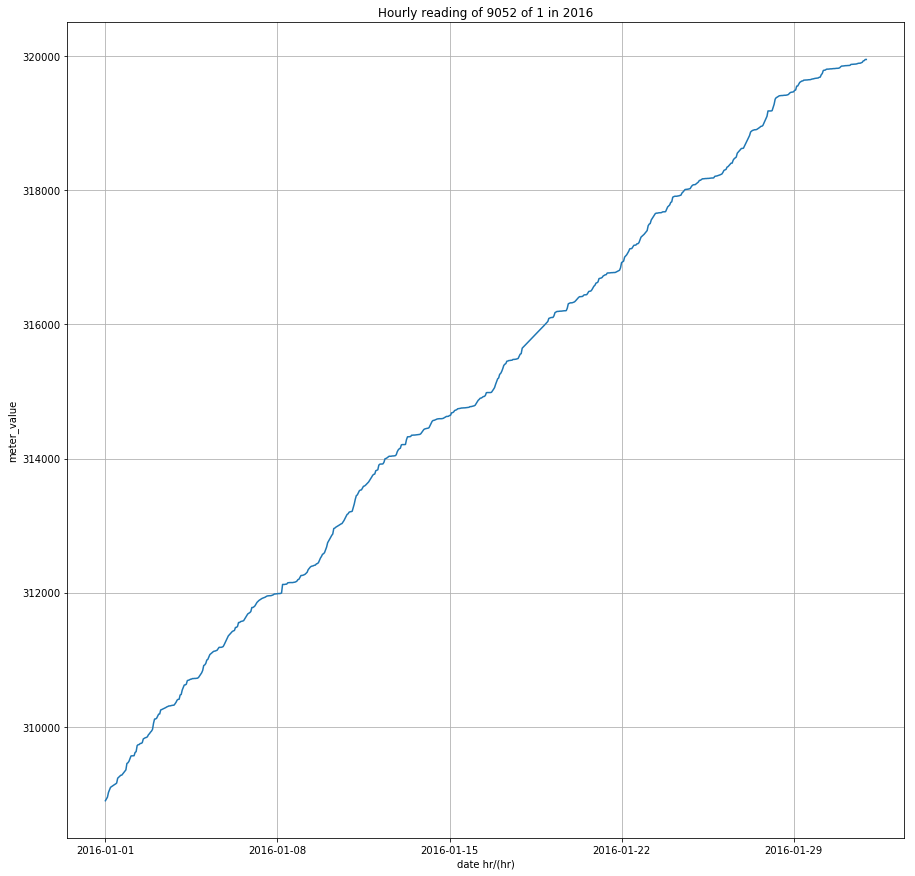

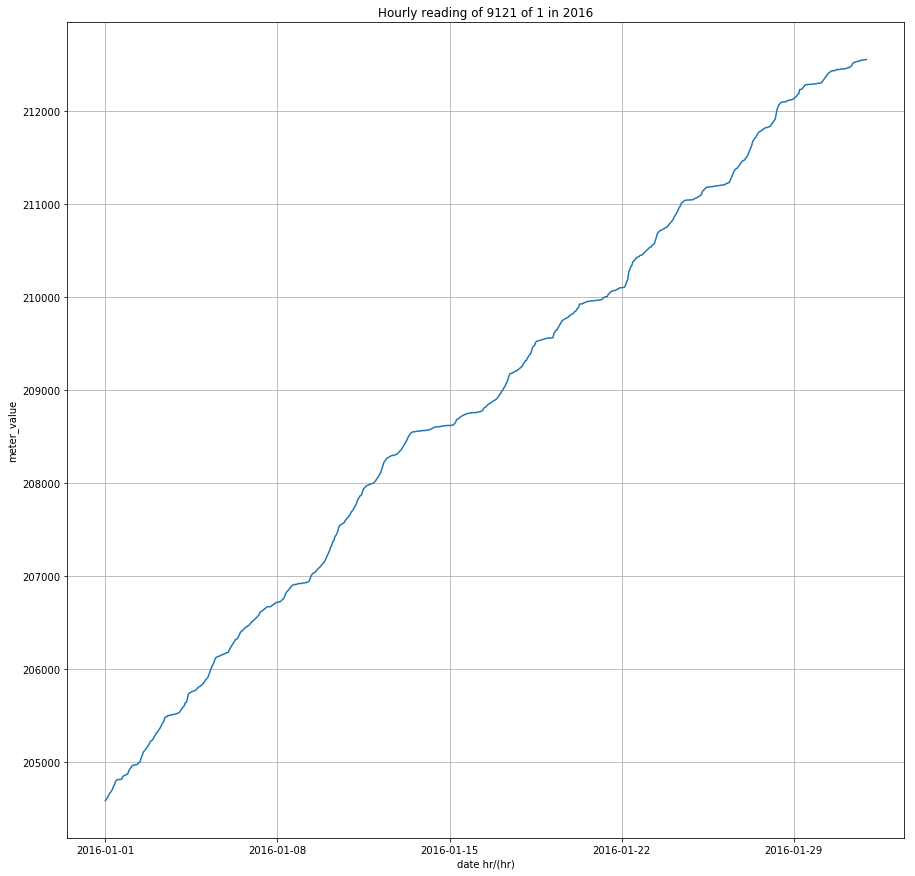

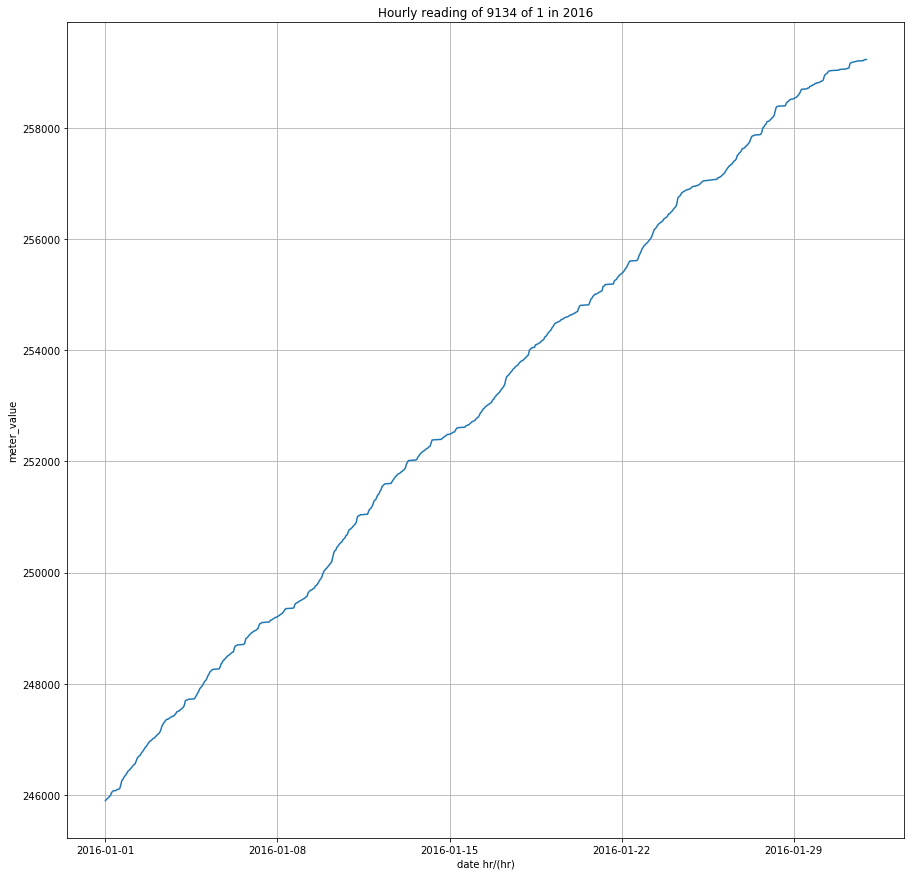

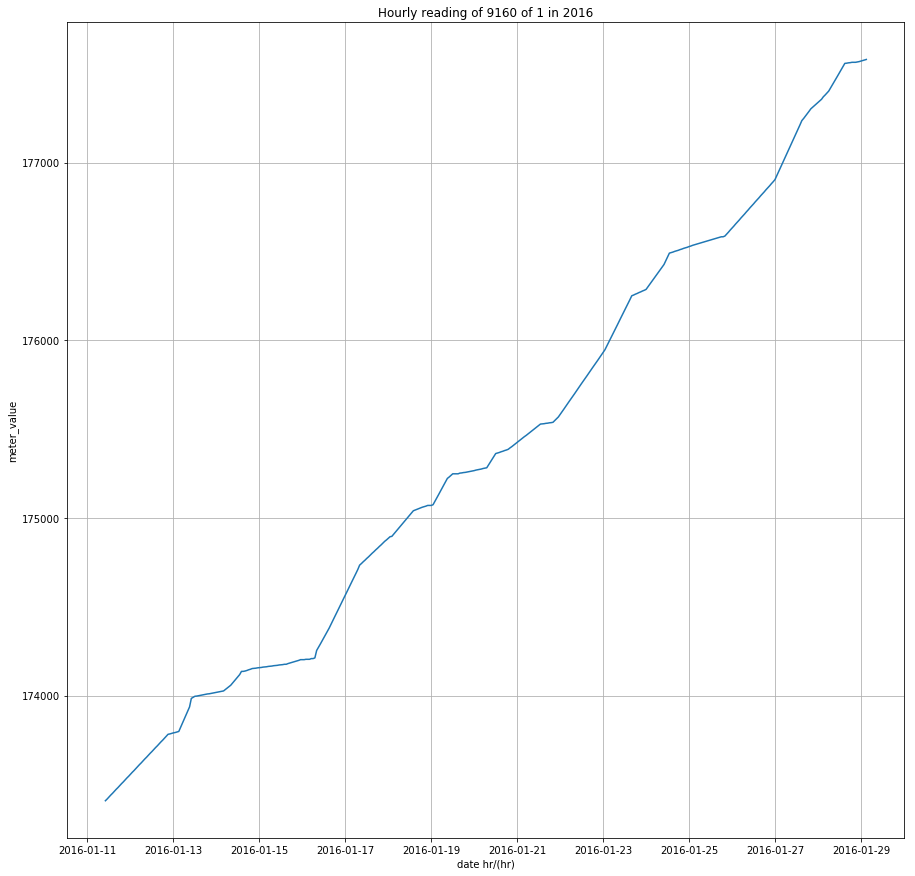

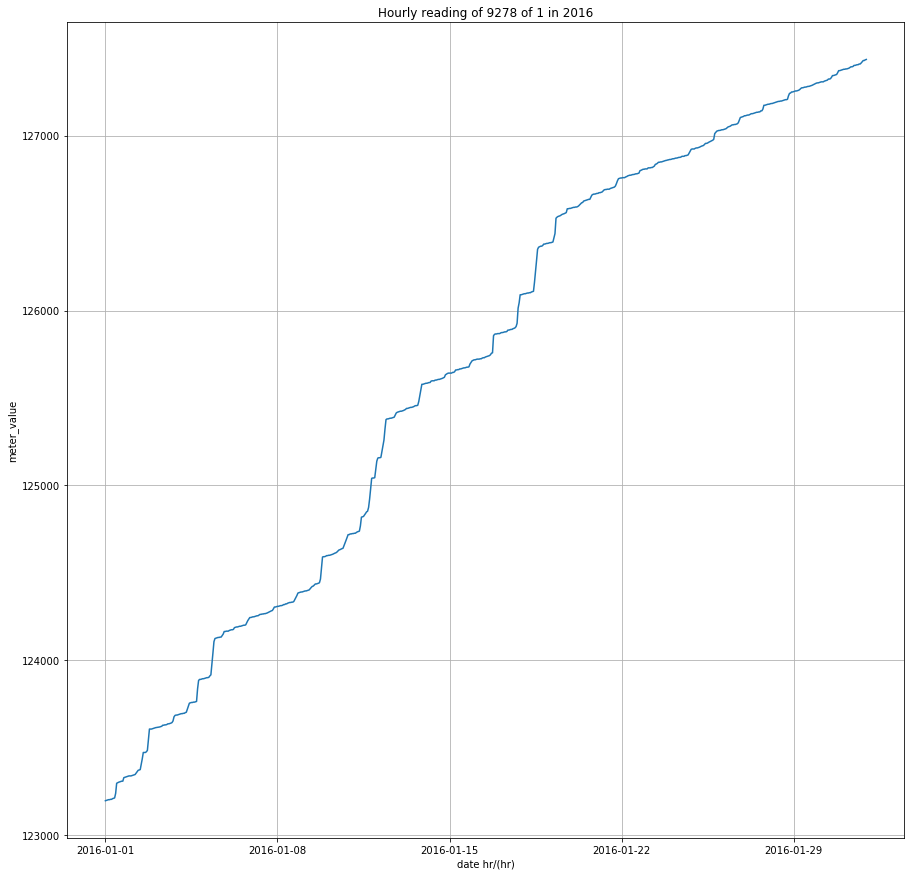

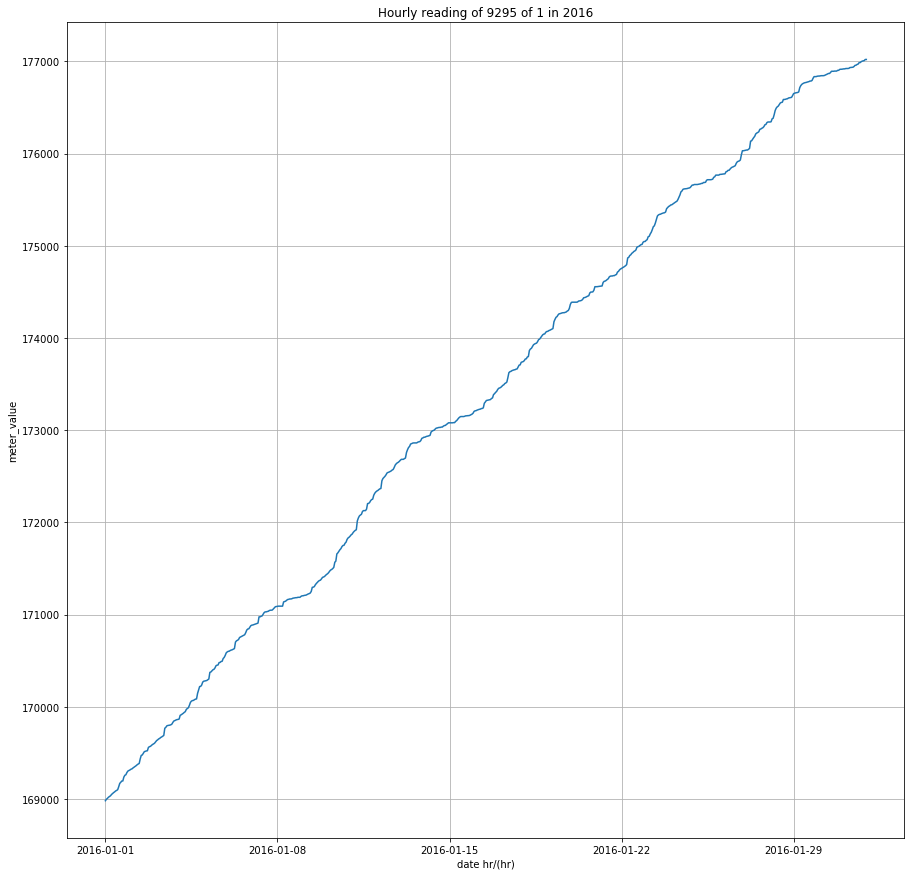

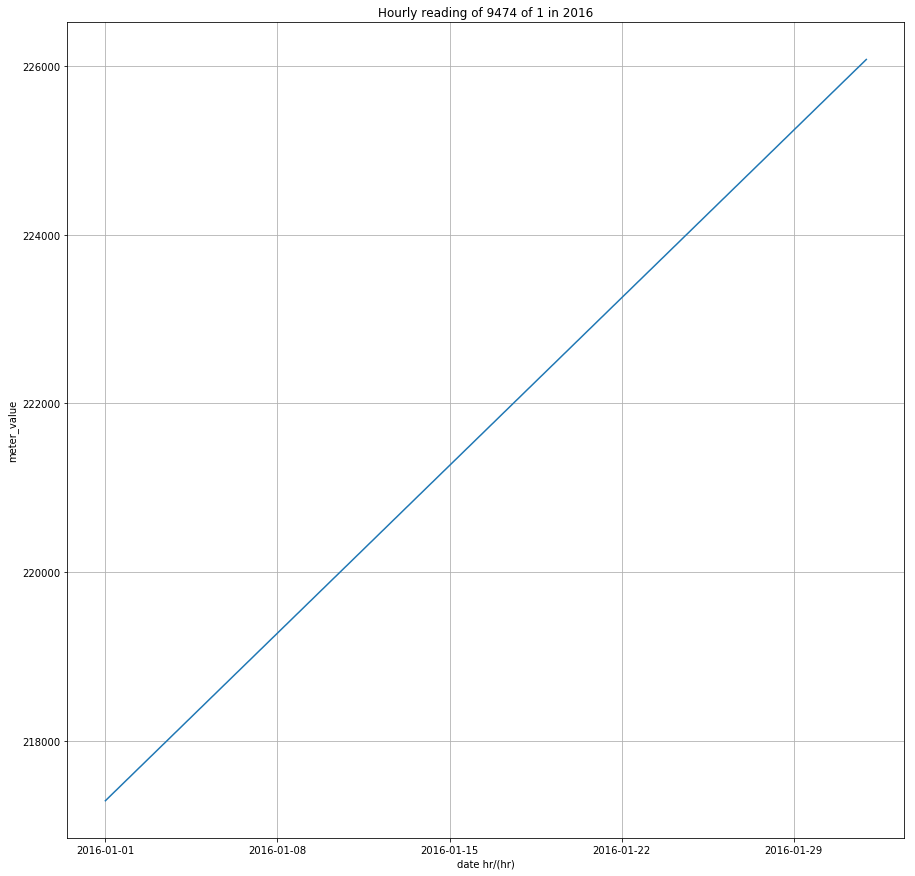

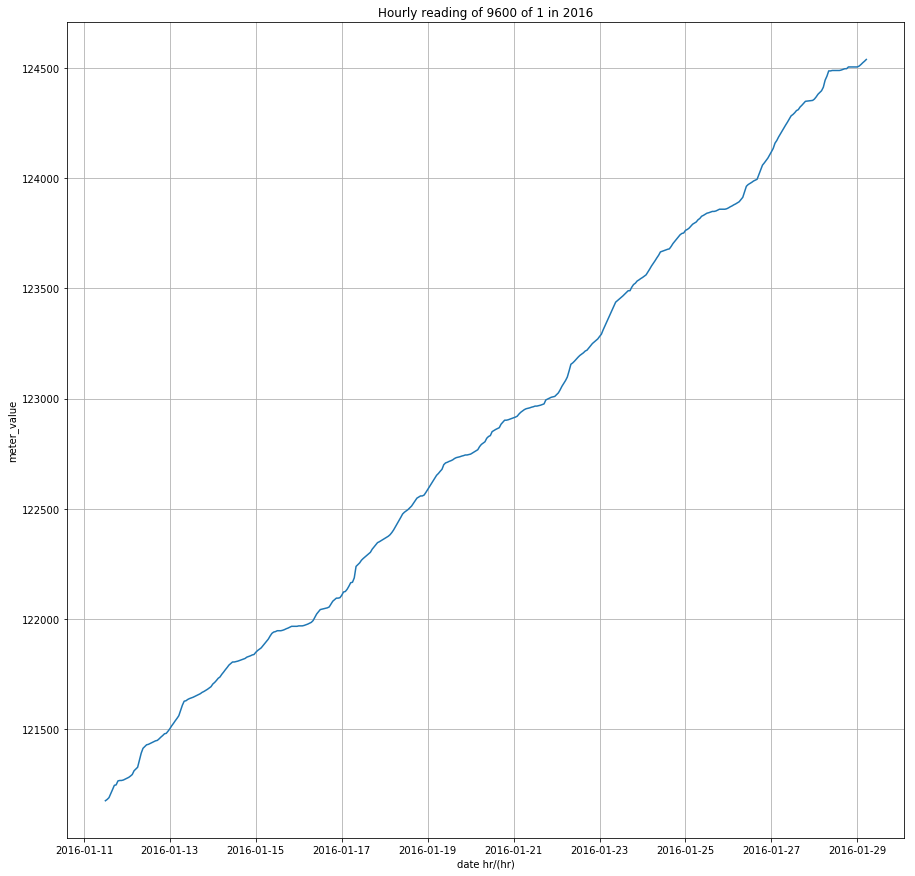

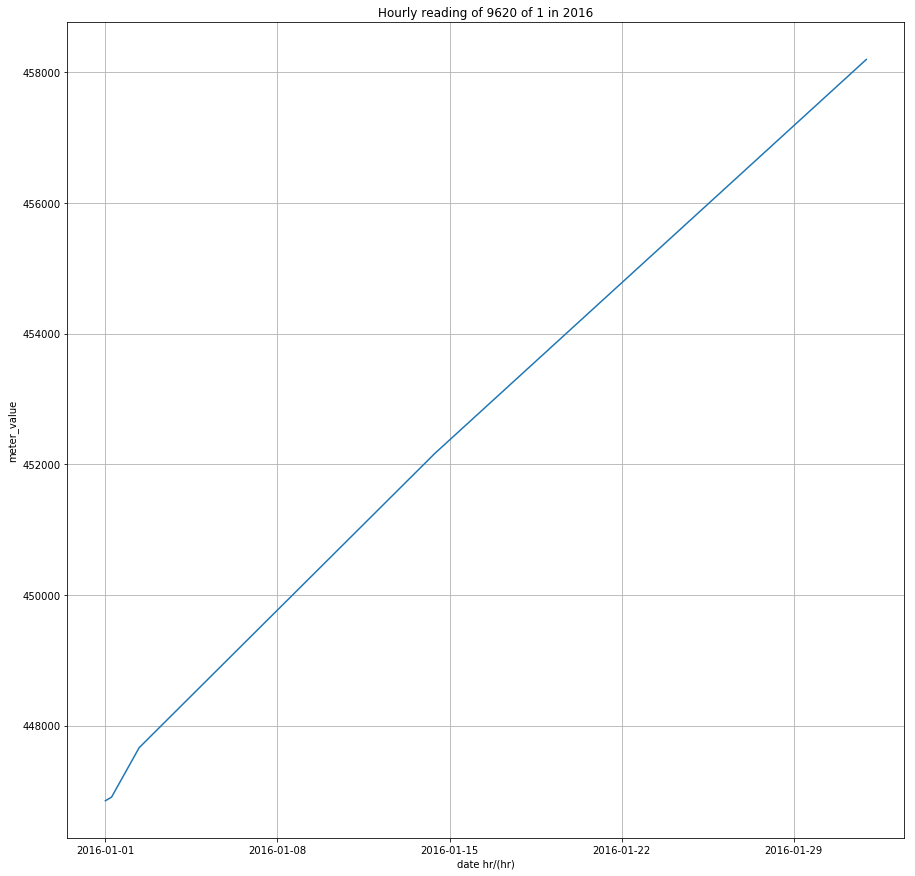

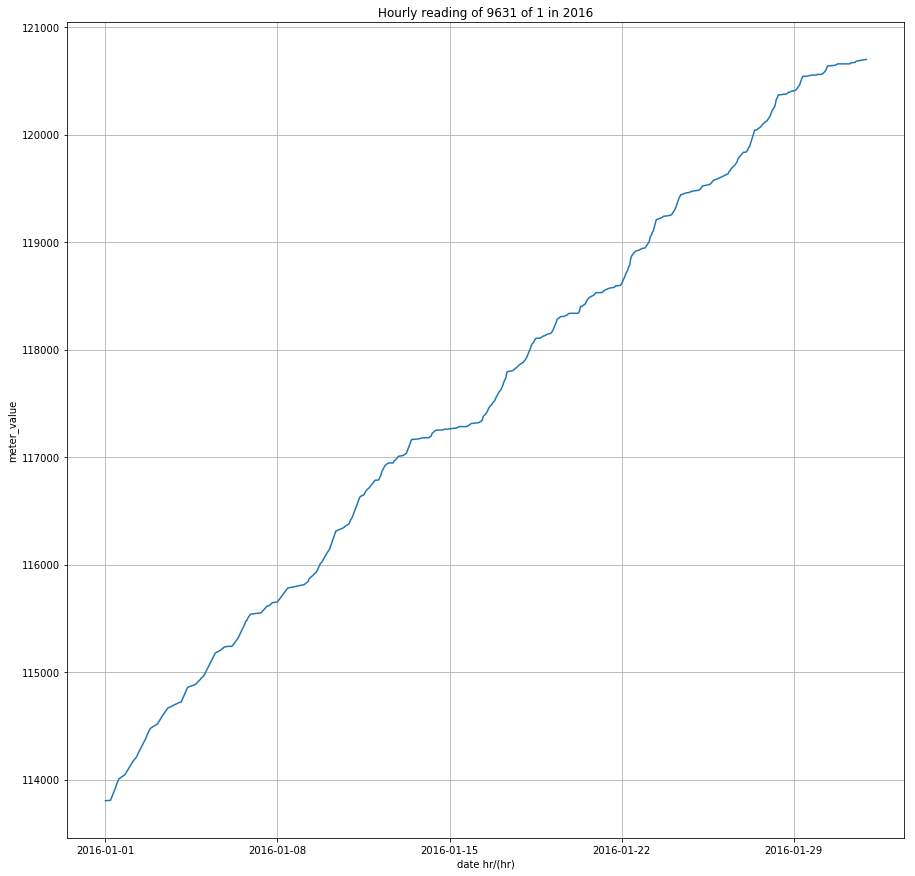

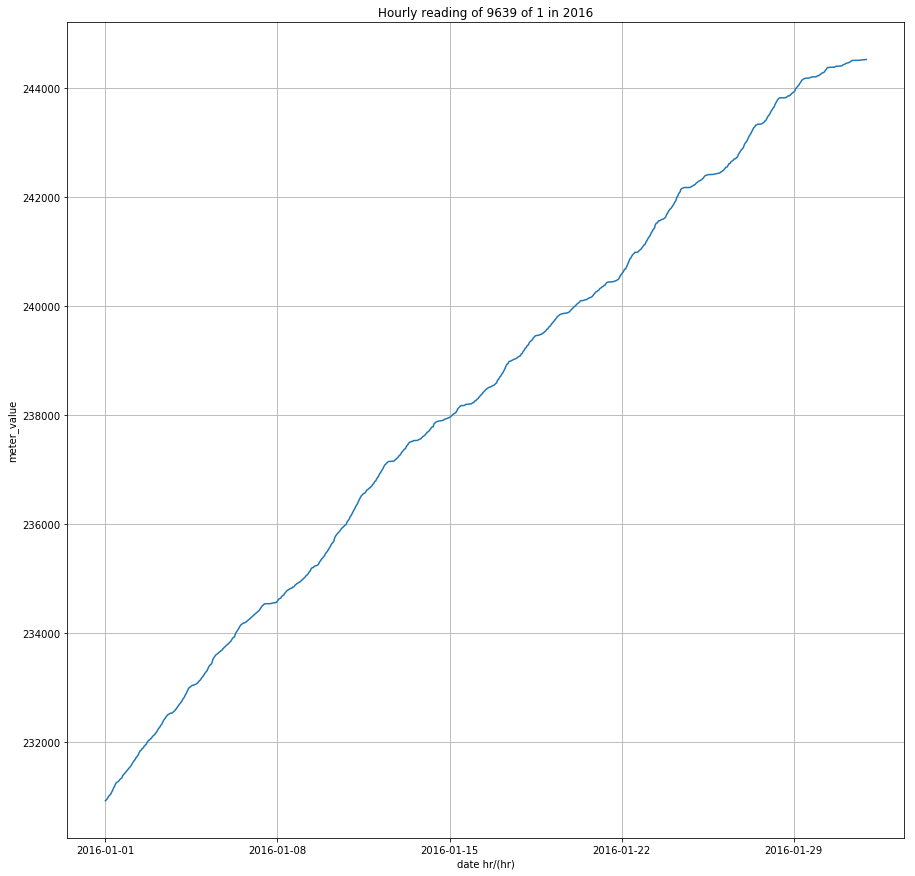

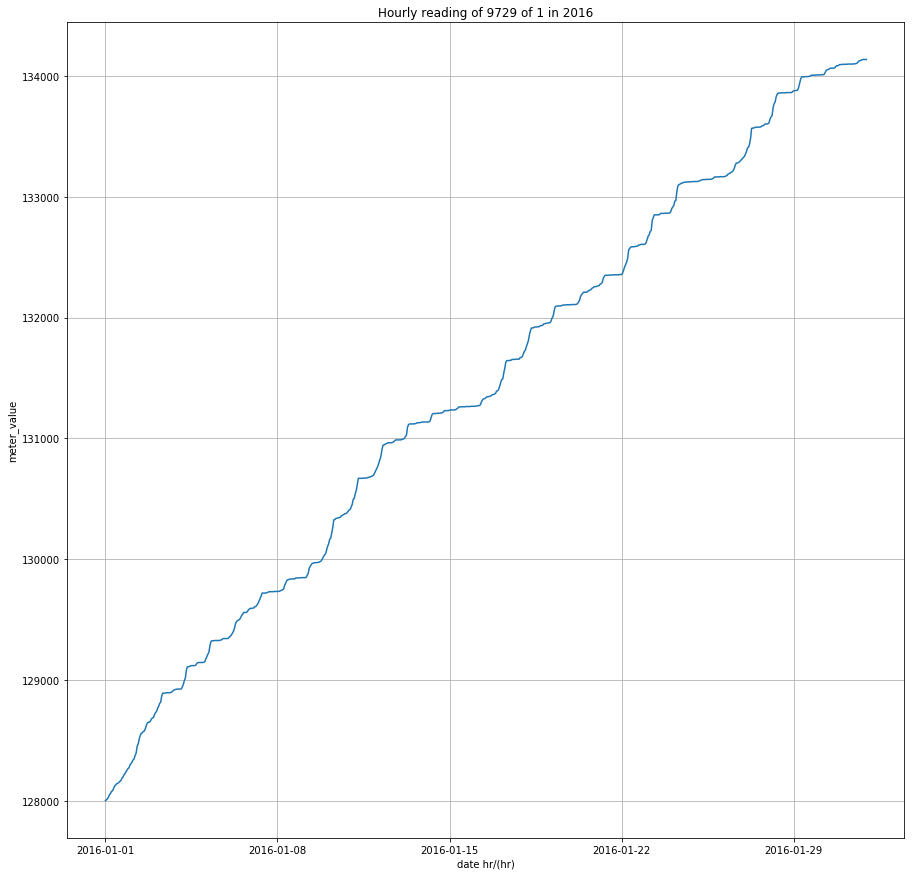

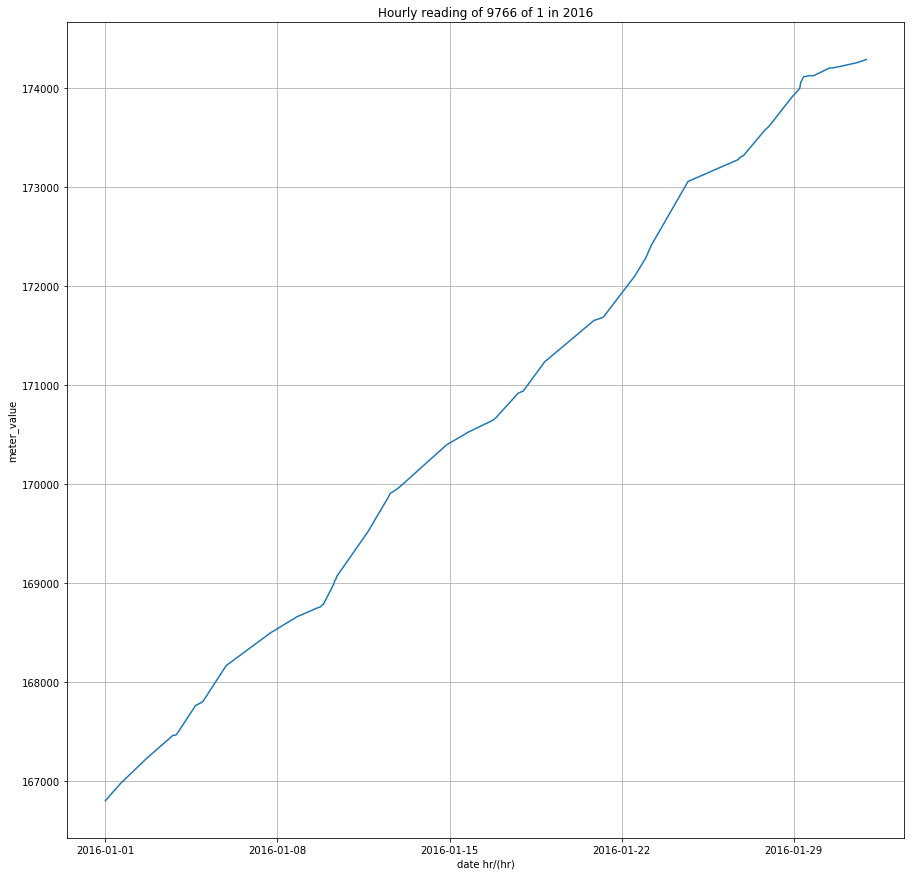

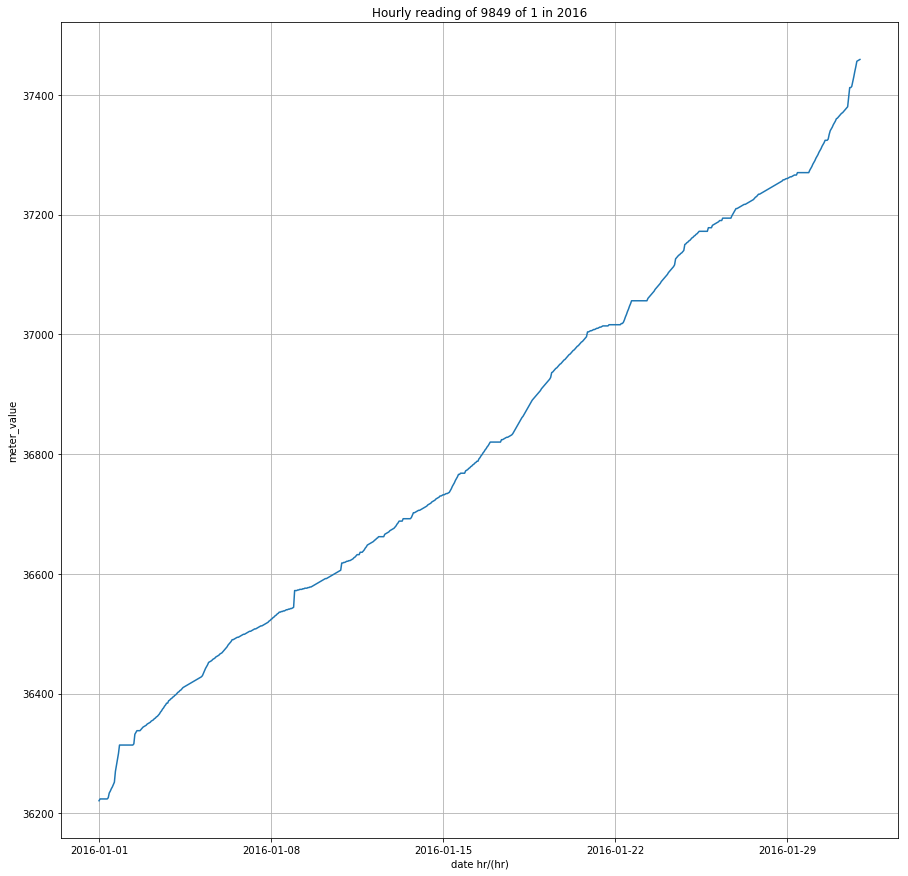

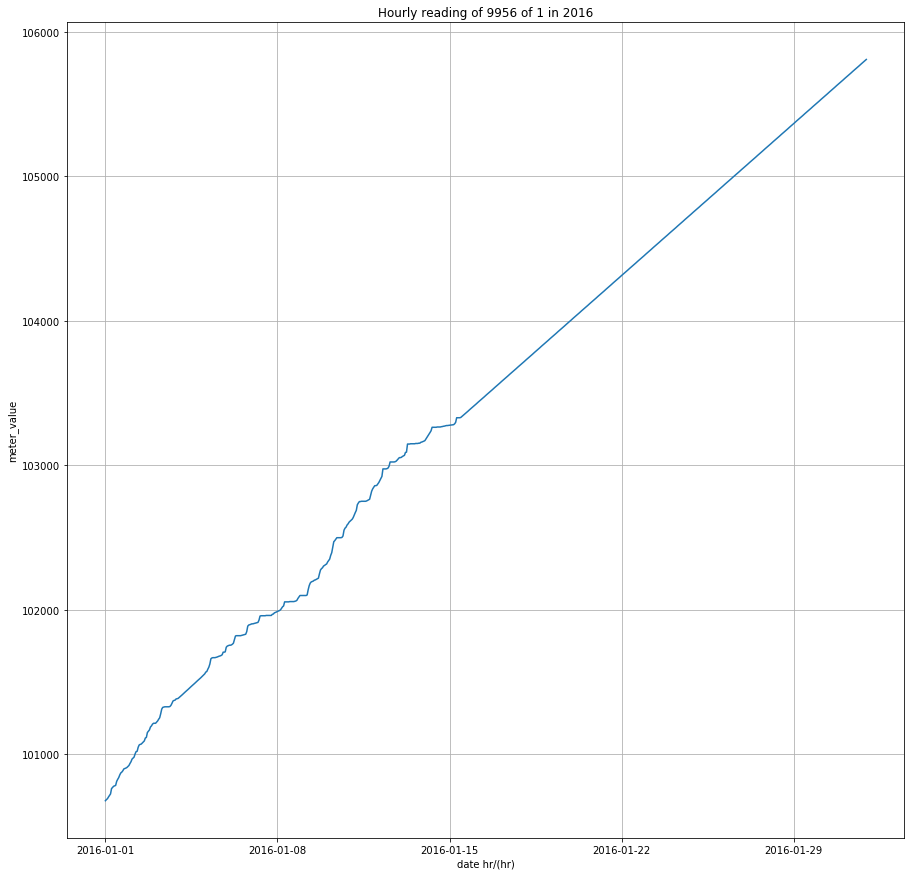

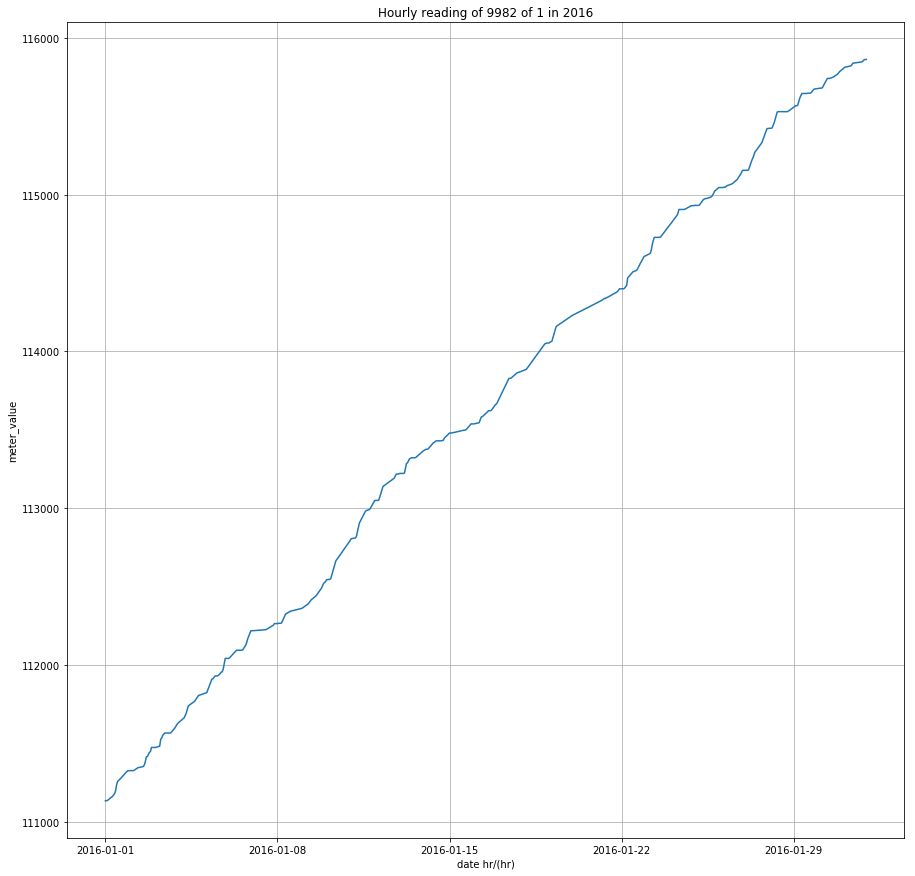

In [60]:
gas_hr=temp_gas_hr;
gas_hr=gas_hr[(gas_hr['localminute'].dt.year==2016)&(gas_hr['localminute'].dt.month==1)]
mon=2;
for _id in id_list:
    mon=2;
    temp_id_hr=gas_hr[gas_hr['dataid']==_id];
    while(len(temp_id_hr)==0):
        temp_id_hr=temp_gas_hr[(temp_gas_hr['localminute'].dt.year==2016)&(temp_gas_hr['localminute'].dt.month==mon)
                              &(temp_gas_hr['dataid']==_id)];
        mon=mon+1;
    temp_id_hr=temp_id_hr.reset_index(drop=True);
    t='Hourly reading of '+str(_id)+' of '+str(temp_id_hr.at[0,'localminute'].month)+' in '+str(temp_id_hr.at[0,'localminute'].year);
    fig=plt.figure(figsize=(15,15));
    plt.plot(temp_id_hr.localminute,temp_id_hr.meter_value);
    plt.xlabel('date hr/(hr)');
    plt.ylabel('meter_value'),
    plt.title(t,loc='center');
    plt.grid();
    t_fig=t+'.png';
    fig.savefig(t_fig);
    plt.show();

In [ ]:
8967